In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
from VisUtils import *

In [2]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [3]:
gp_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/GP/GP_matern_kernel/'
nek_list = ["2", "3", "5", "9"]
k = 7 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']

NEK2 binding


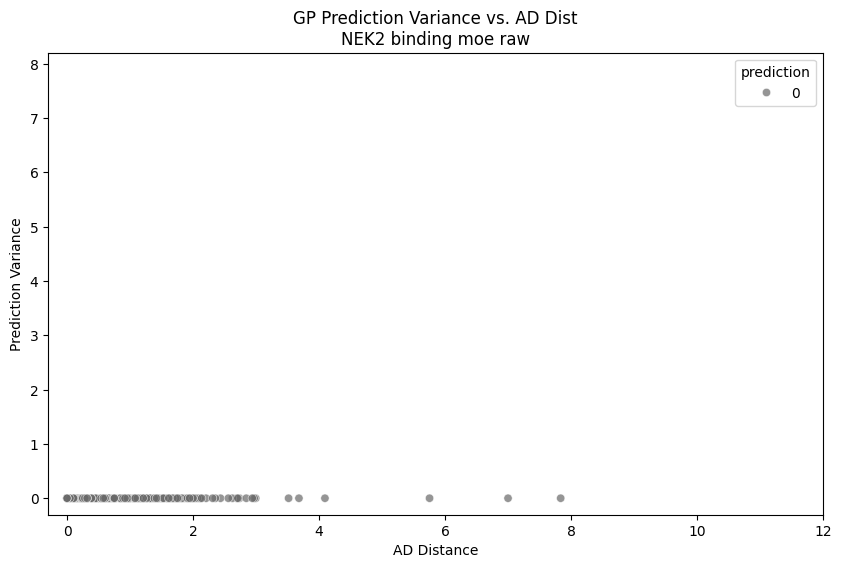

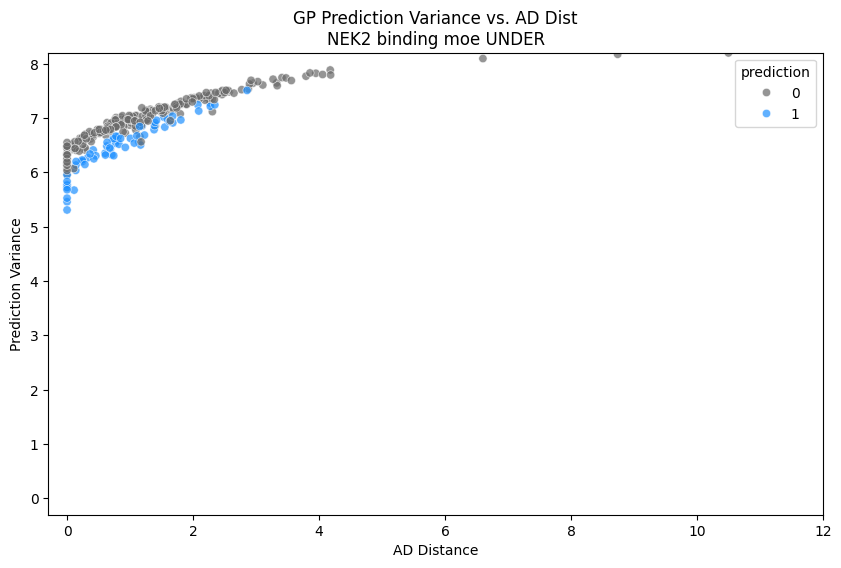

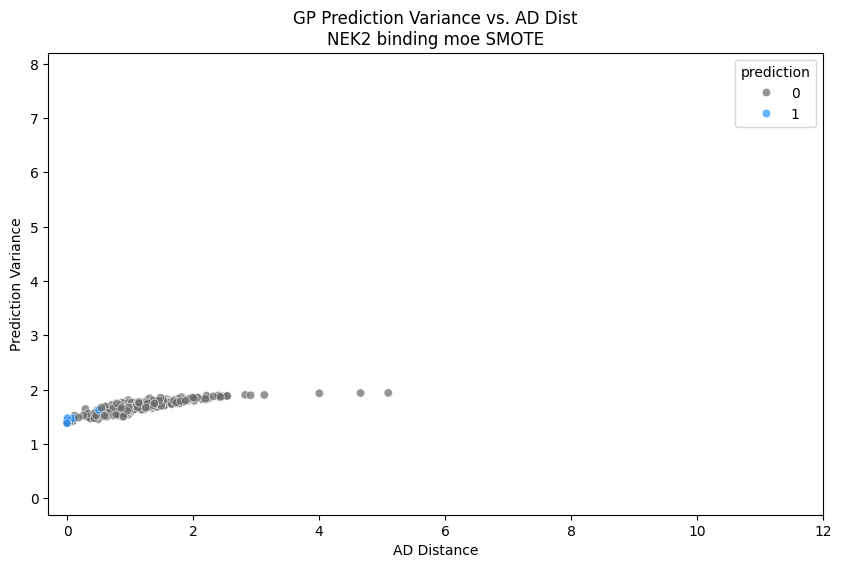

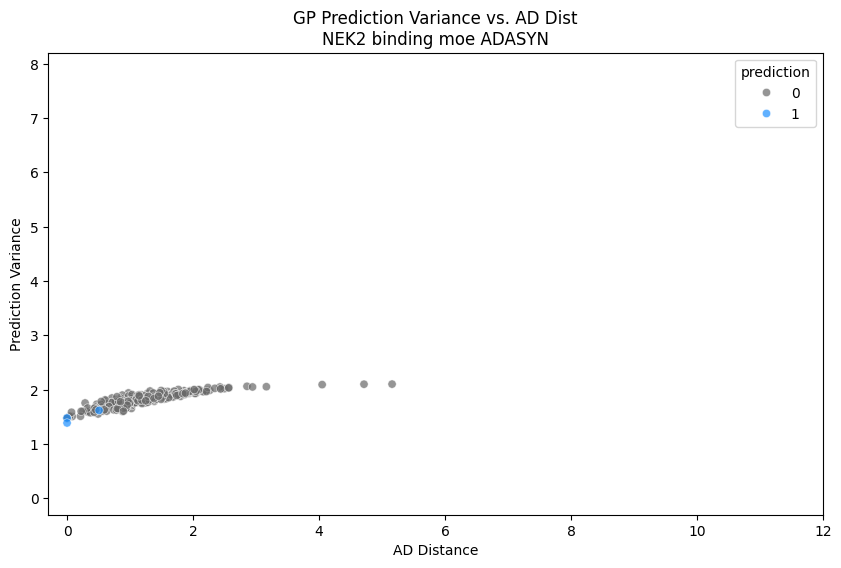

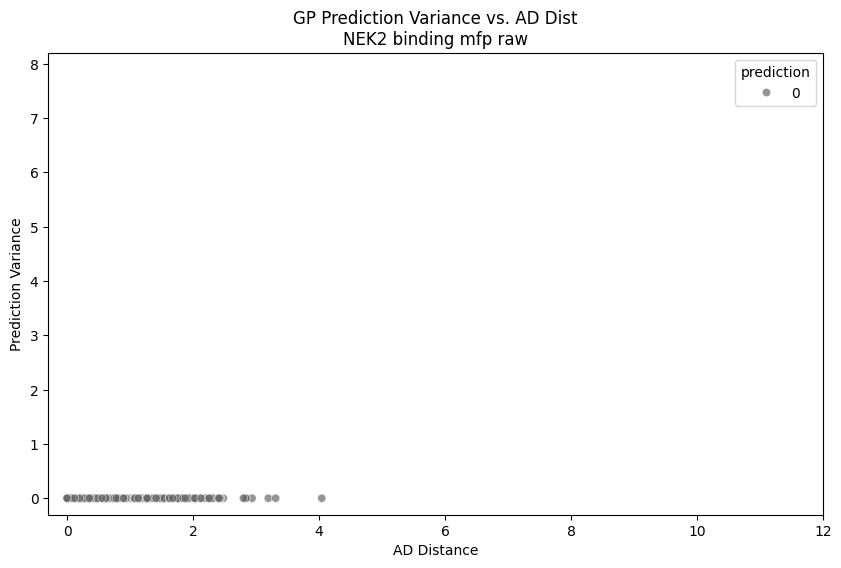

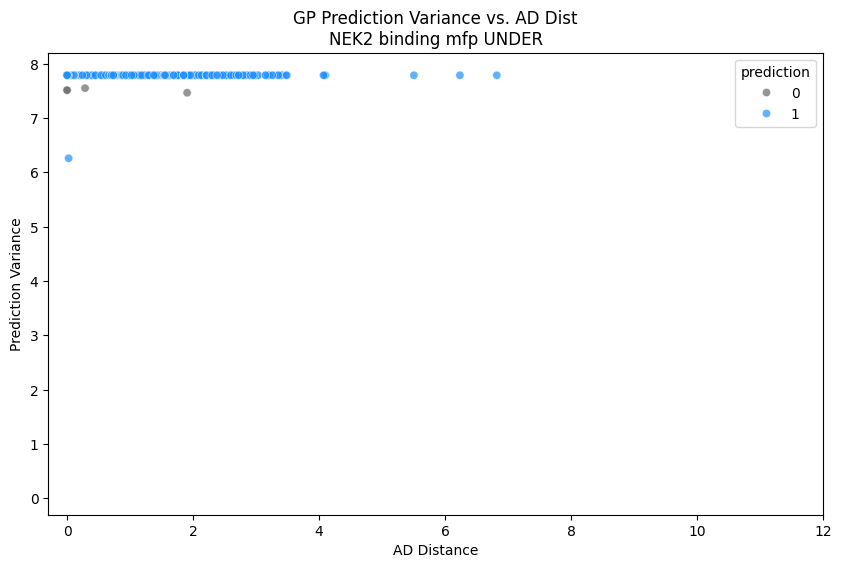

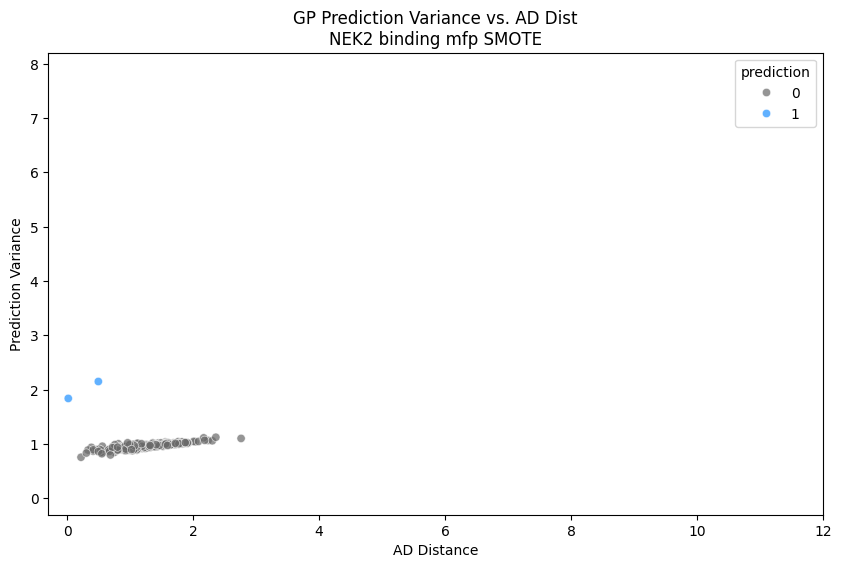

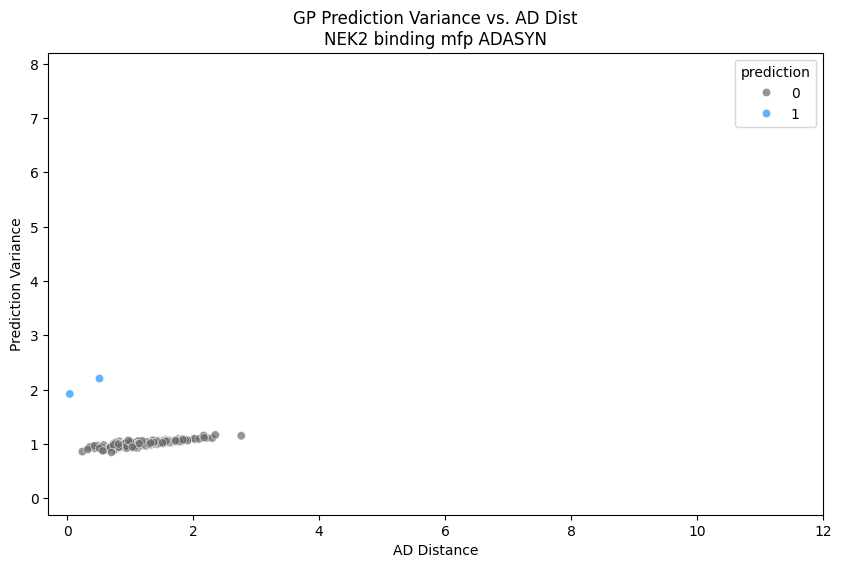

NEK2 inhibition


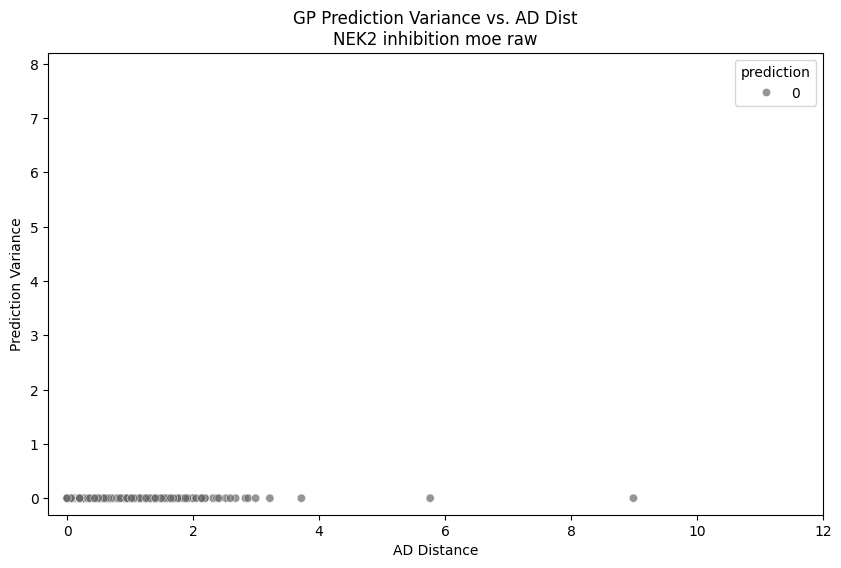

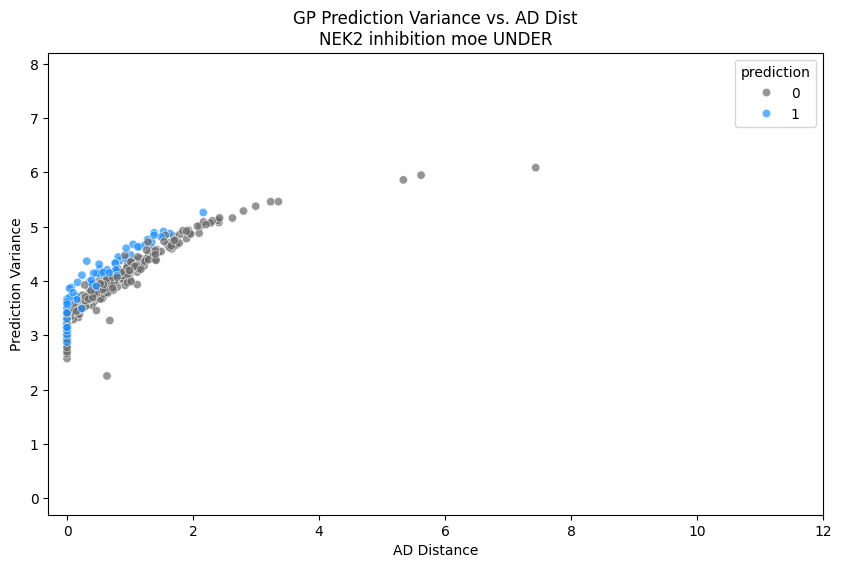

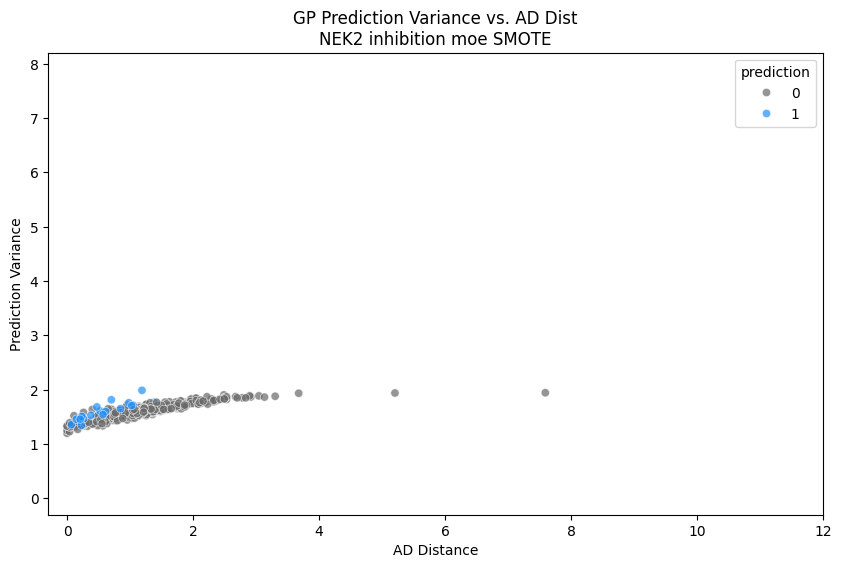

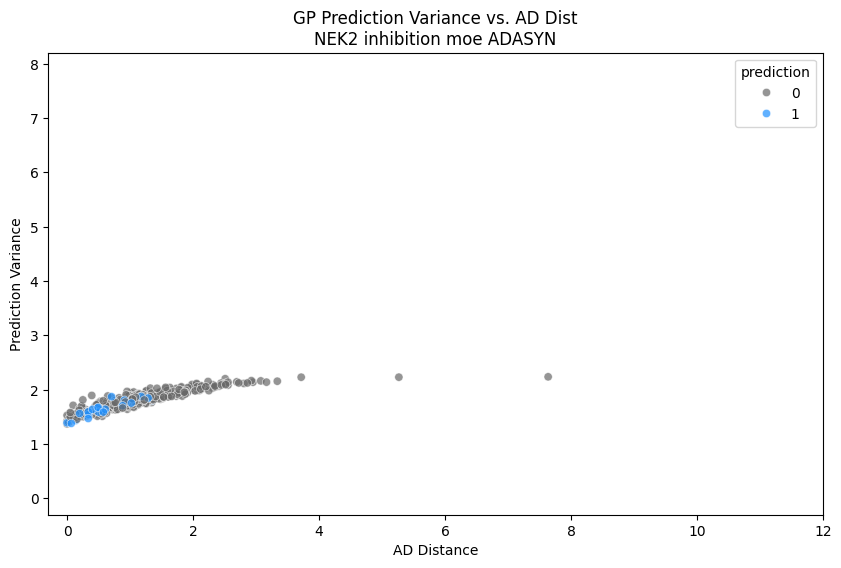

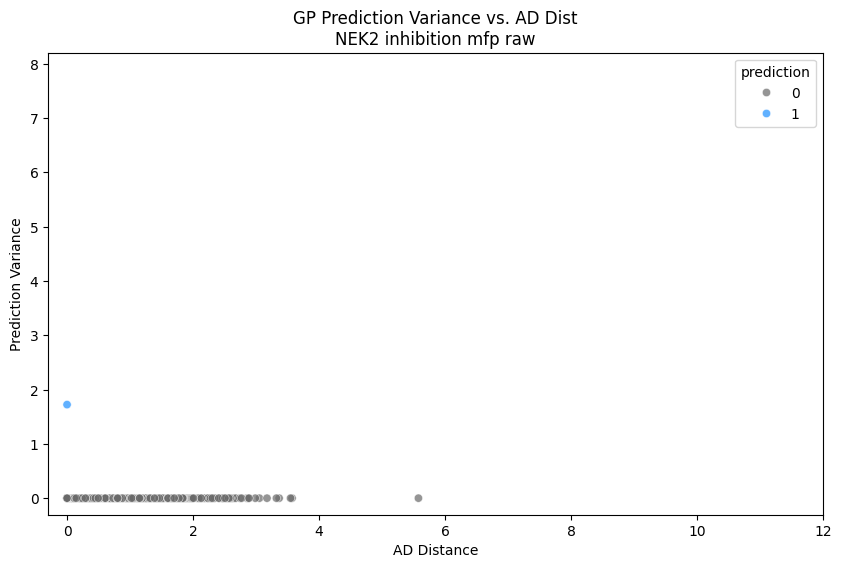

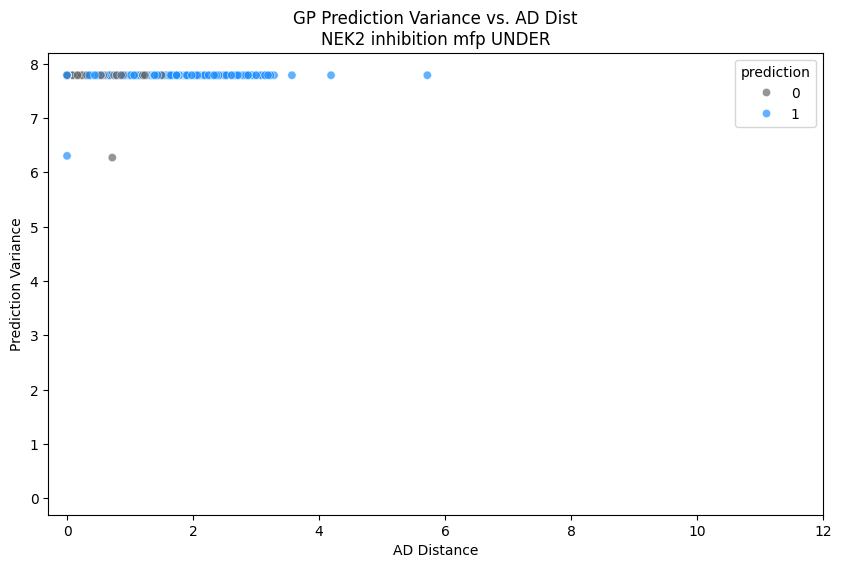

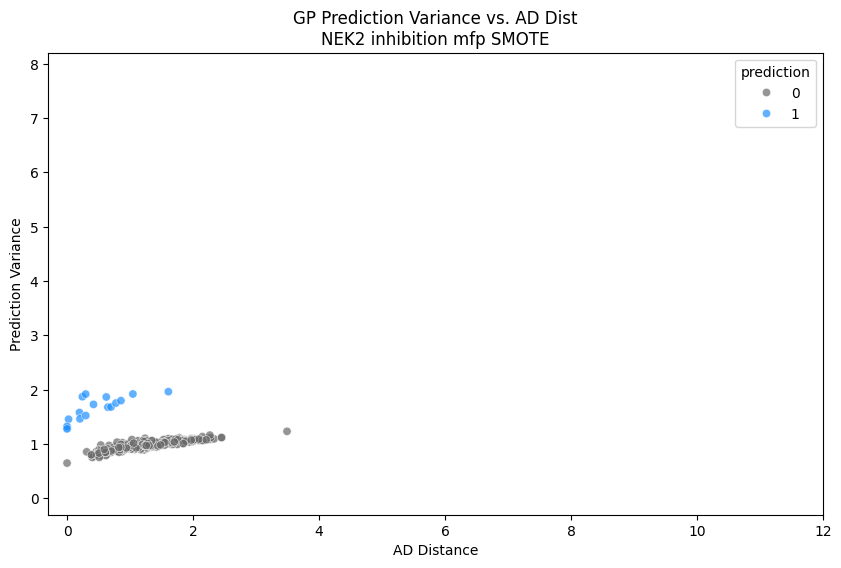

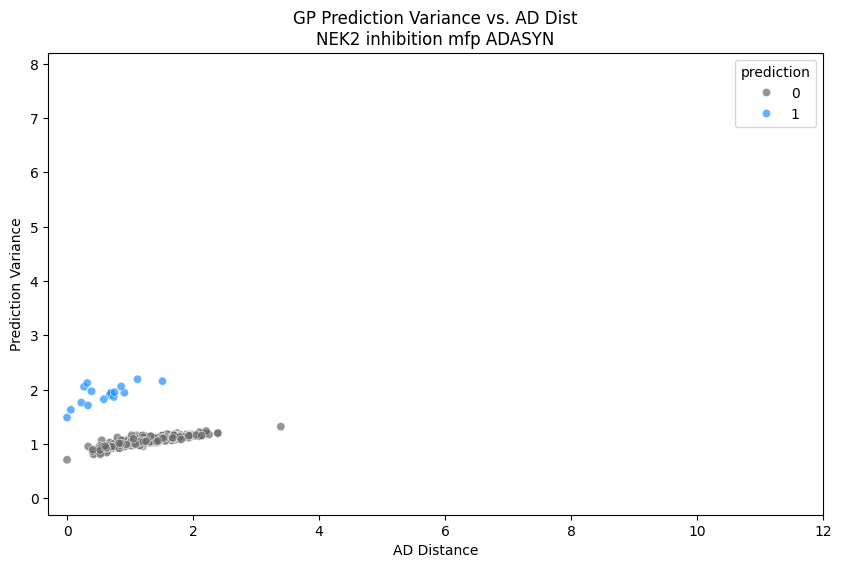

NEK3 binding


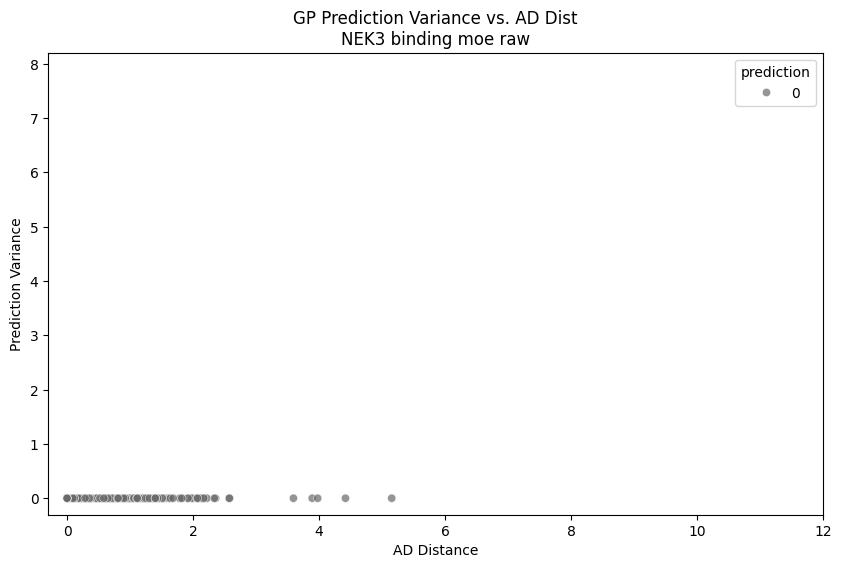

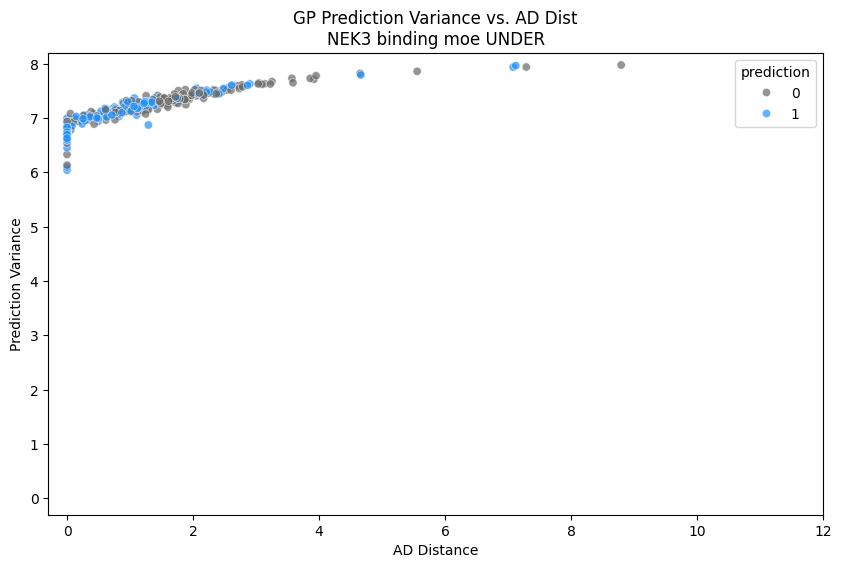

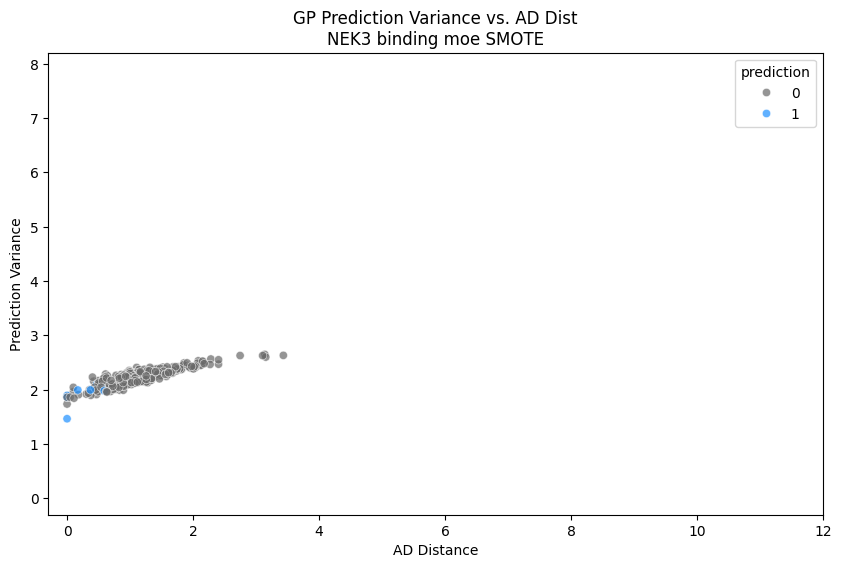

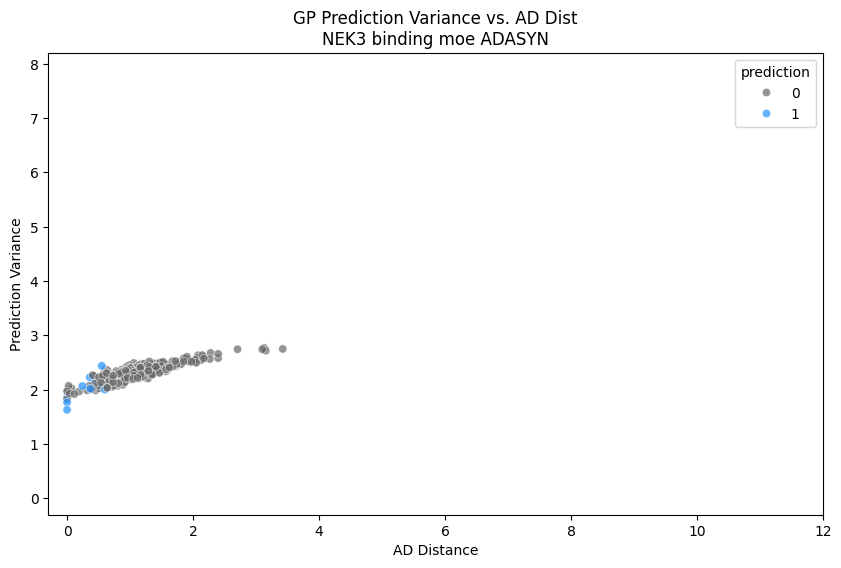

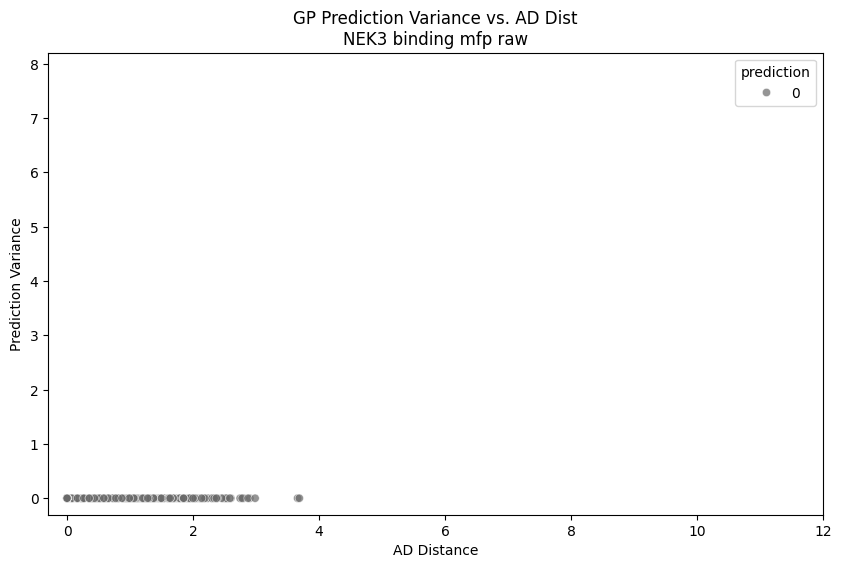

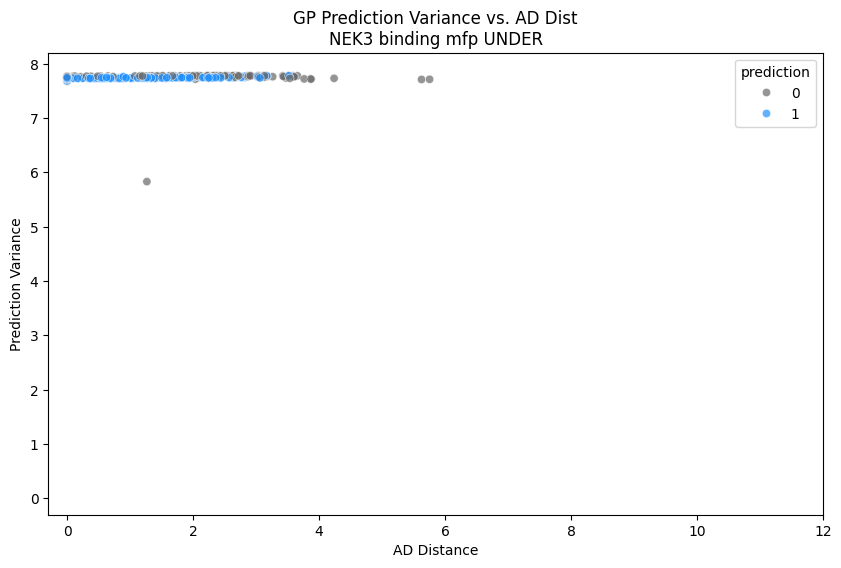

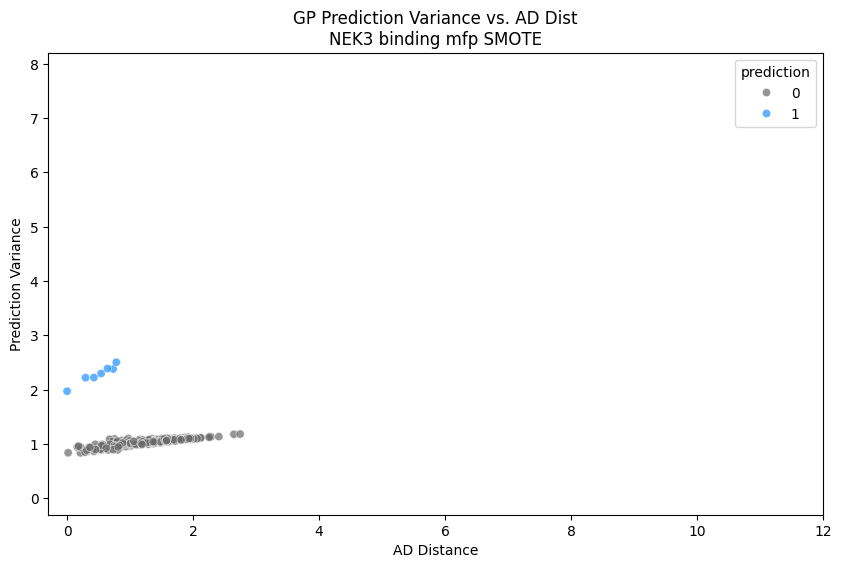

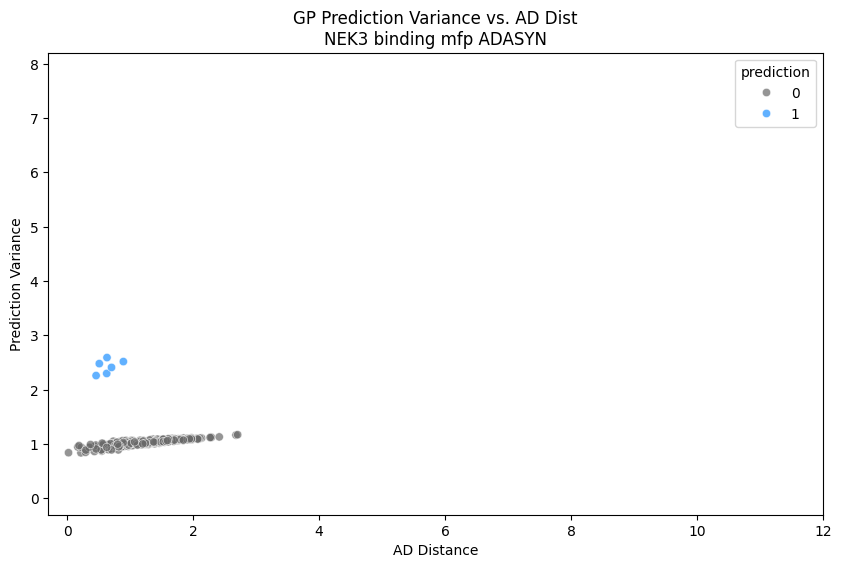

NEK5 binding


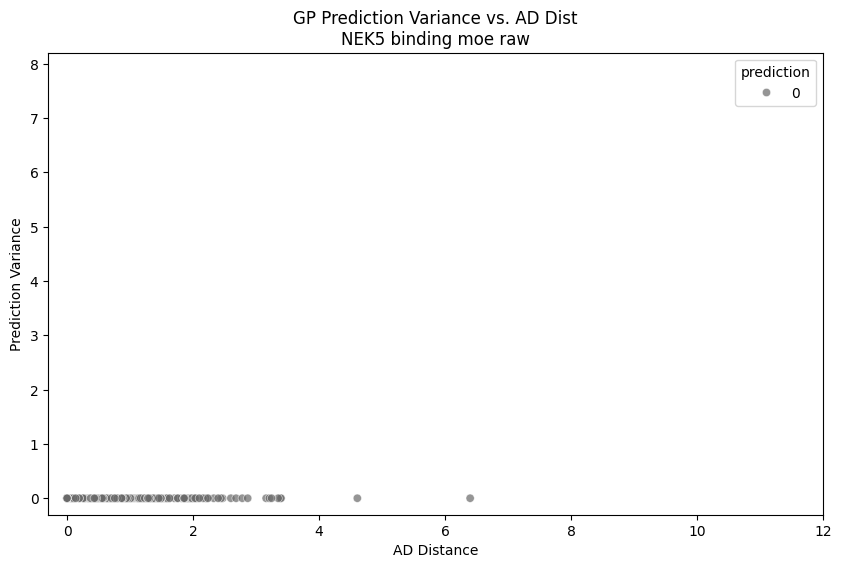

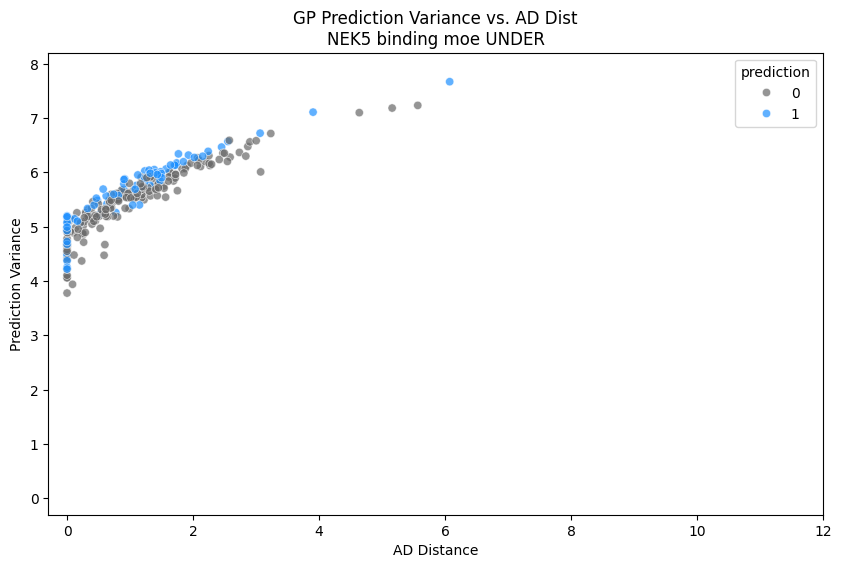

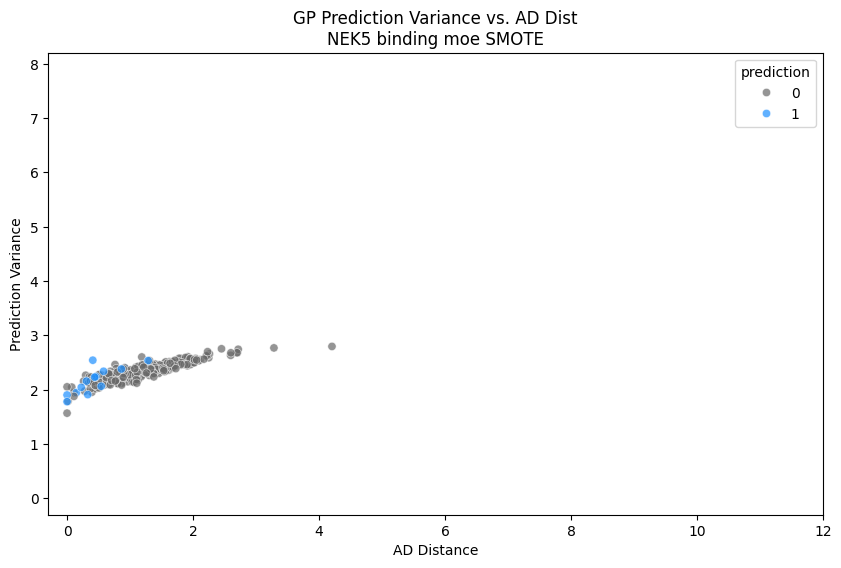

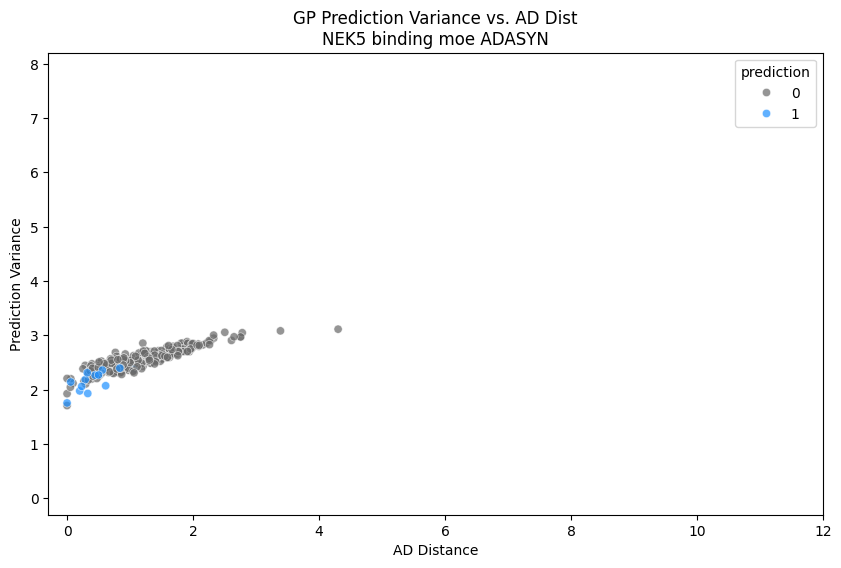

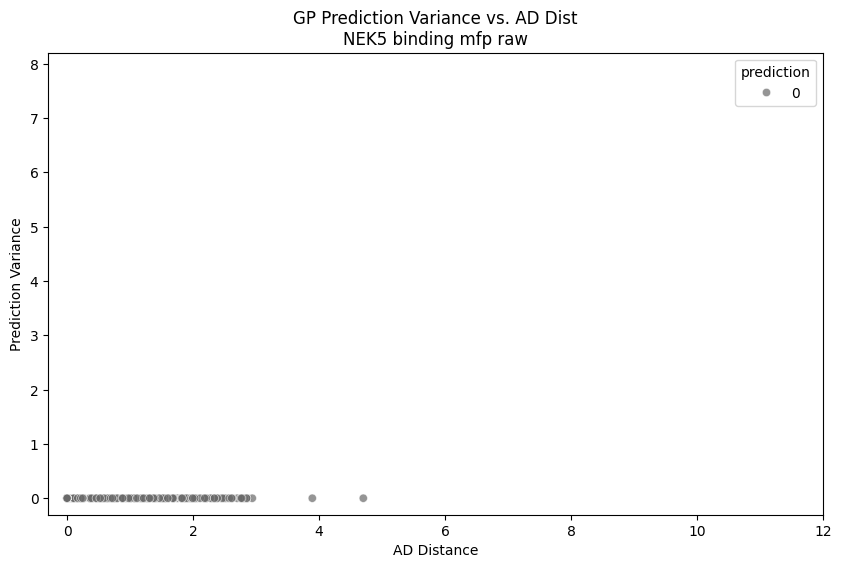

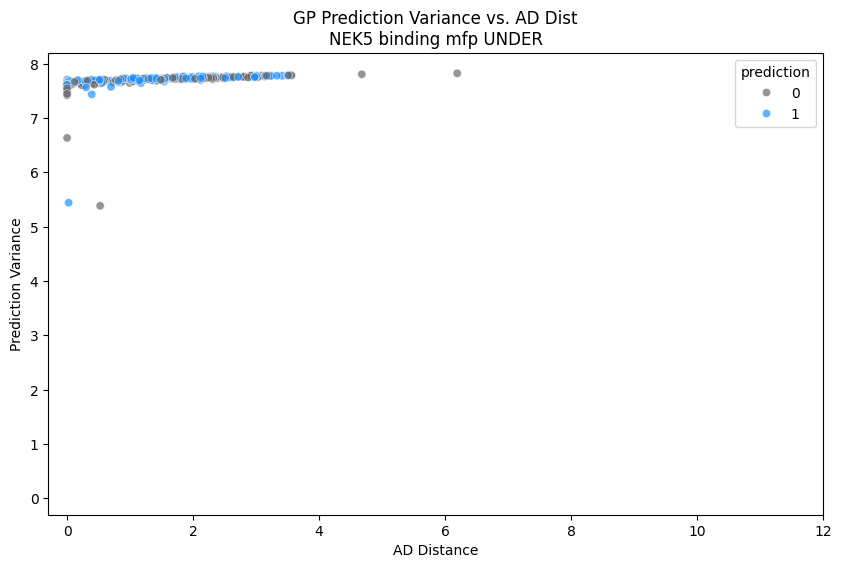

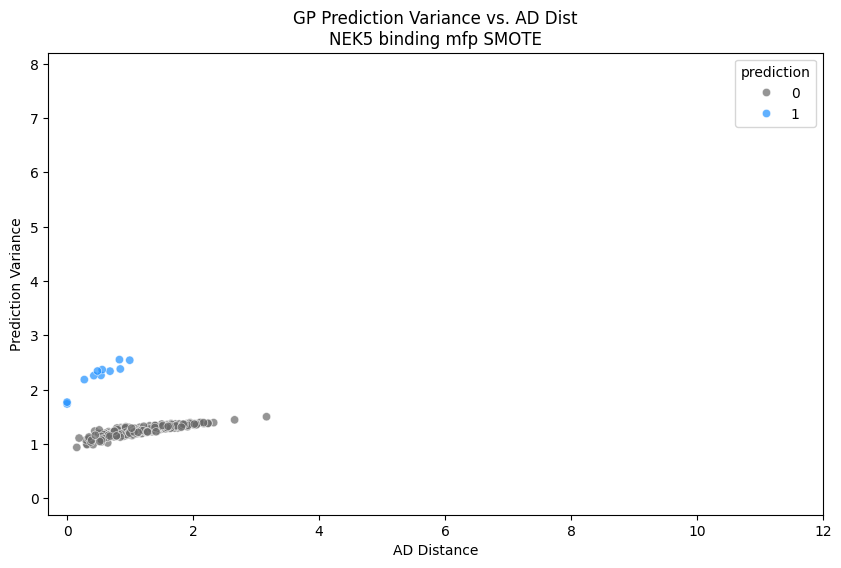

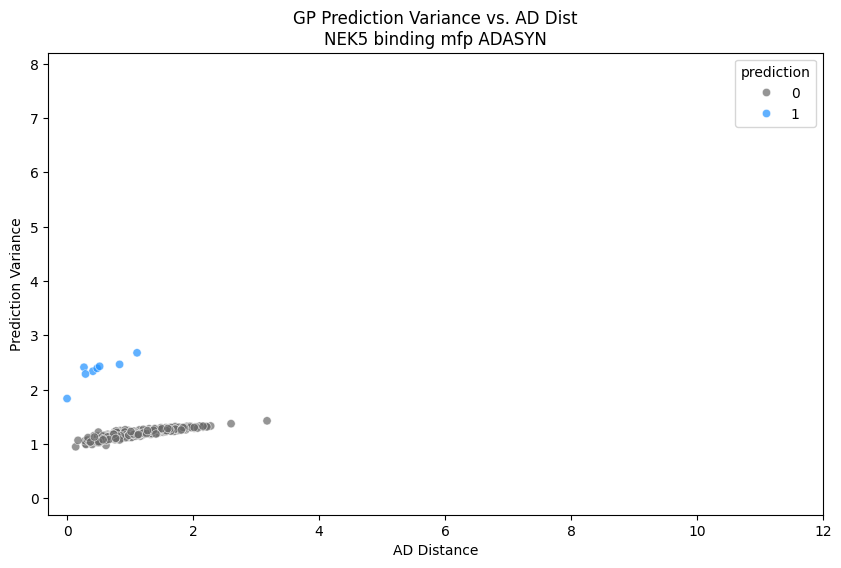

NEK9 binding


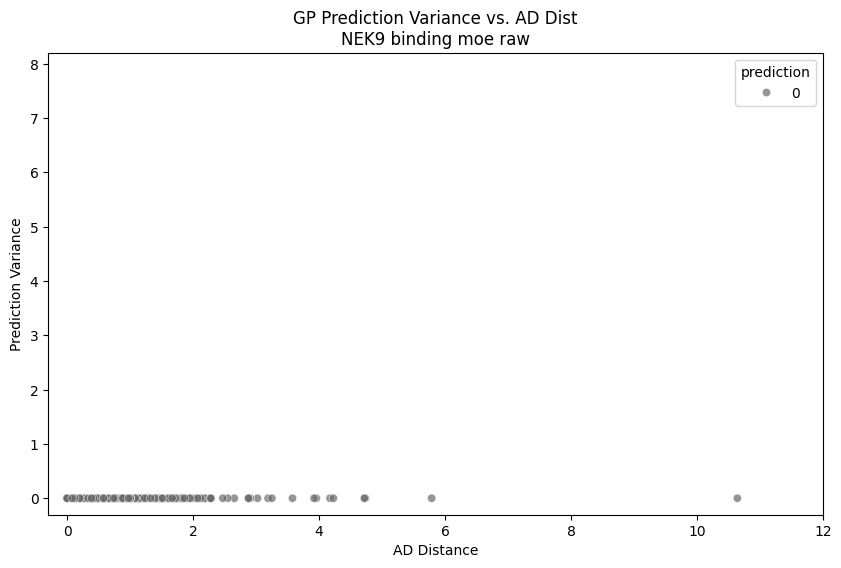

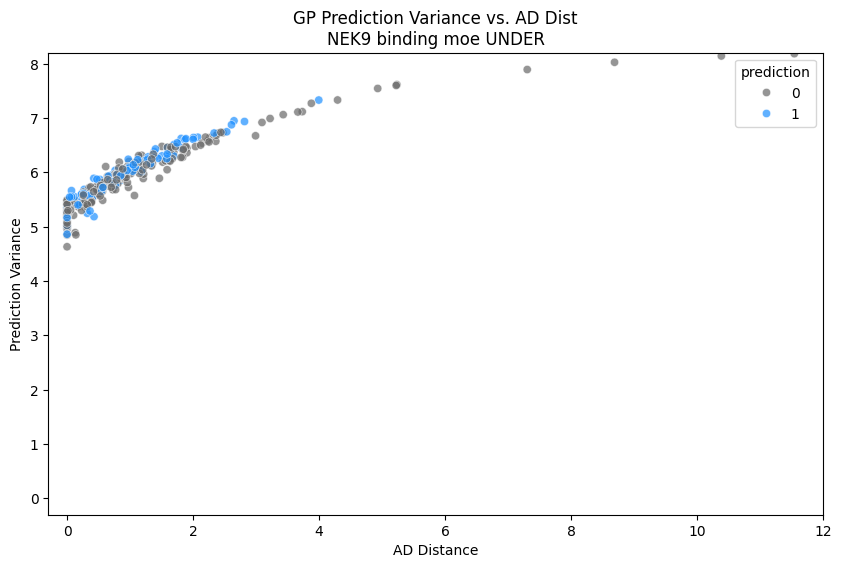

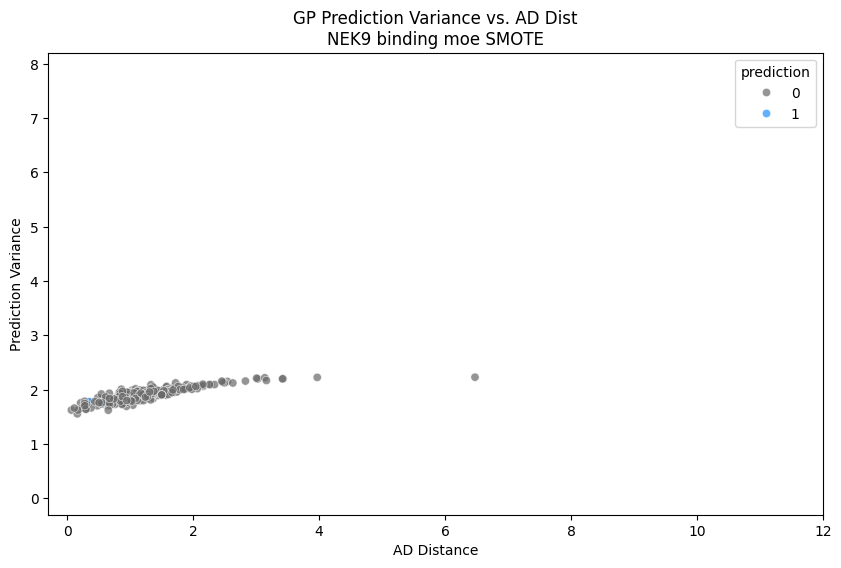

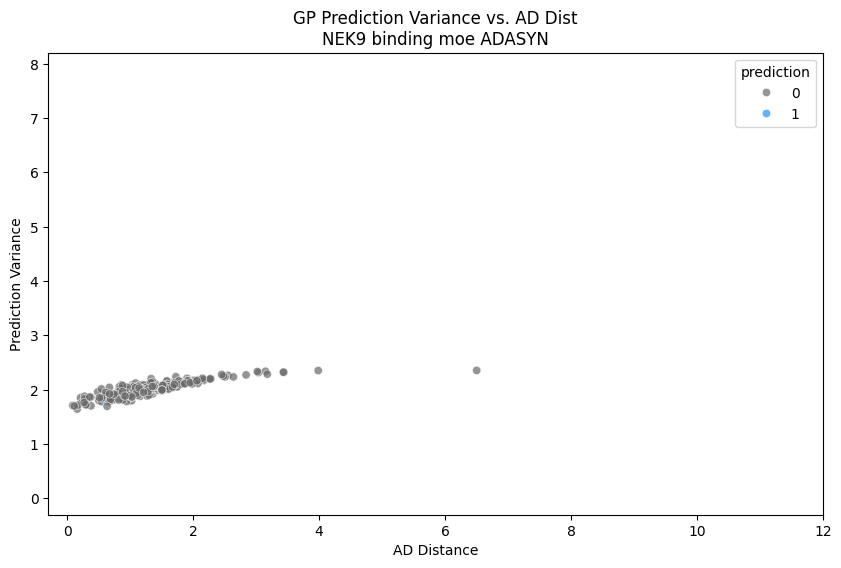

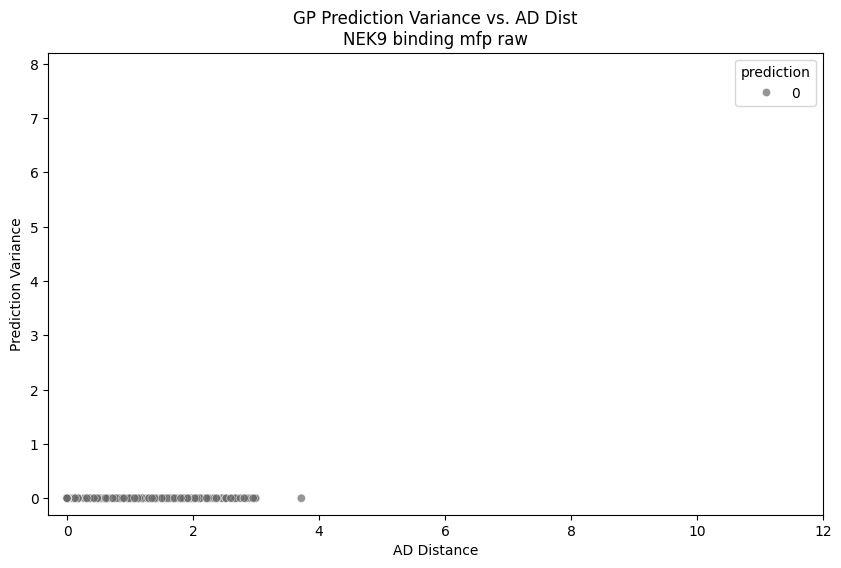

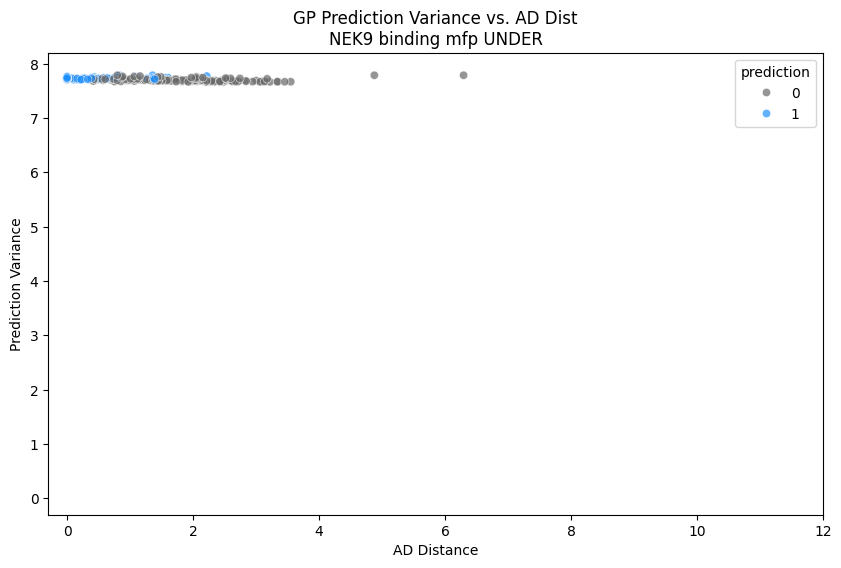

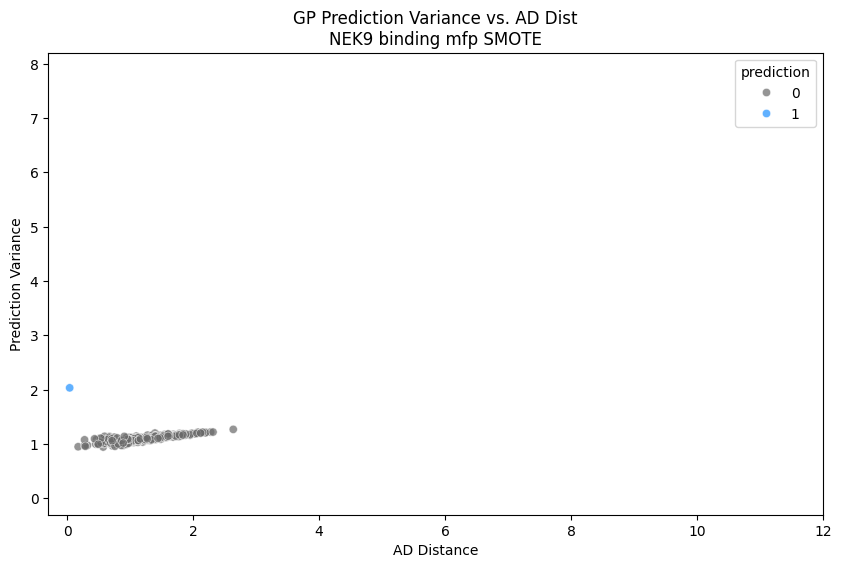

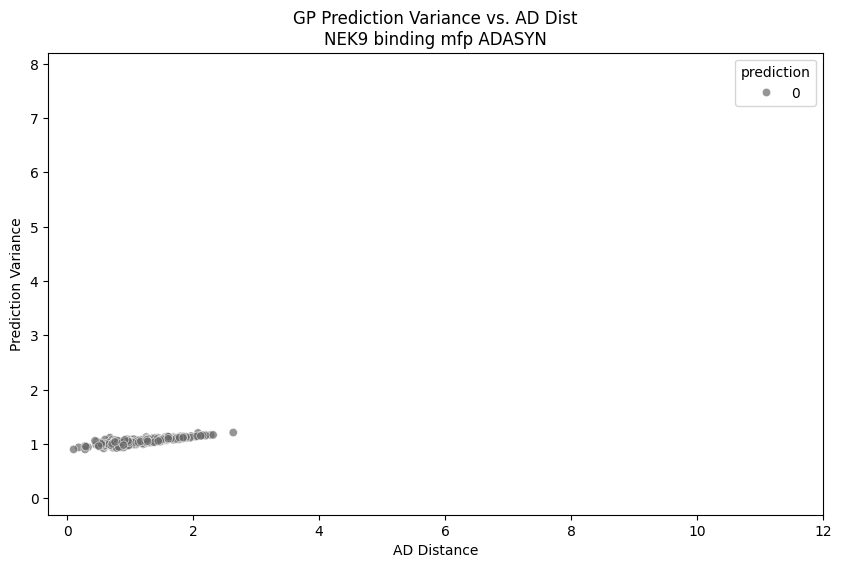

NEK9 inhibition


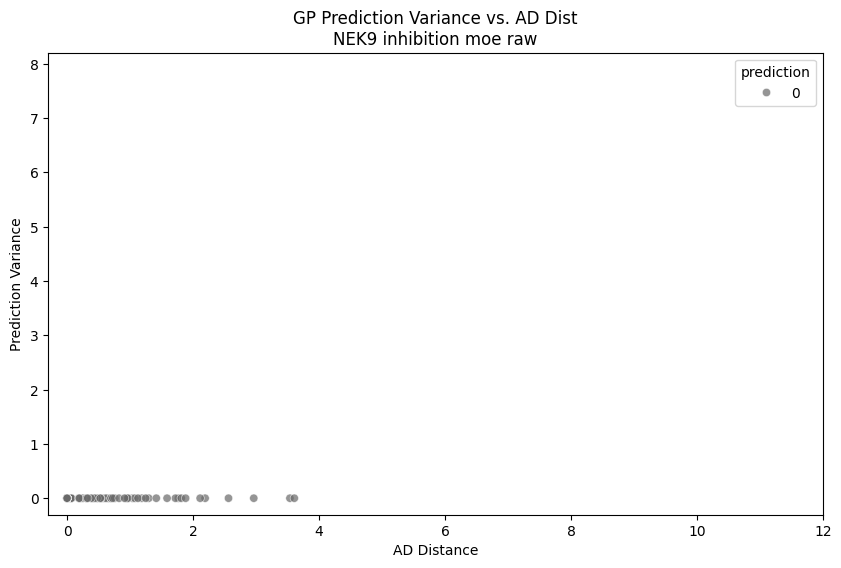

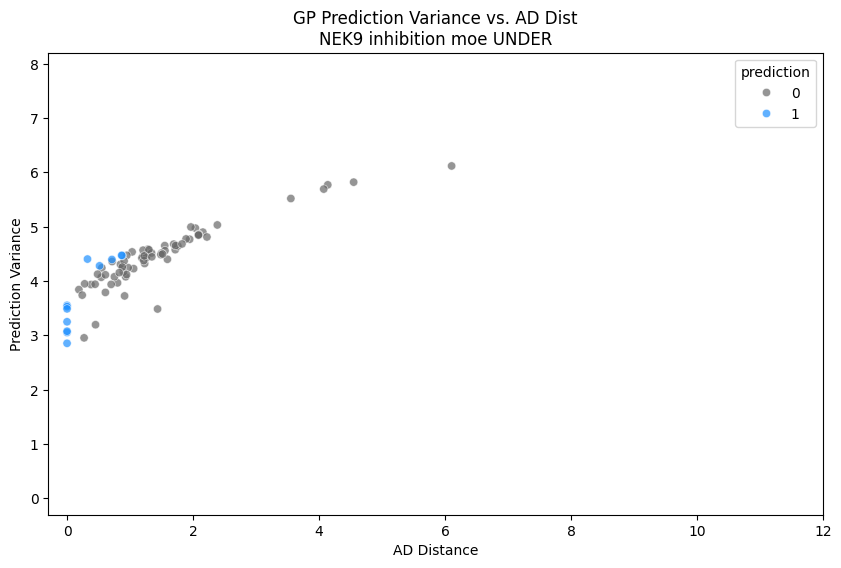

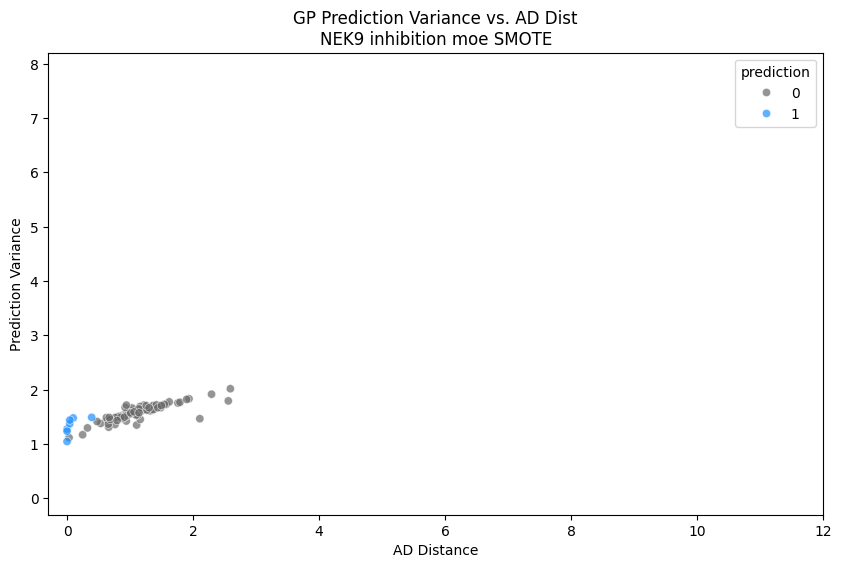

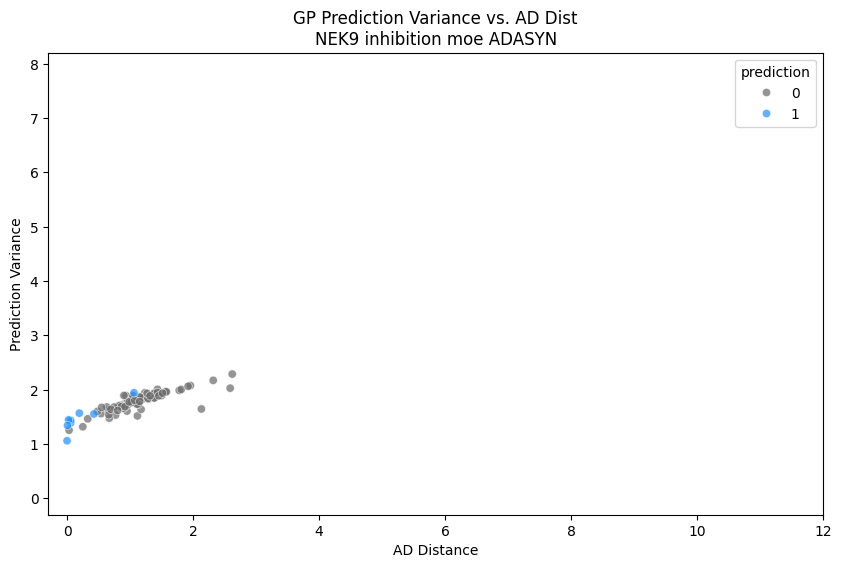

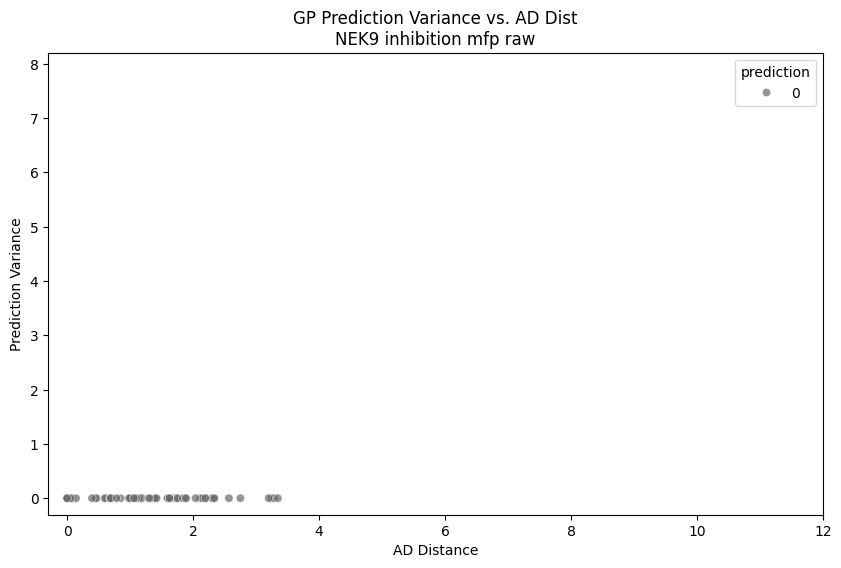

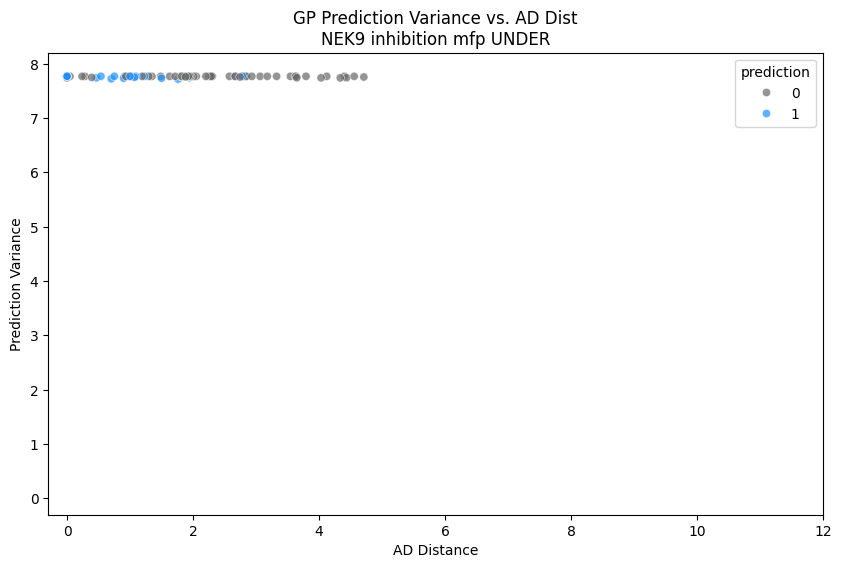

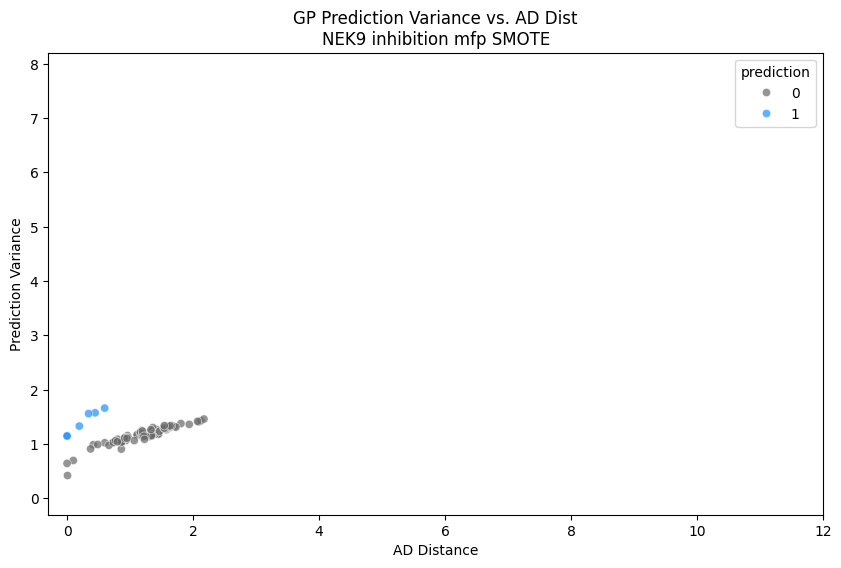

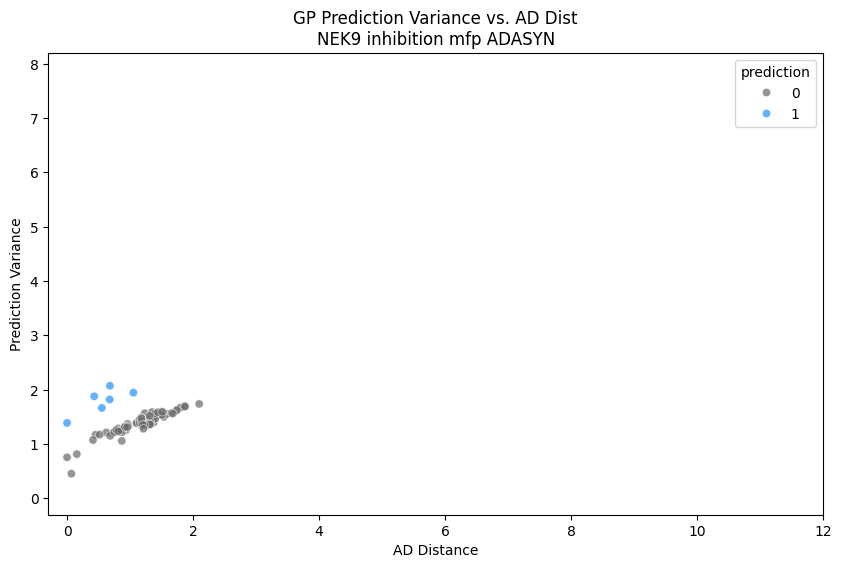

In [149]:
fig_path1 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/individ/'
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        for feat in feat_types: 
            for samp in samplings: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw' 
                figure_name = f'GPvar_AD_dist_scatter_class0or1_actual_NEK{nek}_{bi}_{feat}_{samp}'
                title = f'GP Prediction Variance vs. AD Dist\nNEK{nek} {bi} {feat} {samp}'
                inactive_active_GP_var(df, title, fig_path1, figure_name) 
                samp = 'scaled' 


In [4]:
class_label_dict = {0: 'dimgray', 1:'dodgerblue'} 
def inactive_active_GP_var(df, title=None, figure_path=None, figure_name=None):
    df['variance'] = df.apply(lambda x: x['var0'] if x['prediction'] == 0 else x['var1'], axis=1)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df,x='ADdist', y='variance', hue='prediction', palette=class_label_dict, alpha=0.7)
    plt.xlabel('AD Distance')
    plt.ylabel('Prediction Variance')
    plt.title(title)
    plt.ylim(-0.3,8.2)
    plt.xlim(-0.3,12)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{figure_name}.png')
    plt.show();


In [5]:
def inactive_active_GP_var_moe_mfp(df, title=None, figure_path=None, figure_name=None):
    
    df['variance'] = df.apply(lambda x: x['var0'] if x['prediction'] == 0 else x['var1'], axis=1)
    moe = df[df['feat_type'] == 'moe'] 
    mfp = df[df['feat_type'] == 'mfp']
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    sns.scatterplot(data=moe,x='ADdist', y='variance', hue='prediction', palette=class_label_dict, alpha=0.7 , ax=axs[0])
    sns.scatterplot(data=mfp,x='ADdist', y='variance', hue='prediction', palette=class_label_dict, alpha=0.7 , ax=axs[1])
    axs[0].set_xlabel('AD Distance')
    axs[0].set_ylabel('Prediction Variance')
    axs[0].set_title('moe', fontsize=14)
    axs[1].set_title('mfp', fontsize=14)
    axs[1].set_xlabel('AD Distance')
    axs[1].set_ylabel('Prediction Variance')
    axs[0].set(ylim = (0,8.2))
    axs[0].set(xlim=(0,12)) 
    axs[1].set(ylim = (0,8.2))
    axs[1].set(xlim=(0,12)) 
    plt.suptitle(title, fontsize=18)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{figure_name}.png')
    plt.show();


NEK2 binding


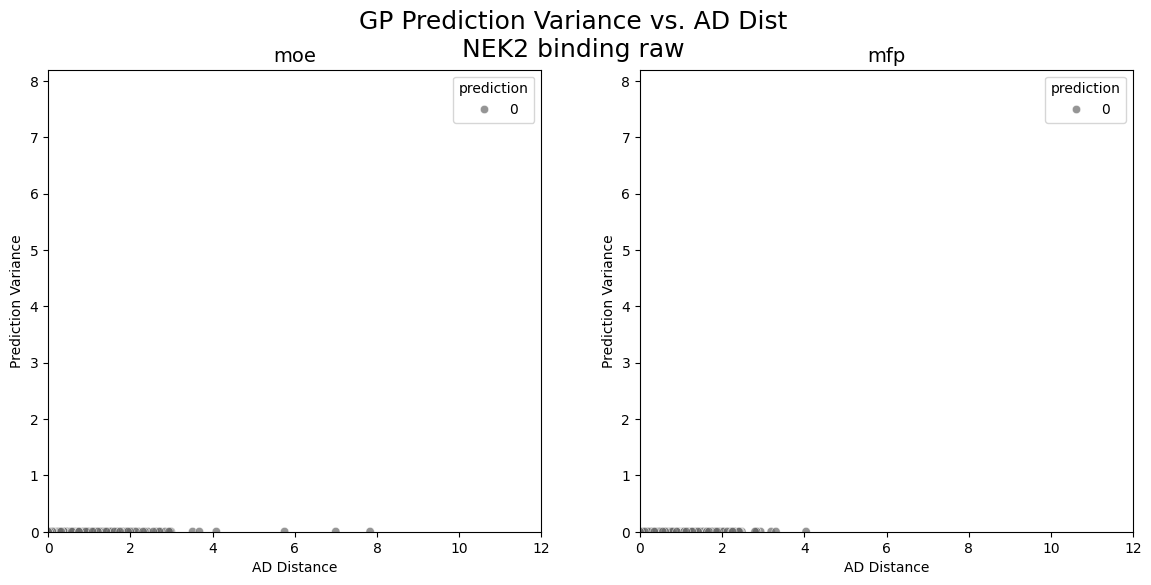

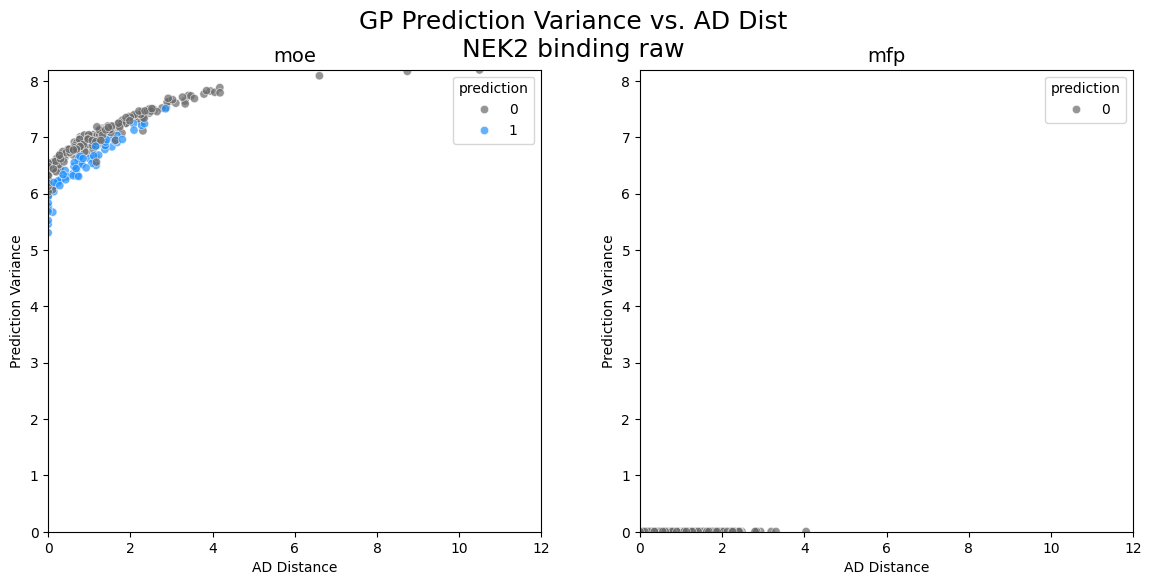

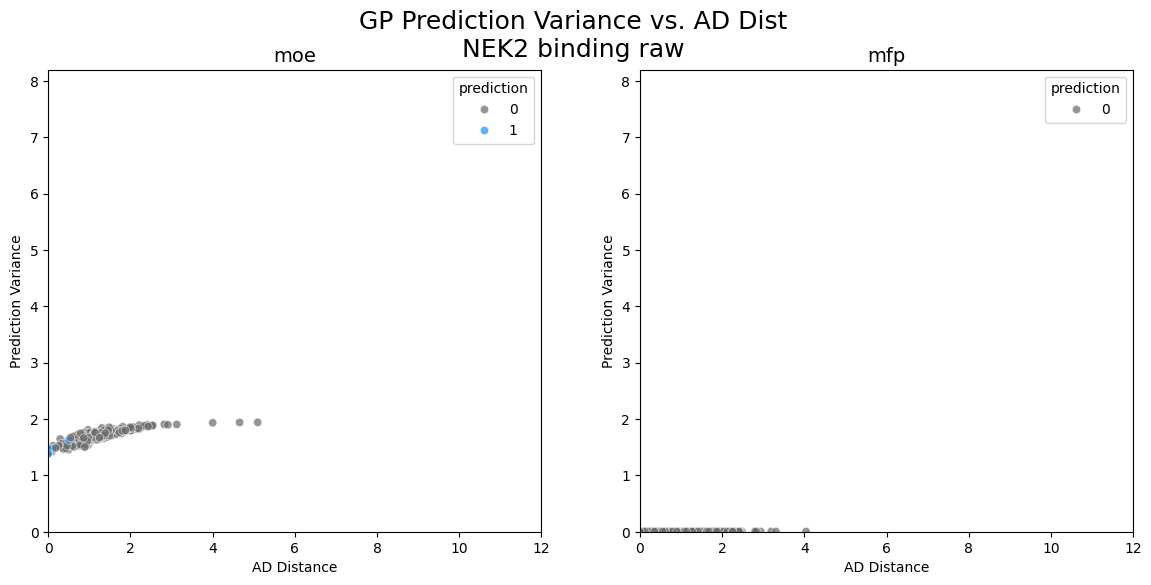

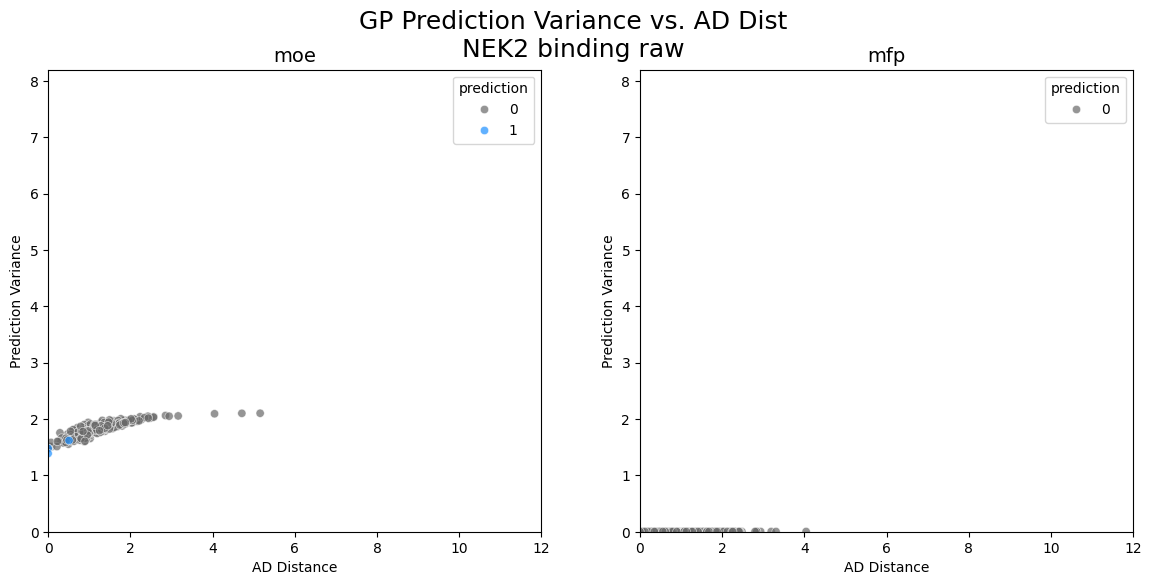

NEK2 inhibition


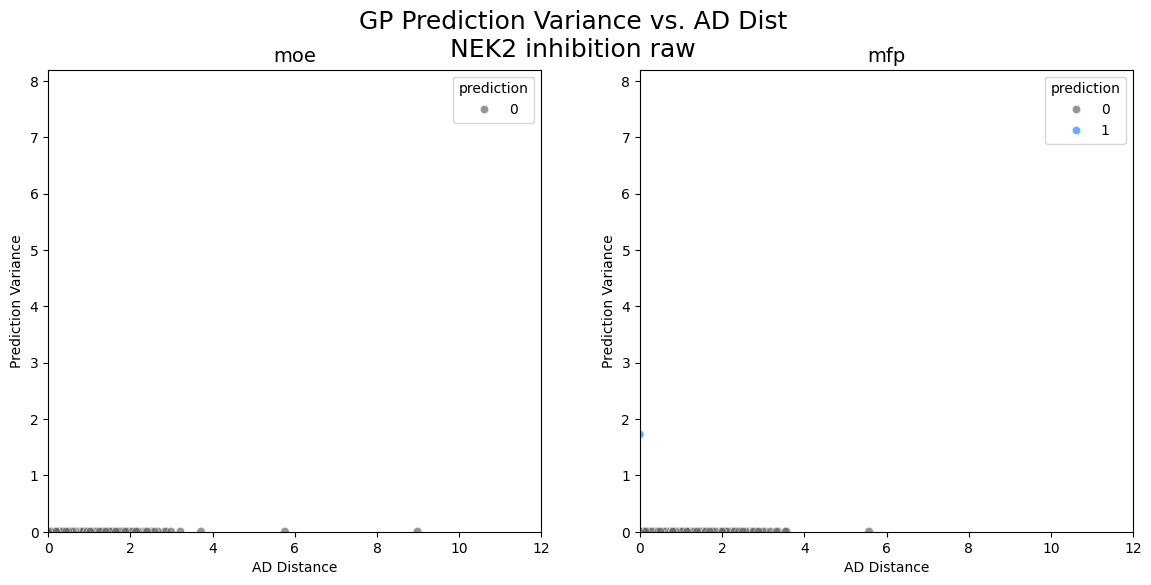

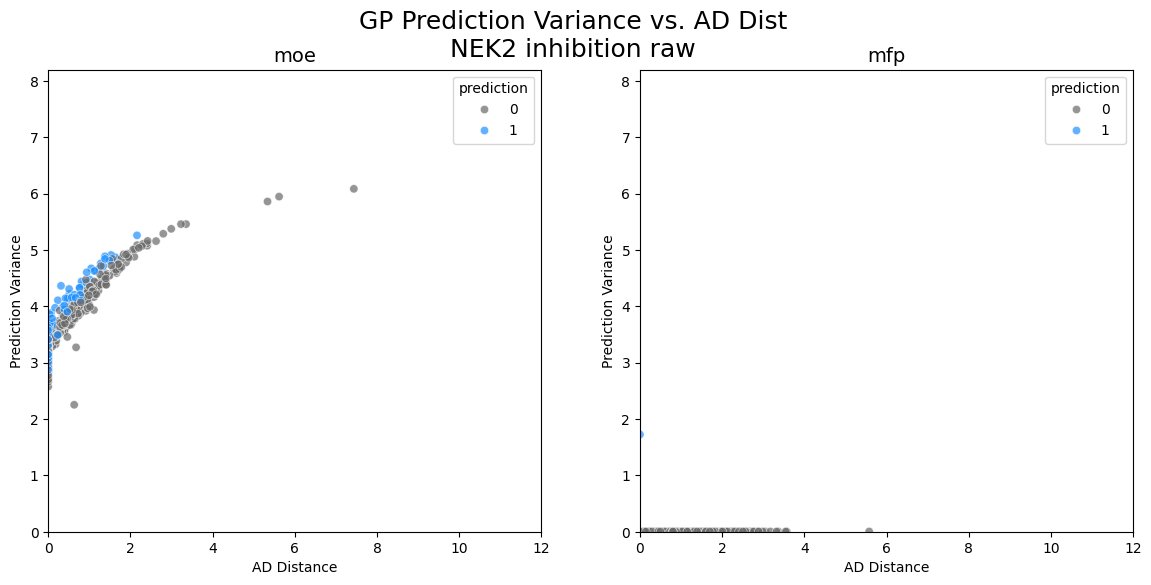

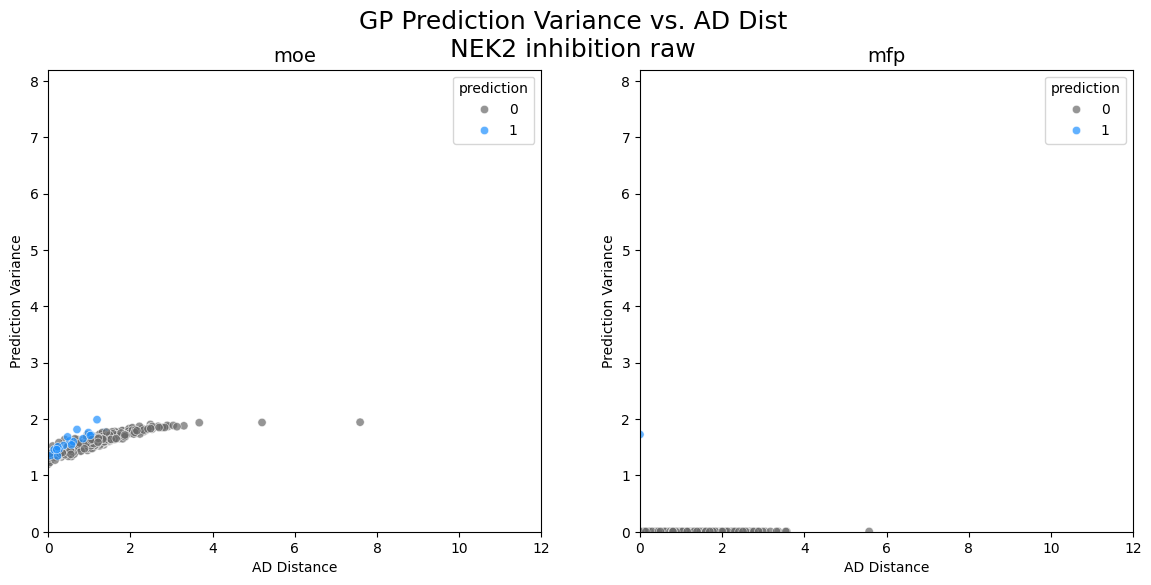

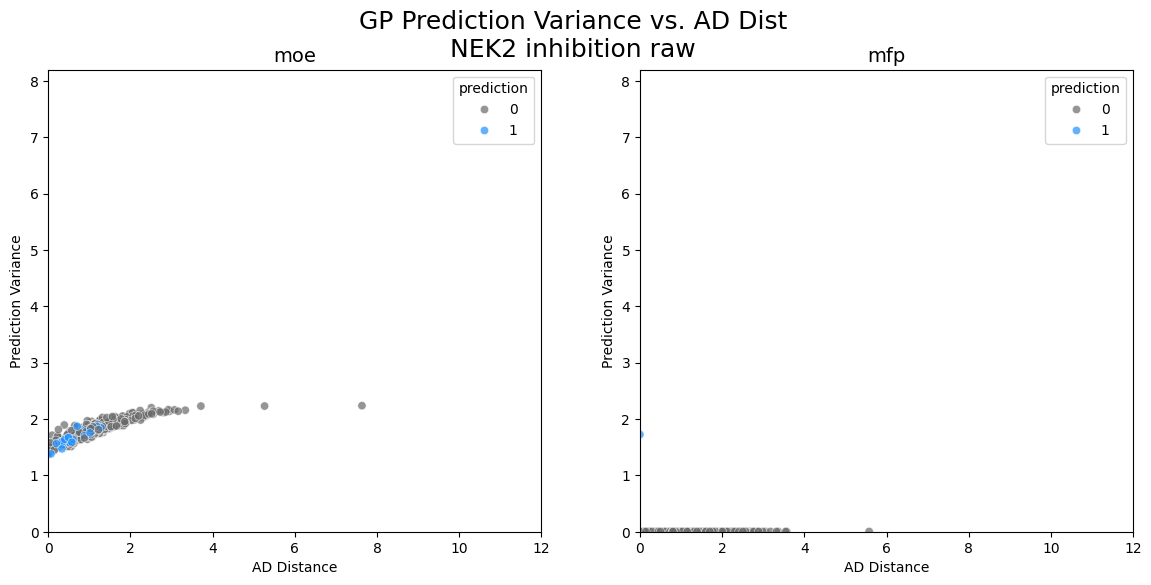

NEK3 binding


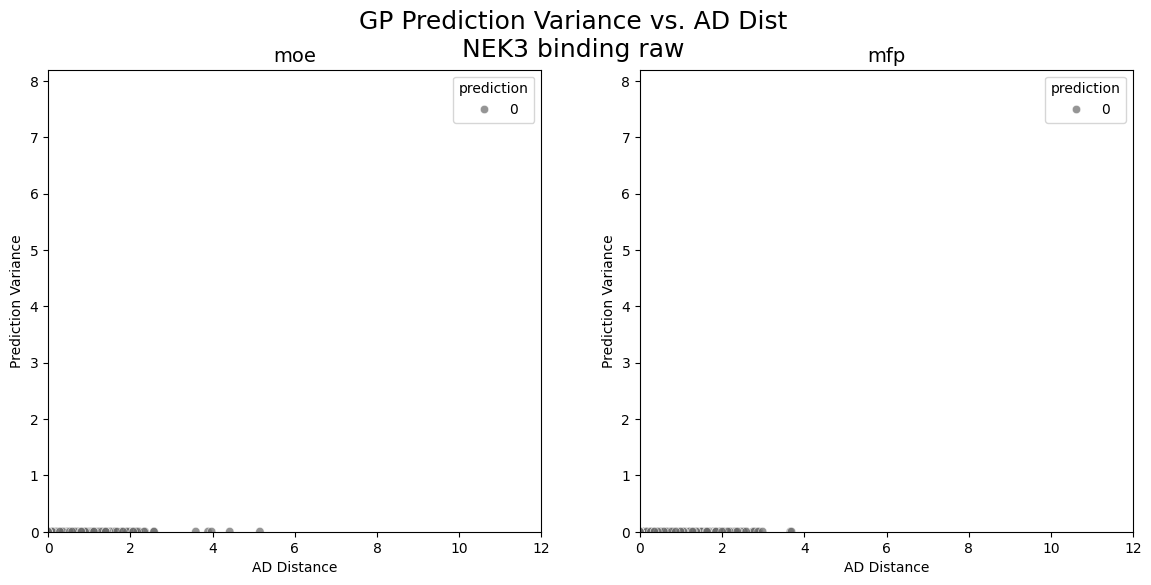

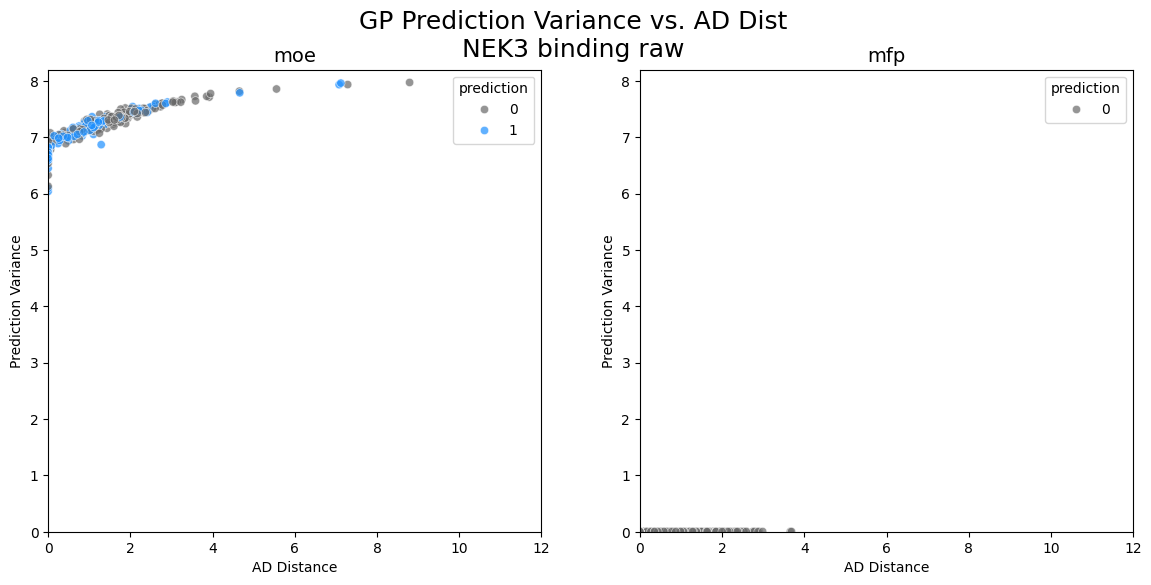

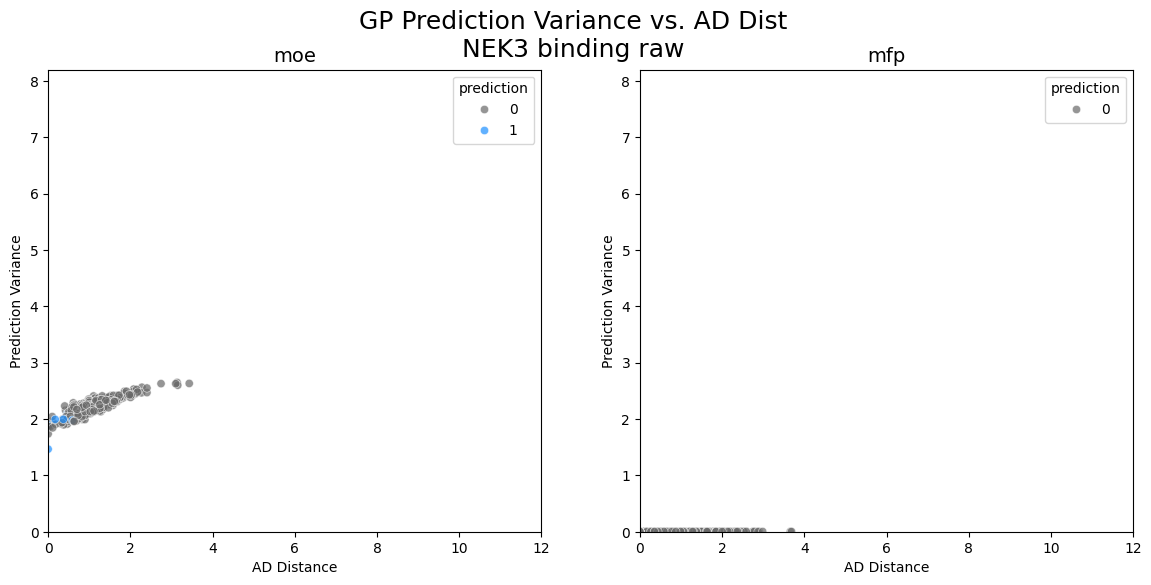

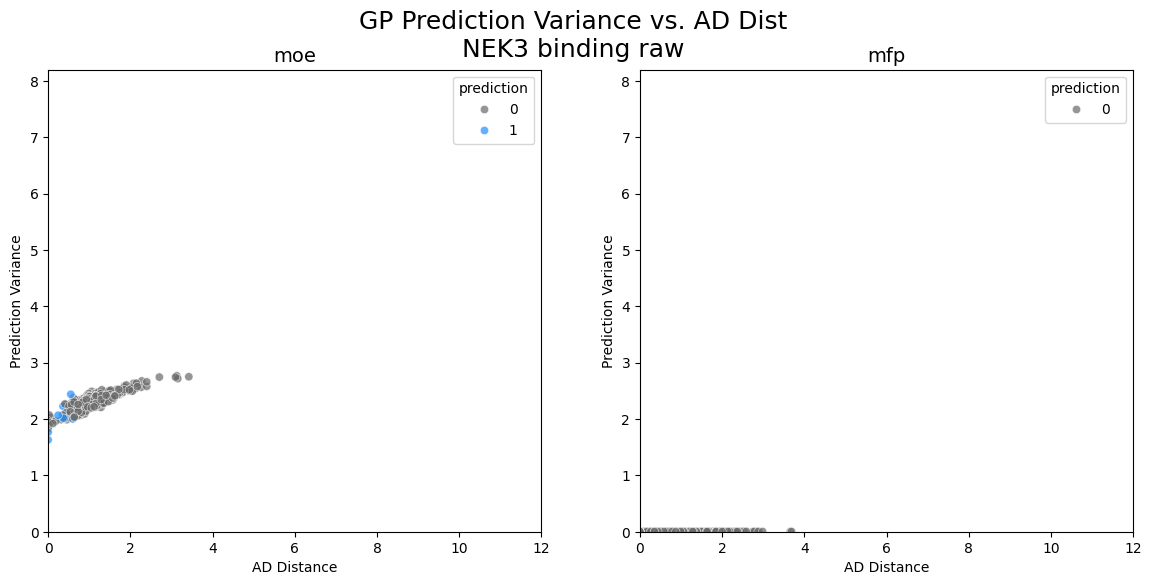

NEK5 binding


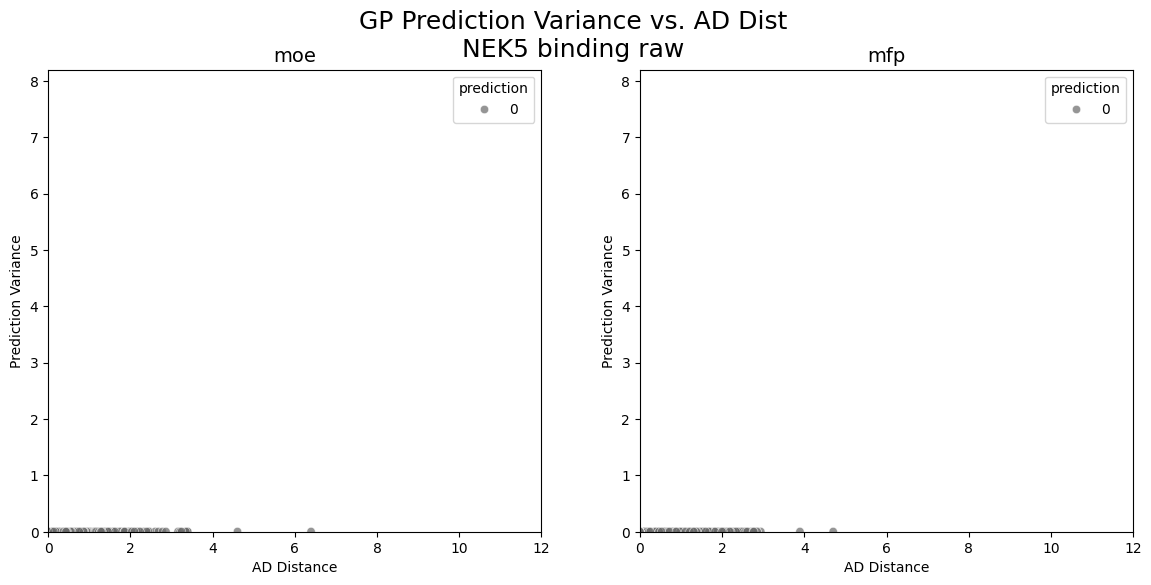

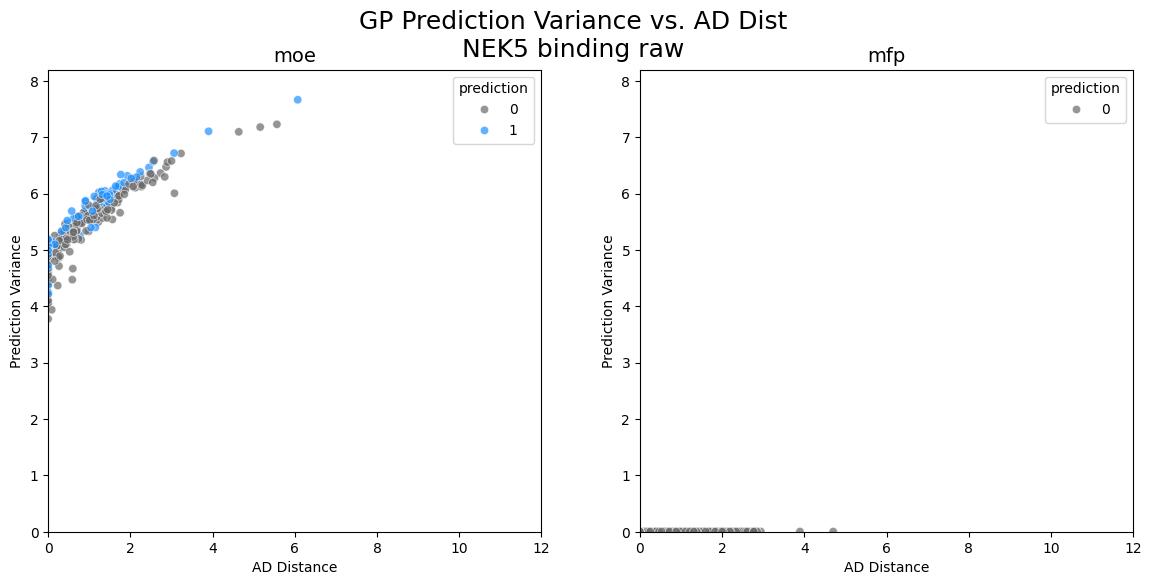

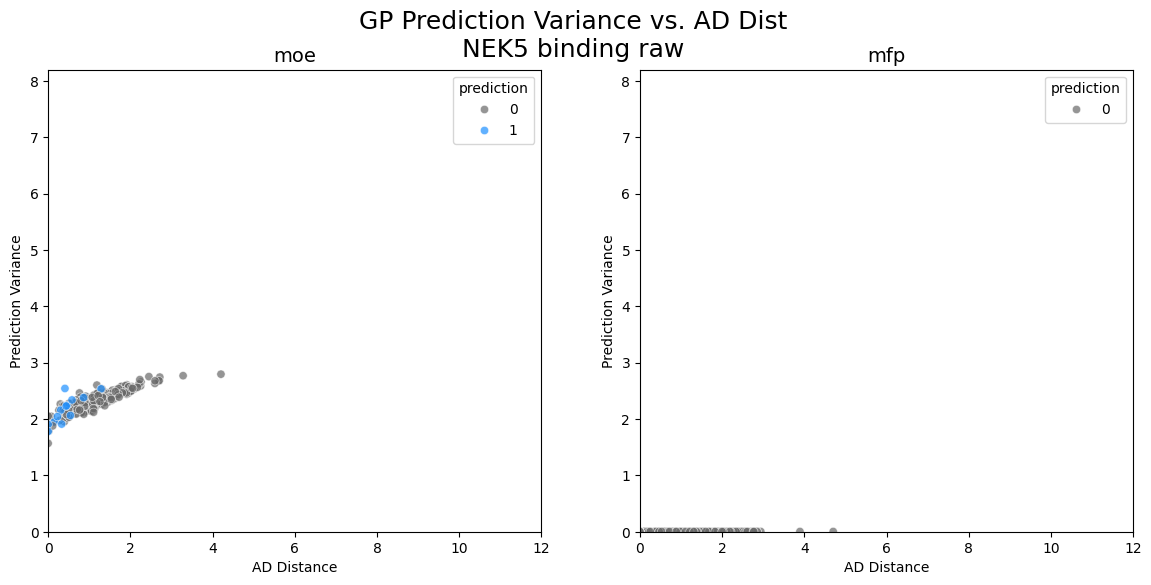

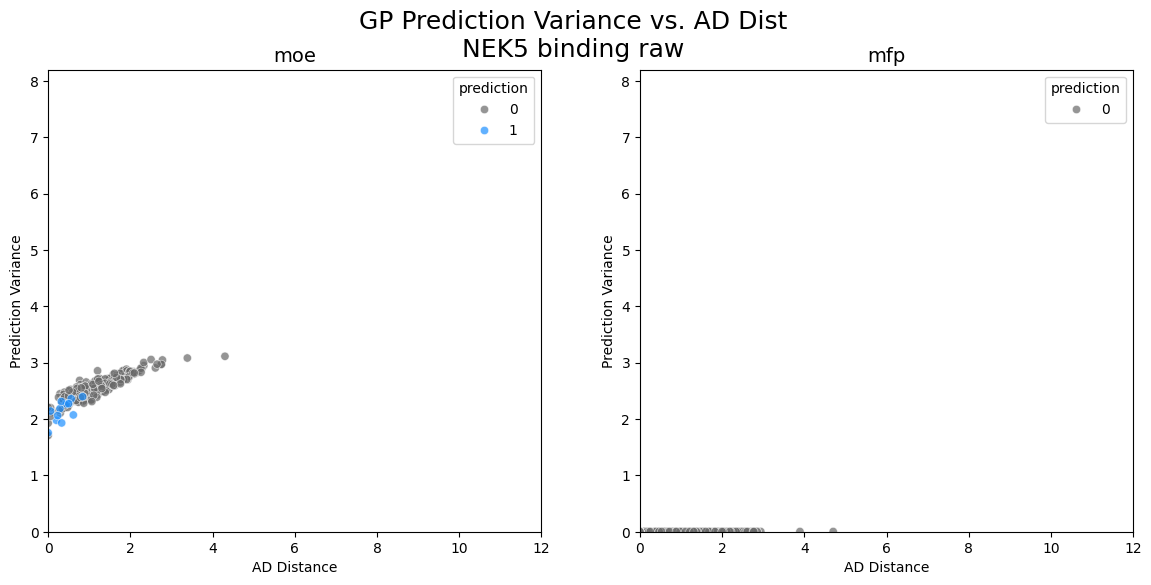

NEK9 binding


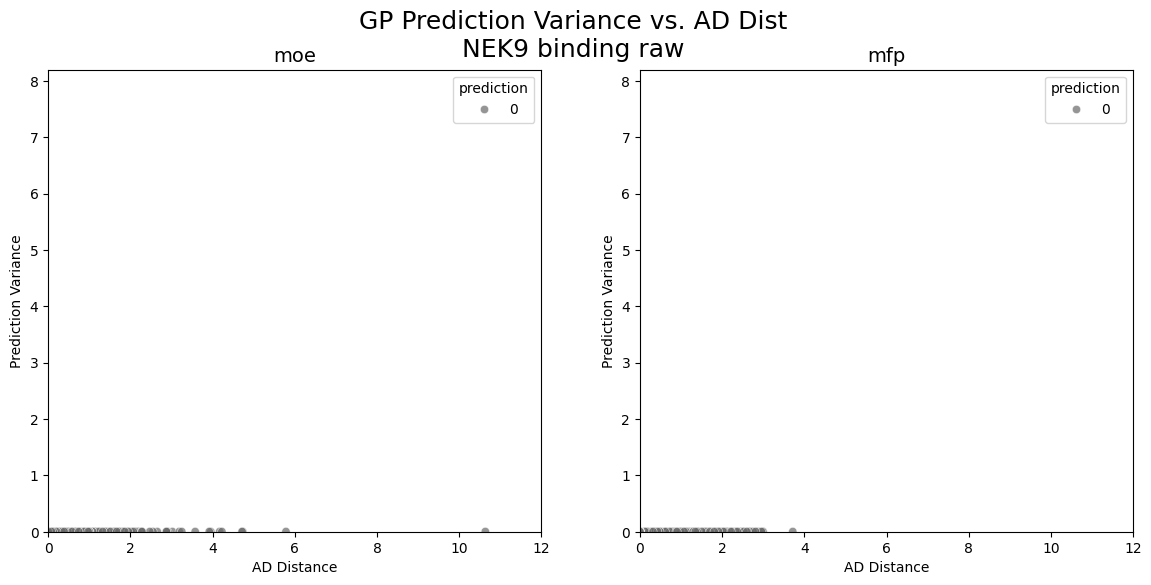

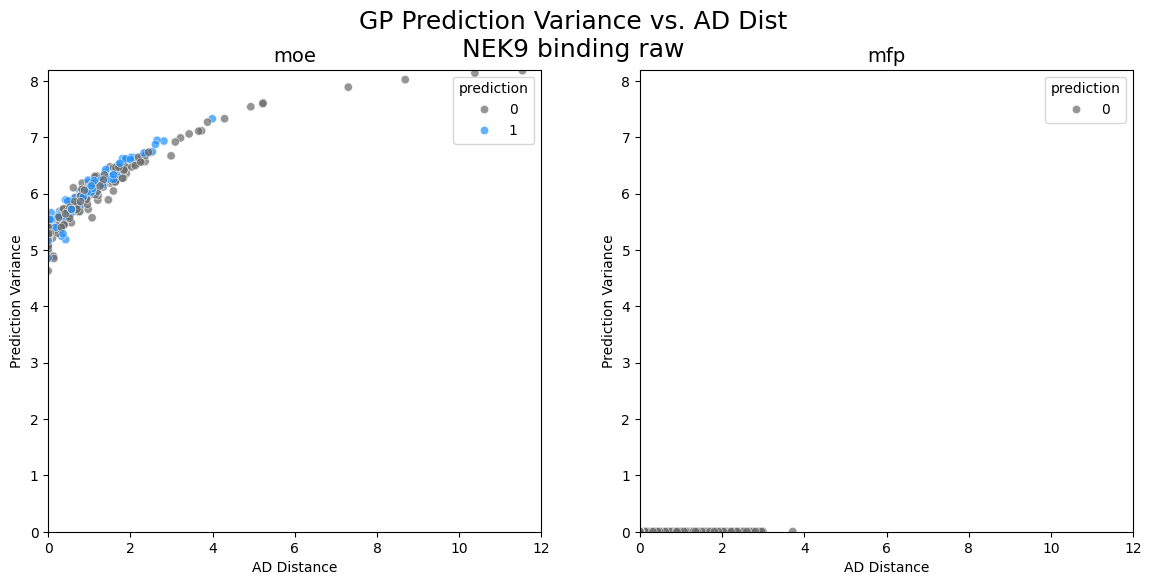

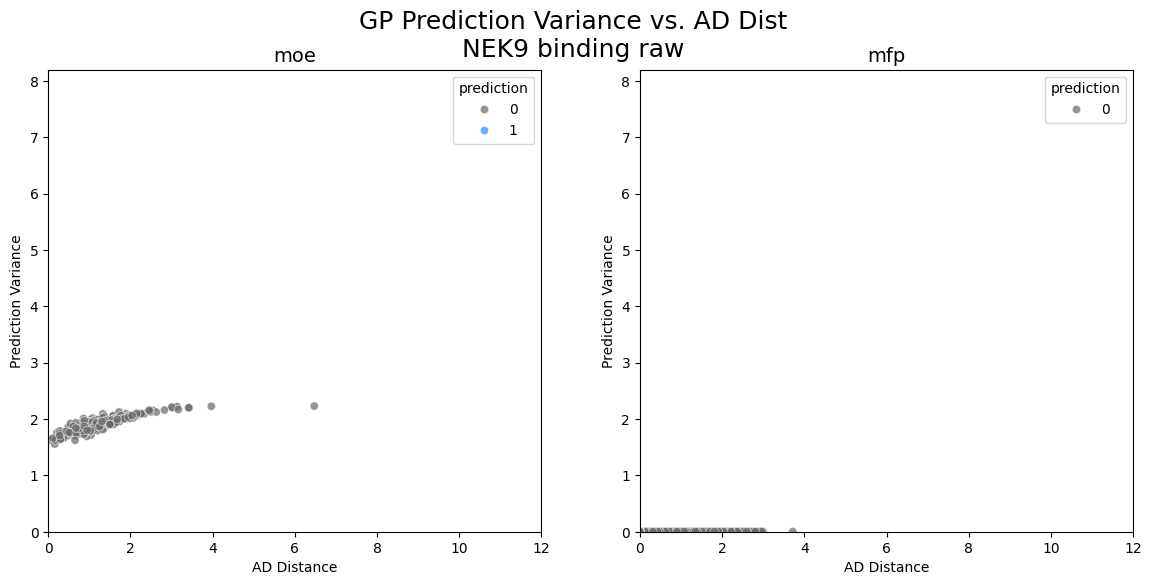

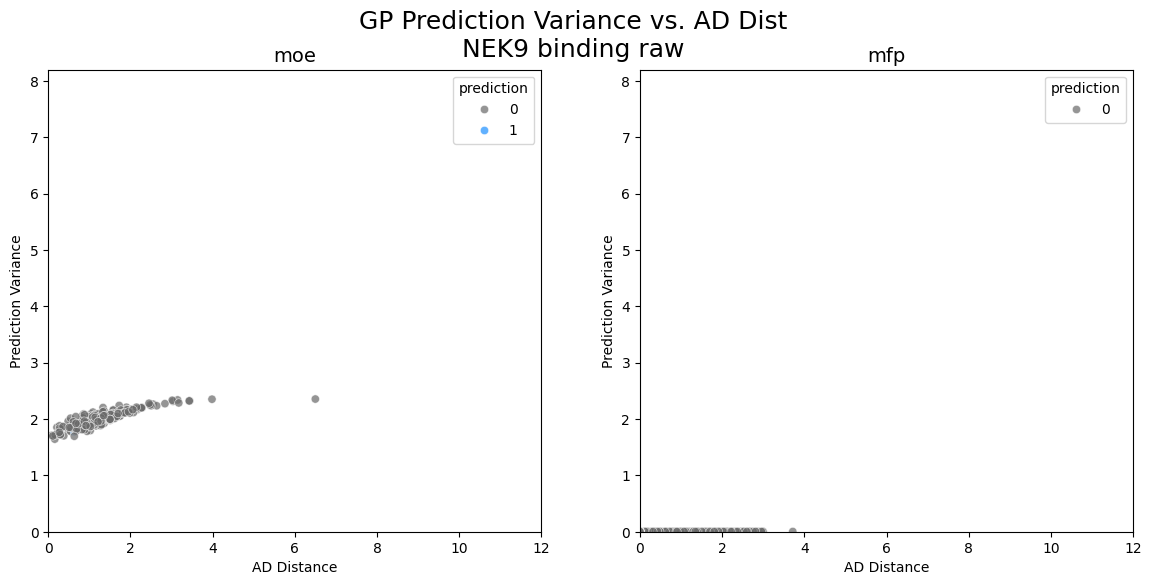

NEK9 inhibition


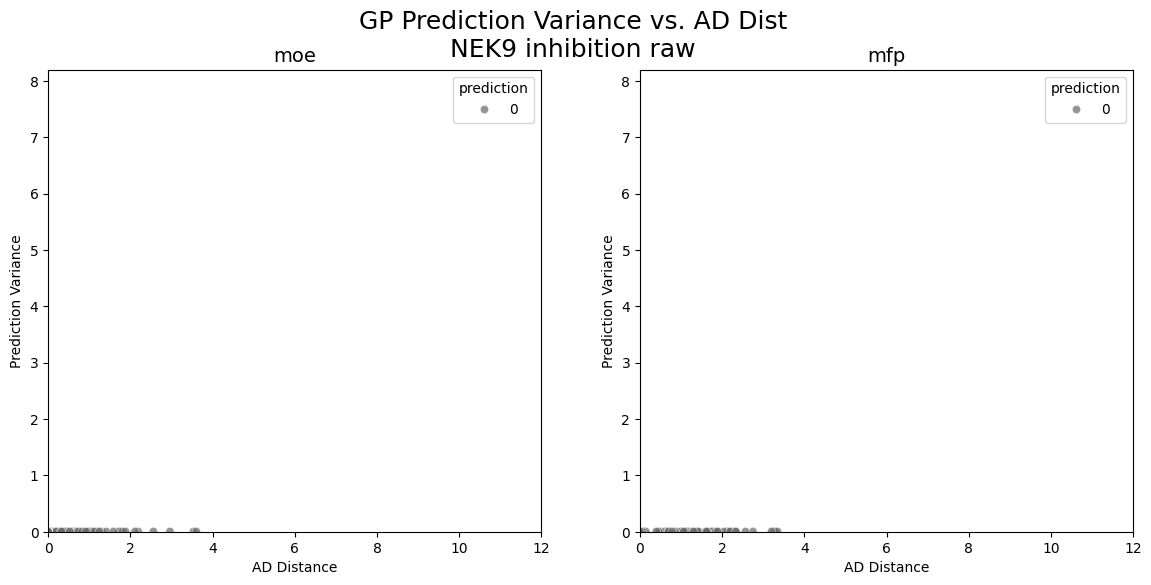

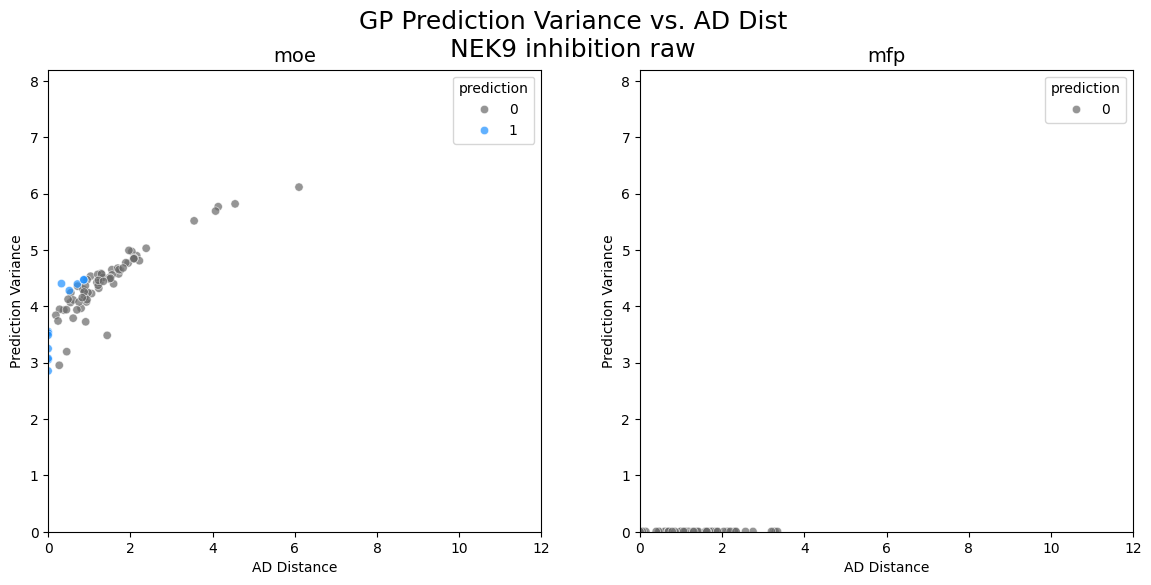

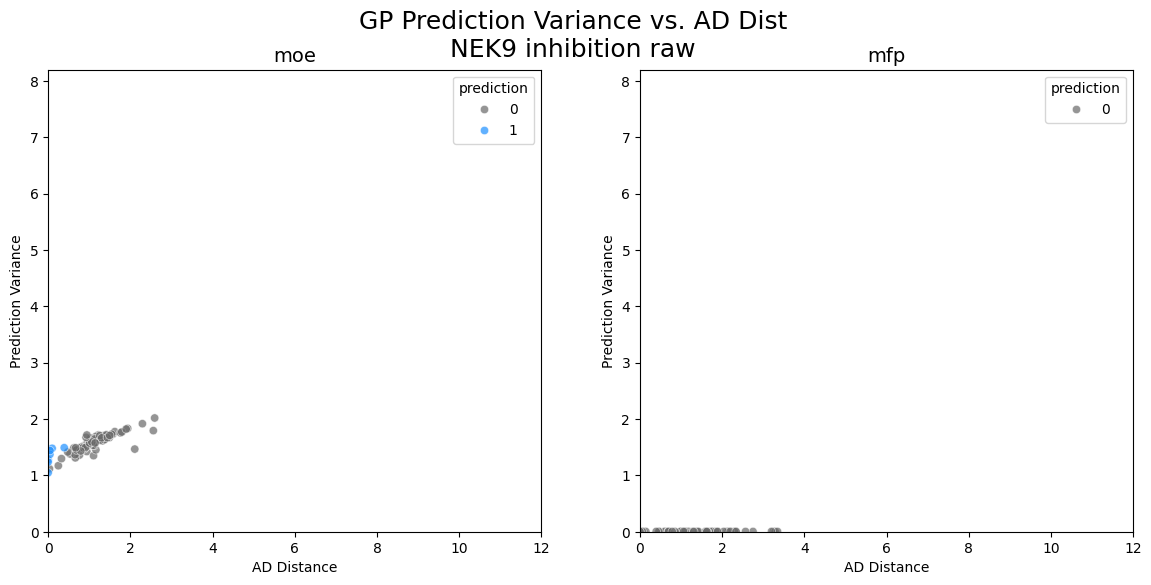

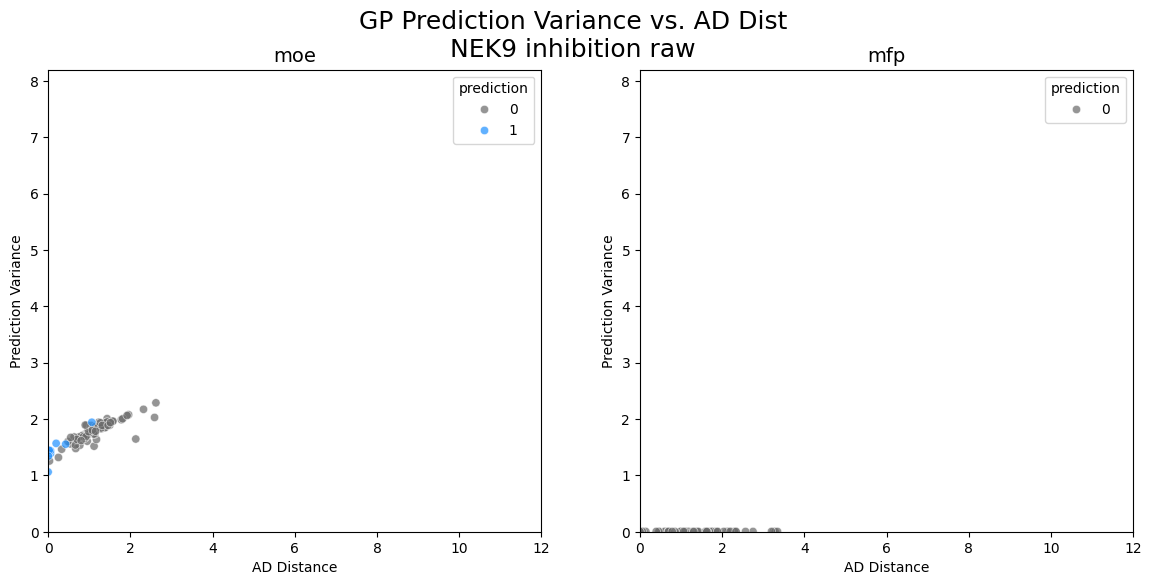

In [152]:
fig_path2 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/moemfp/'
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        
        for samp in samplings: 
            feat_dfs = []
            for feat in feat_types: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist, 
                                 'feat_type': gp_results['feat_type']})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw' 
                feat_dfs.append(df) 
                samp = 'scaled' 
            moemfp = pd.concat([feat_dfs[0], feat_dfs[1]])
            if samp == 'scaled': 
                samp = 'raw' 
            figure_name = f'GPvar_AD_dist_class0or1_actual_NEK{nek}_{bi}_{samp}'
            title = f'GP Prediction Variance vs. AD Dist\nNEK{nek} {bi} {samp}'
            inactive_active_GP_var_moe_mfp(moemfp, title, fig_path2, figure_name) 
            if samp == 'raw': 
                samp = 'scaled' 
            

In [6]:
moe_mfp_dict = {0: 'p', 1: 'd'} 
strategy_colors = {'raw': 'tab:blue', 'UNDER':'tab:orange', 'SMOTE': 'tab:green', 'ADASYN':'tab:red'}
def inactive_active_GP_var_SAMP(dfs, title=None, figure_path=None, figure_name=None):
    
    df_all = pd.concat([df for df in dfs])
    cols = len(dfs) 
    rows = 2 
    df_all['variance'] = df_all.apply(lambda x: x['var0'] if x['prediction'] == 0 else x['var1'], axis=1)
    moe = df_all[df_all['feat_type'] == 'moe'] 
    mfp = df_all[df_all['feat_type'] == 'mfp']

    print(f'moe: {moe.shape}, mfp: {mfp.shape}')
    print(f'mfp: {mfp["strategy"].unique()}')
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    sns.scatterplot(data=moe,x='ADdist', y='variance', hue='strategy', palette=strategy_colors, 
                    style='actual', markers=moe_mfp_dict, alpha=0.7 , ax=axs[0], s=125)
    sns.scatterplot(data=mfp,x='ADdist', y='variance', hue='strategy', palette=strategy_colors, 
                    style='actual', markers=moe_mfp_dict, alpha=0.7 , ax=axs[1], s=125)
    axs[0].set_xlabel('AD Distance')
    axs[0].set_ylabel('Prediction Variance')
    axs[1].set_xlabel('AD Distance')
    axs[1].set_ylabel('Prediction Variance')
    axs[0].set_title('moe', fontsize=14)
    axs[1].set_title('mfp', fontsize=14)
    axs[0].set(ylim = (0,8.2))
    axs[0].set(xlim=(0,12)) 
    axs[1].set(ylim = (0,8.2))
    axs[1].set(xlim=(0,12)) 
    plt.suptitle(title, fontsize=18)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{figure_name}.png')
    plt.show();


NEK2 binding
moe: (1132, 9), mfp: (1132, 9)
mfp: ['raw' 'UNDER' 'SMOTE' 'ADASYN']


KeyboardInterrupt: 

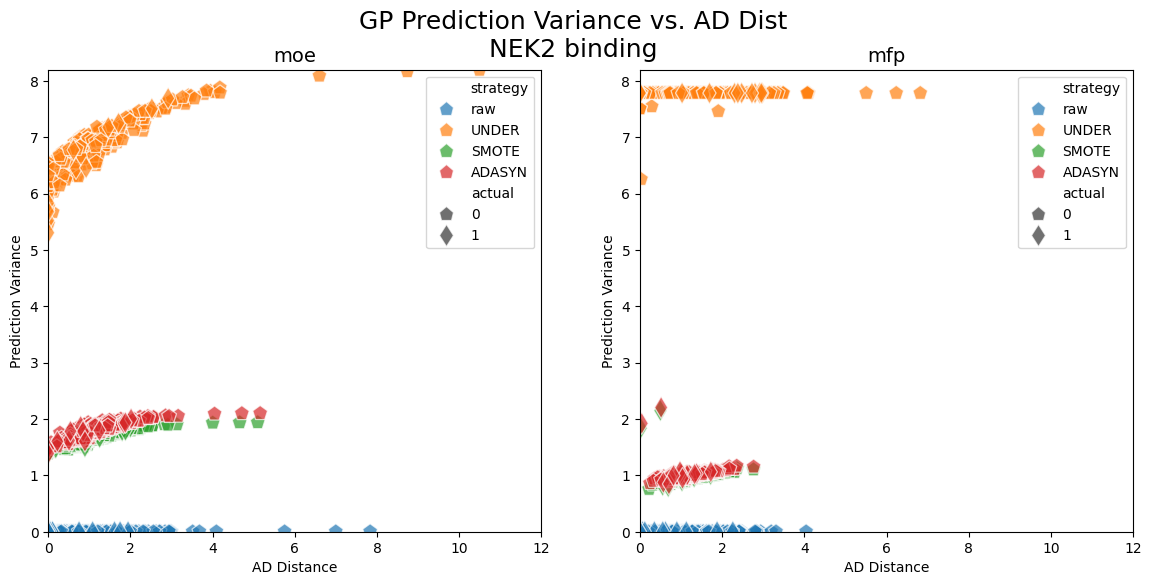

In [7]:
fig_path3 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/samp/'
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        df_list = [] 
        for samp in samplings: 
            for feat in feat_types: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist, 
                                 'feat_type': gp_results['feat_type'], 'strategy': gp_results['strategy']})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw'
                
                df_list.append(df)
                if samp == 'raw': 
                    samp = 'scaled' 
        figure_name = f'GPvar_AD_dist_class0or1_actual_NEK{nek}_{bi}'
        title = f'GP Prediction Variance vs. AD Dist\nNEK{nek} {bi}'
        inactive_active_GP_var_SAMP(df_list, title, fig_path3, figure_name) 
        
            

In [8]:

def inactive_active_GP_var_moemfp_subplots(dfs, title=None, figure_path=None, figure_name=None):
    df_all = pd.concat([df for df in dfs])
    cols = df_all['strategy'].nunique()
    rows = 2 
    df_all['variance'] = df_all.apply(lambda x: x['var0'] if x['prediction'] == 0 else x['var1'], axis=1)
    

    fig, axs = plt.subplots(rows,cols, figsize=(16, 9), sharey=False)
    for i,samp in enumerate(df_all['strategy'].unique()): 
        this_df = df_all[df_all['strategy'] == samp] 
        moe = this_df[this_df['feat_type'] == 'moe'] 
        mfp = this_df[this_df['feat_type'] == 'mfp']
        
        sns.scatterplot(data=moe,x='ADdist', y='variance', hue='prediction', palette=class_label_dict , 
                    alpha=0.7 , ax=axs[0,i], s=75)
        sns.scatterplot(data=mfp,x='ADdist', y='variance', hue='prediction', palette=class_label_dict, 
                        alpha=0.7 , ax=axs[1,i], s=75)
        if i == 0:
            axs[0,i].set_ylabel('Prediction Variance')
            axs[1,i].set_ylabel('Prediction Variance')
            
        axs[0,i].set_xlabel('AD Distance')
        axs[0, i].set_title(f'MOE {samp}')
        axs[1, i].set_title(f'MFP {samp}')
        axs[0,i].set(ylim=(-0.6, 8.2)) 
        axs[1,i].set(ylim=(-0.6, 8.2)) 
        axs[0,i].set(xlim=(-0.6, 12))
        axs[1,i].set(xlim=(-0.6, 12))
        axs[0,i].legend().remove()
        axs[1,i].legend().remove()

    handles, labels = axs[1, 1].get_legend_handles_labels()

    fig.legend(handles, labels, bbox_to_anchor = [0.54, 0] )
    plt.tight_layout() 
  
    plt.suptitle(title, fontsize=18,y=1.03)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{figure_name}.png',bbox_inches='tight')
    plt.show();


NEK2 binding


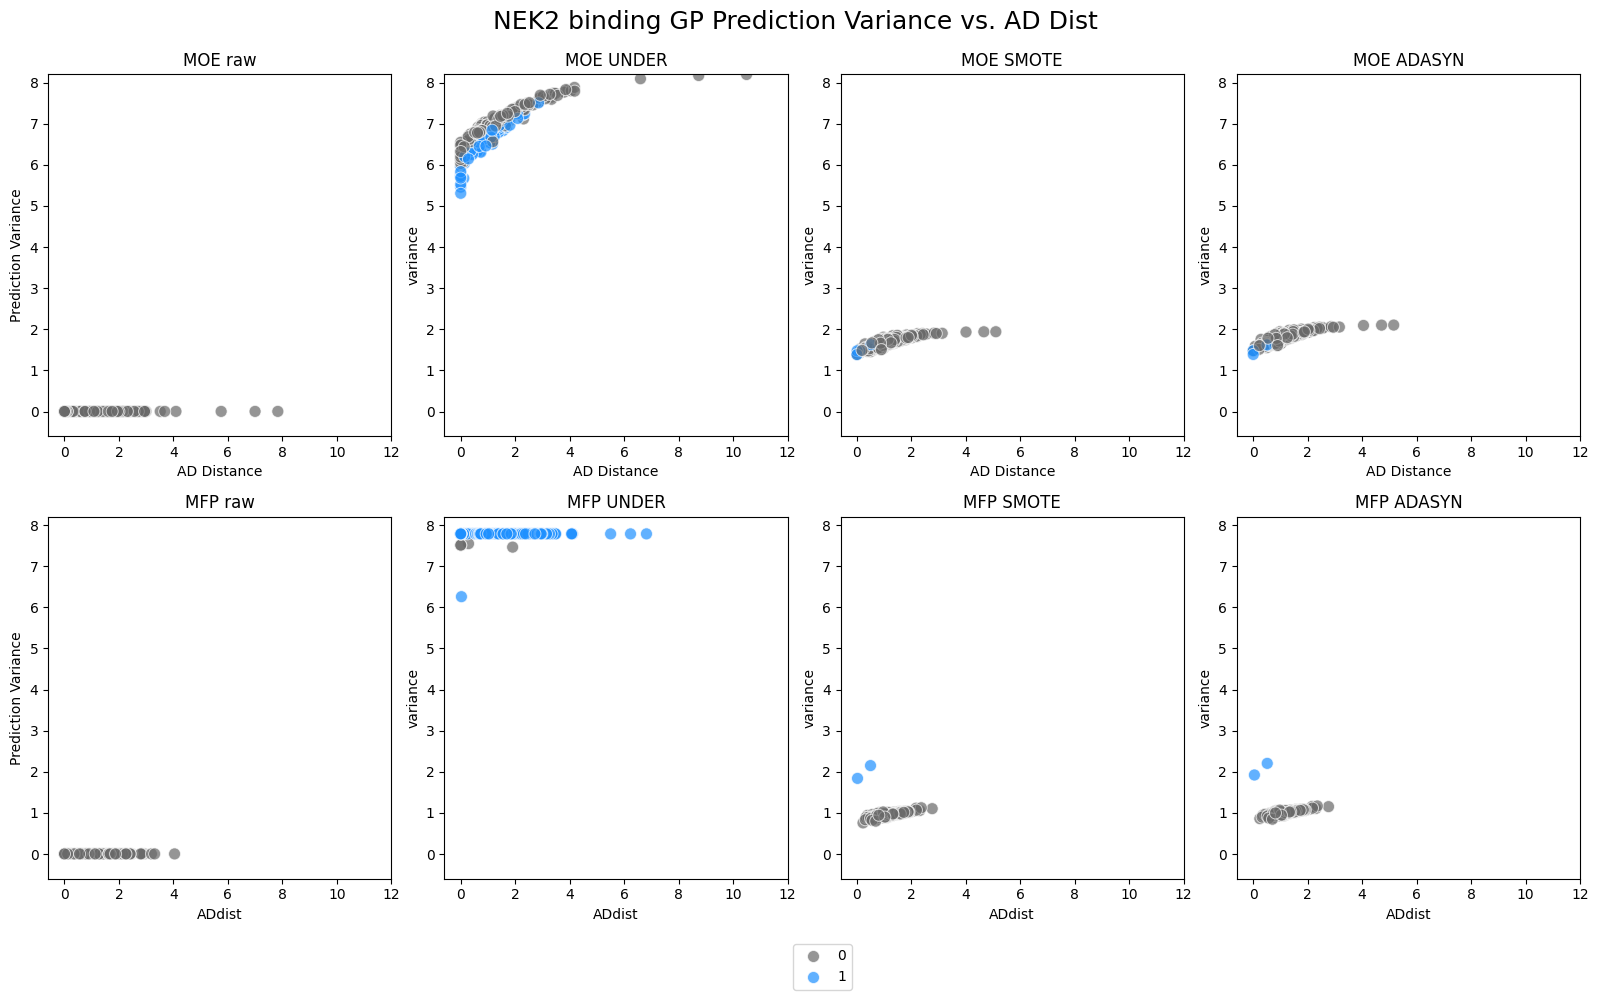

NEK2 inhibition


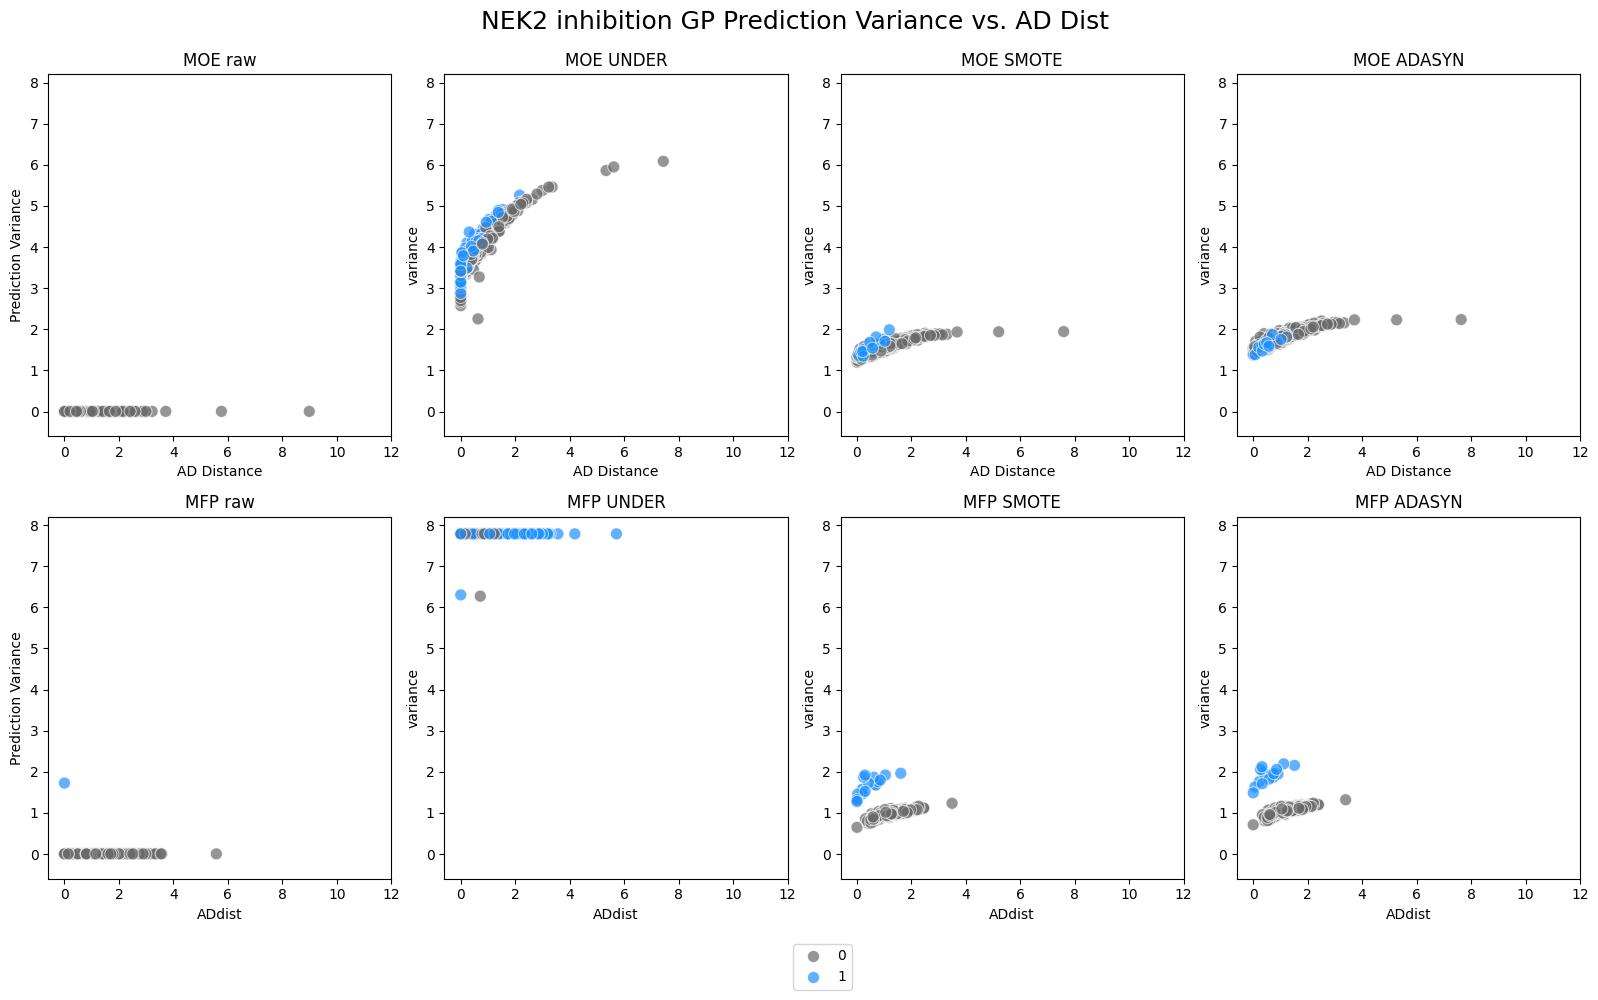

NEK3 binding


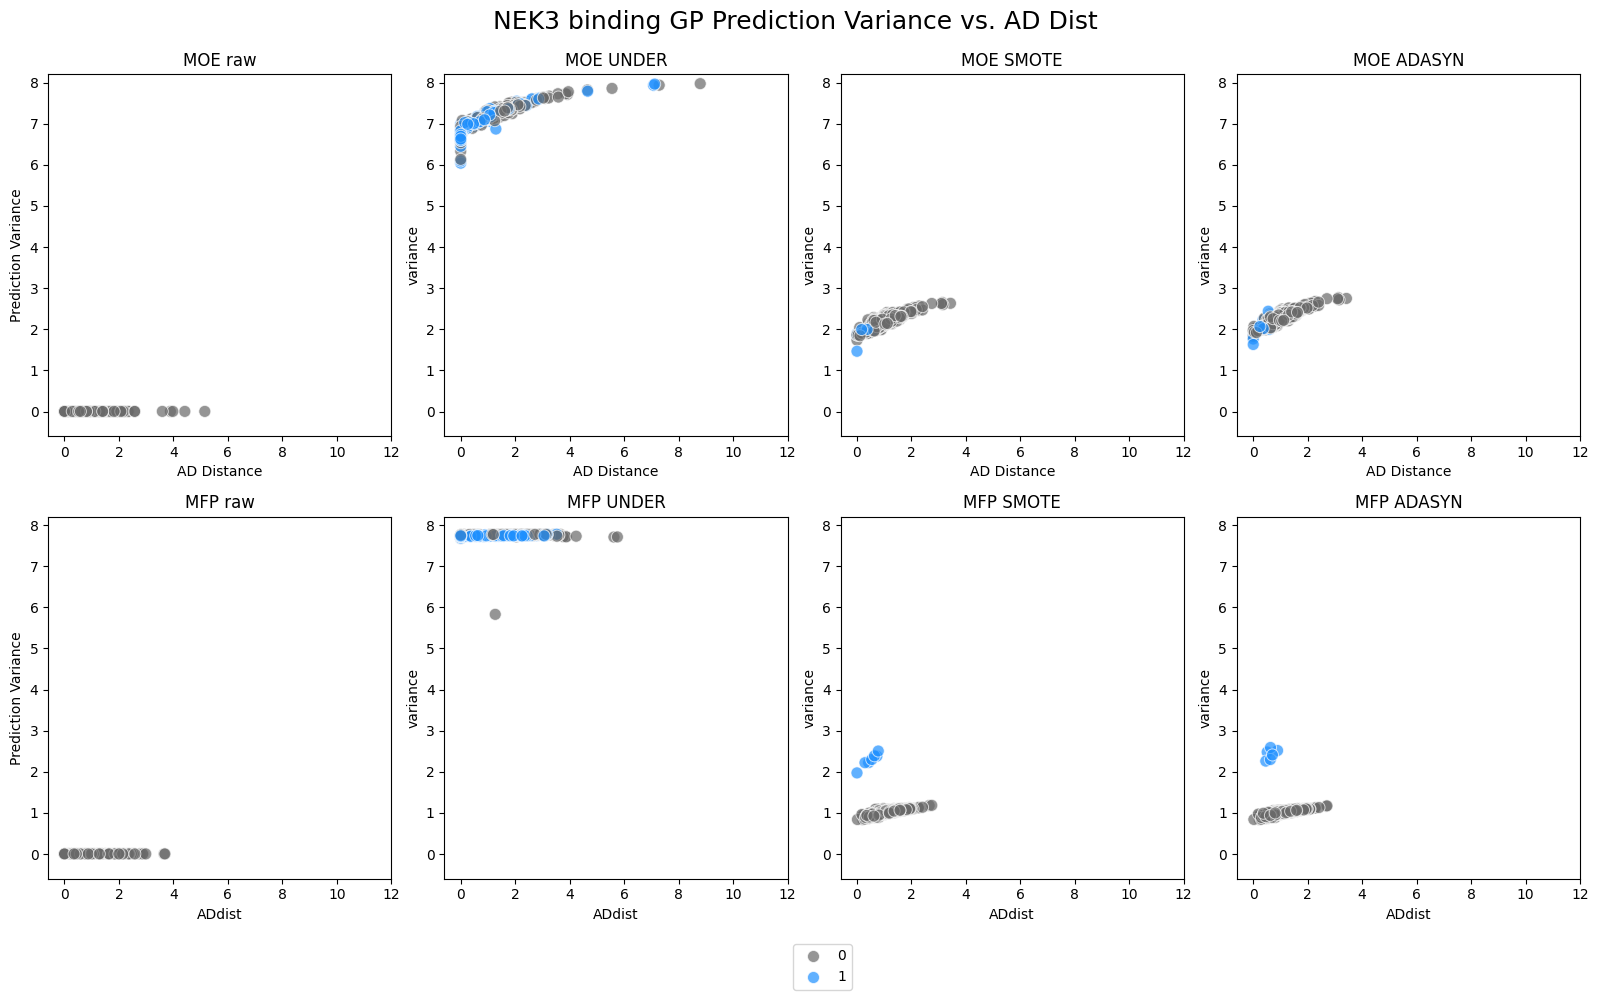

NEK5 binding


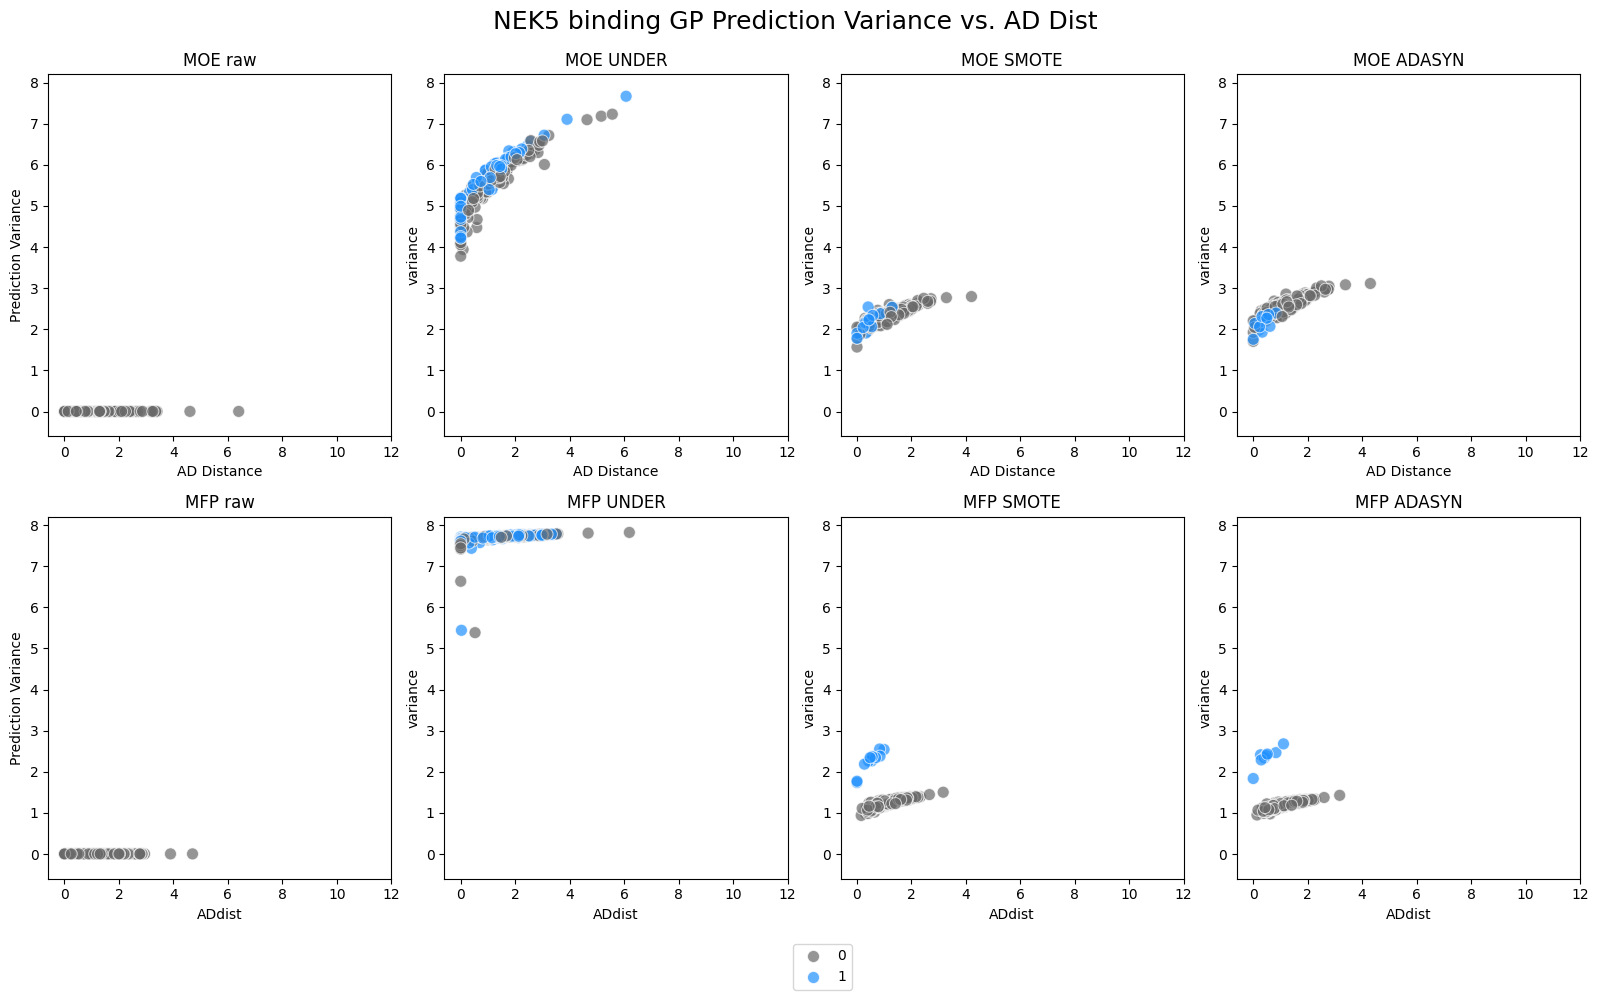

NEK9 binding


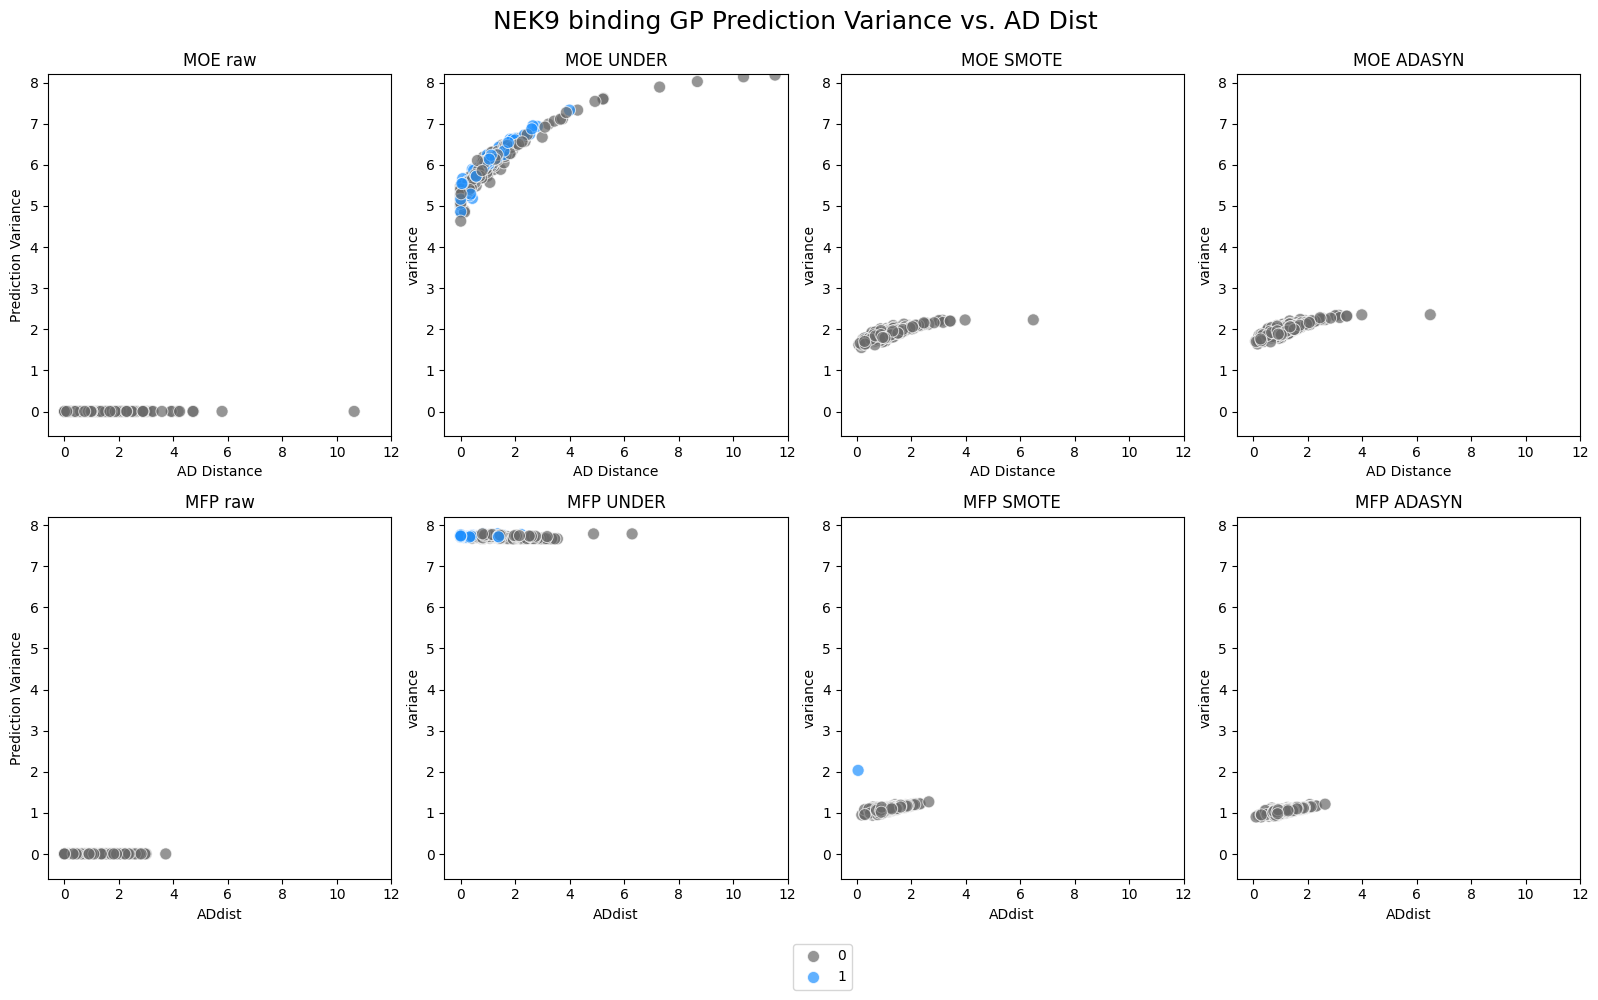

NEK9 inhibition


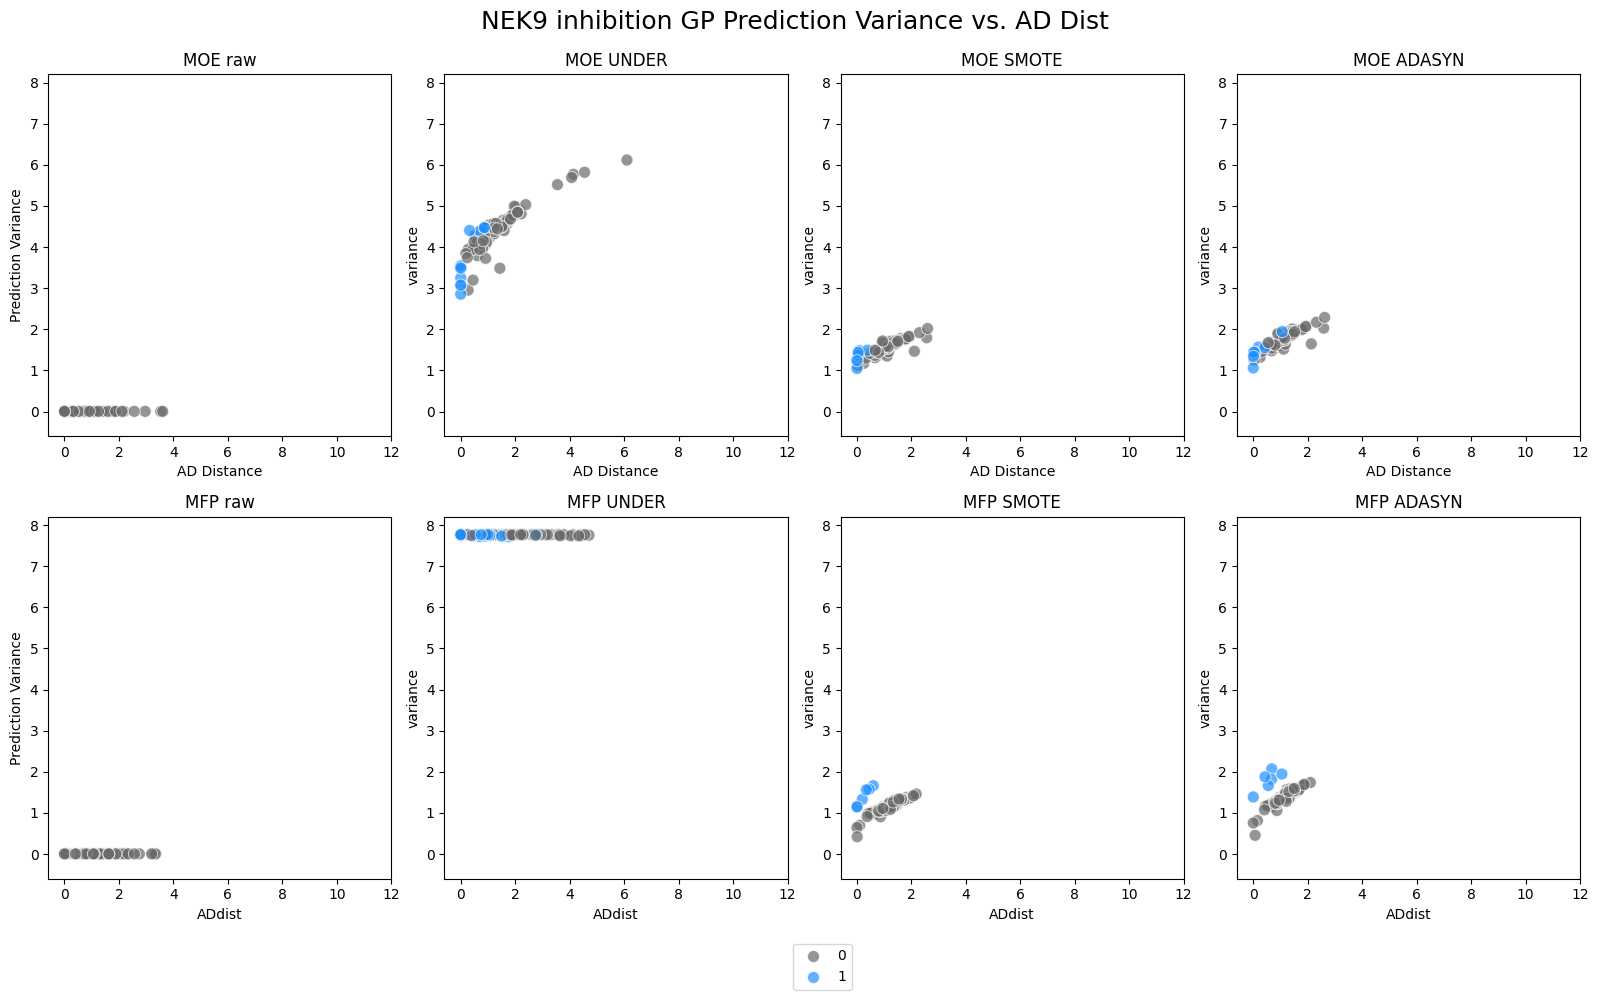

In [173]:
fig_path4 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/samp/subplots/'
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        df_list = [] 
        for samp in samplings: 
            for feat in feat_types: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist, 
                                 'feat_type': gp_results['feat_type'], 'strategy': gp_results['strategy']})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw'
                
                df_list.append(df)
                if samp == 'raw': 
                    samp = 'scaled' 
        figure_name = f'GPvar_AD_dist_class0or1_actual_NEK{nek}_{bi}'
        title = f'NEK{nek} {bi} GP Prediction Variance vs. AD Dist'
     
        inactive_active_GP_var_moemfp_subplots(df_list, title,fig_path4,  figure_name) 
        
            

NEK2 binding


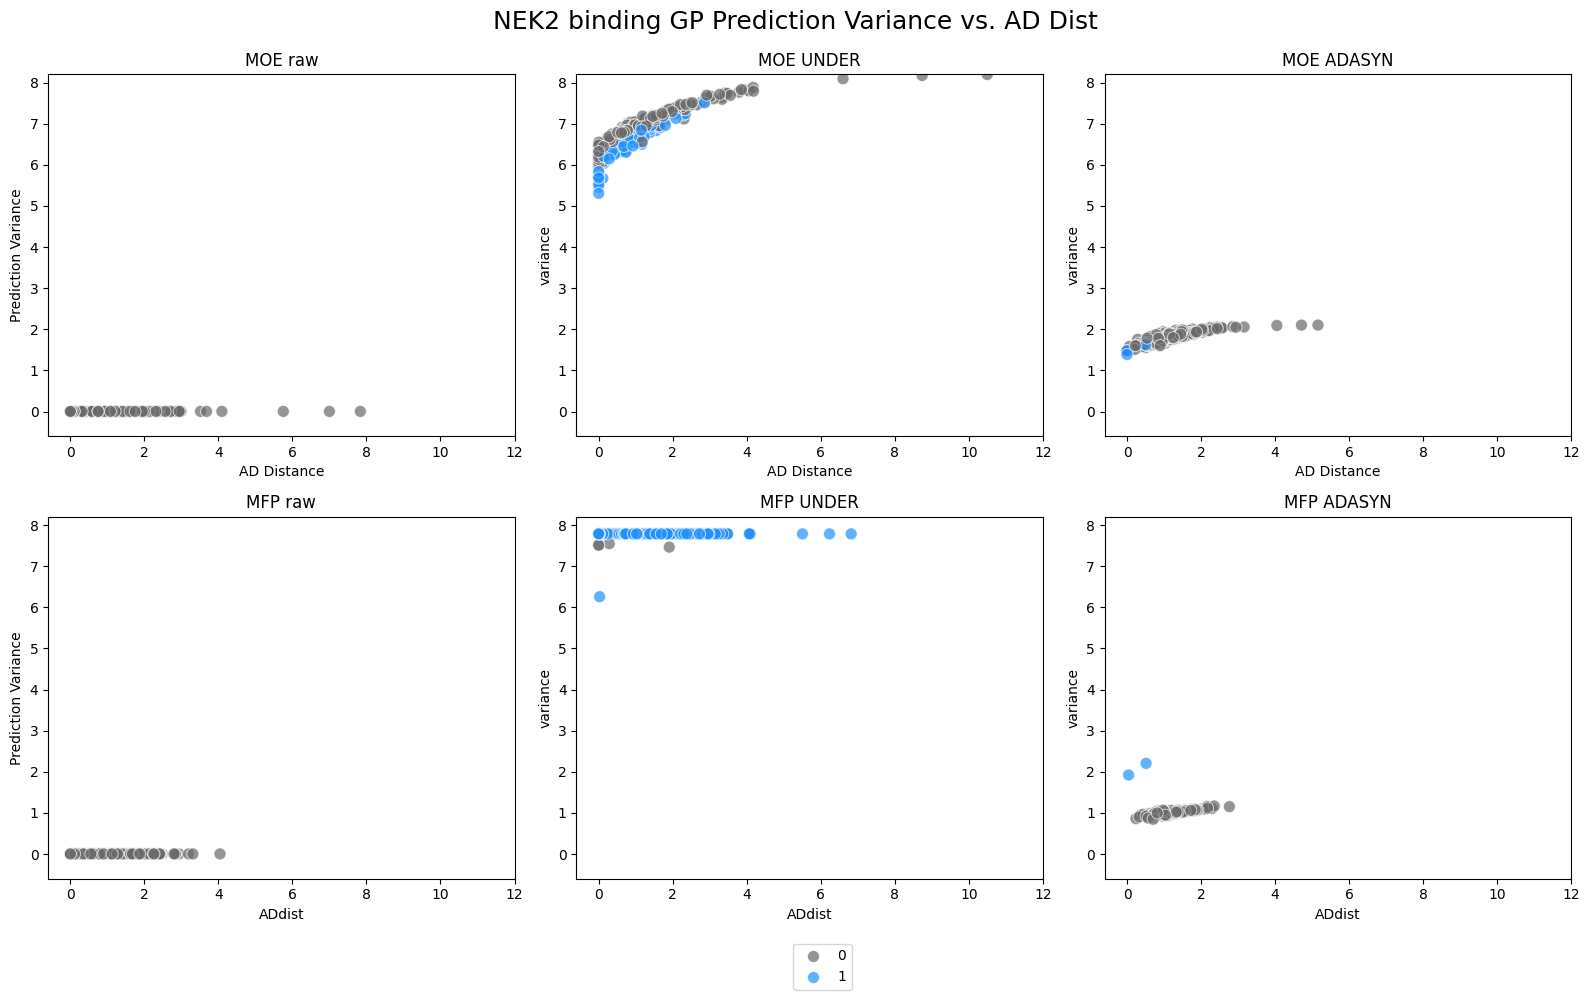

NEK2 inhibition


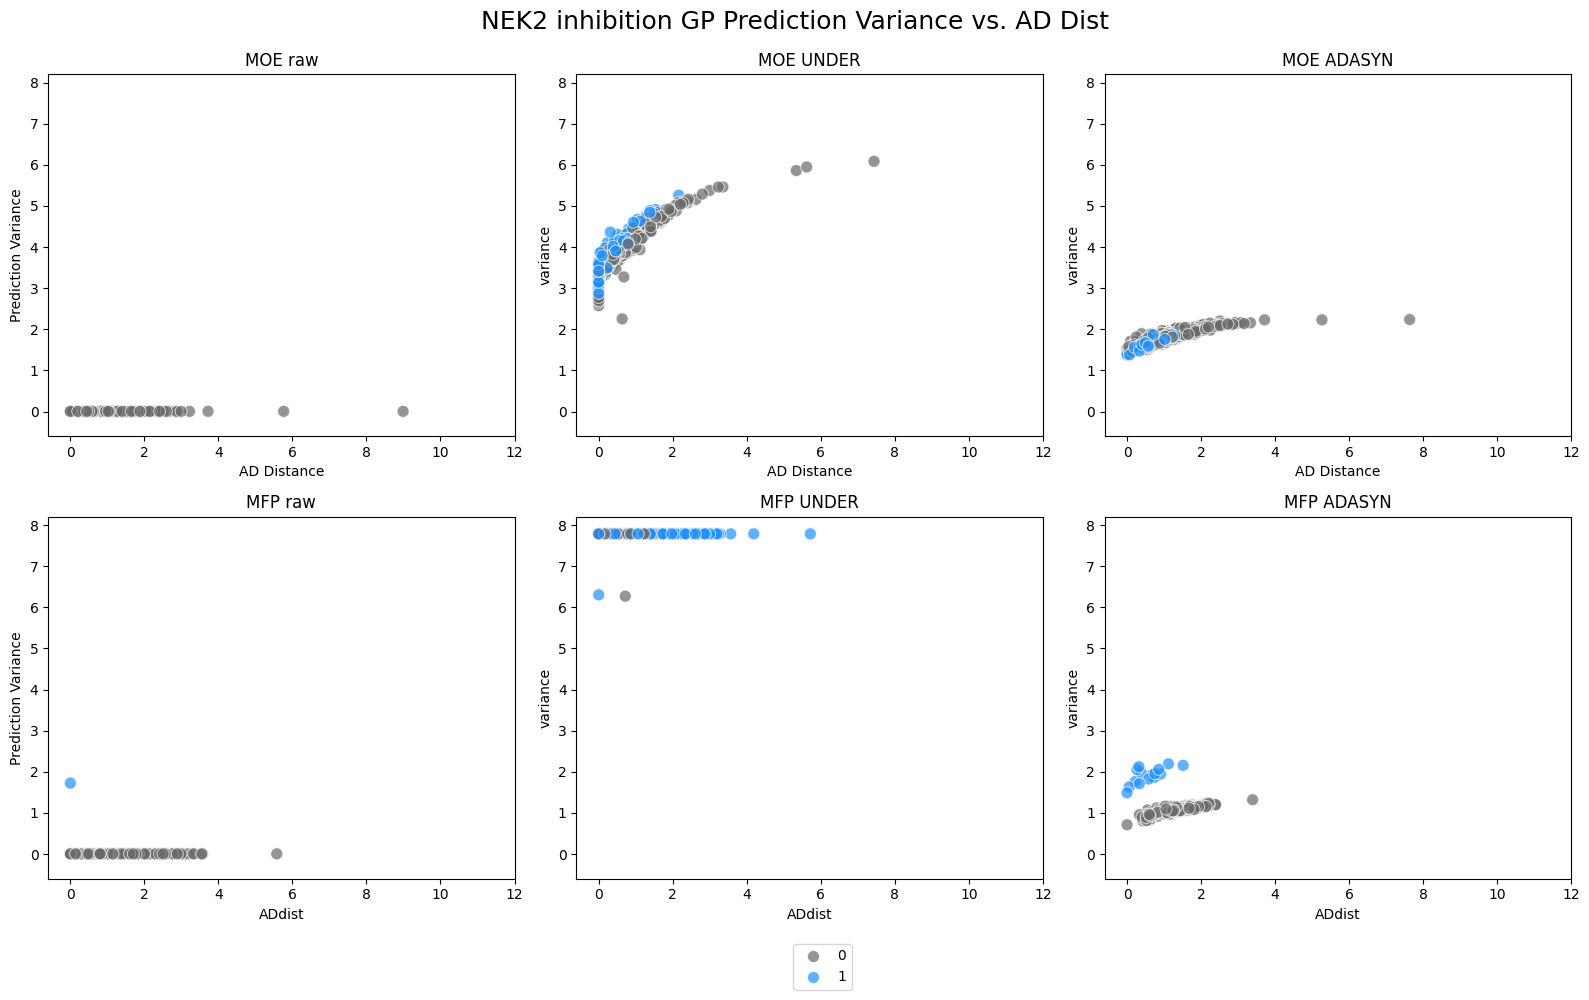

NEK3 binding


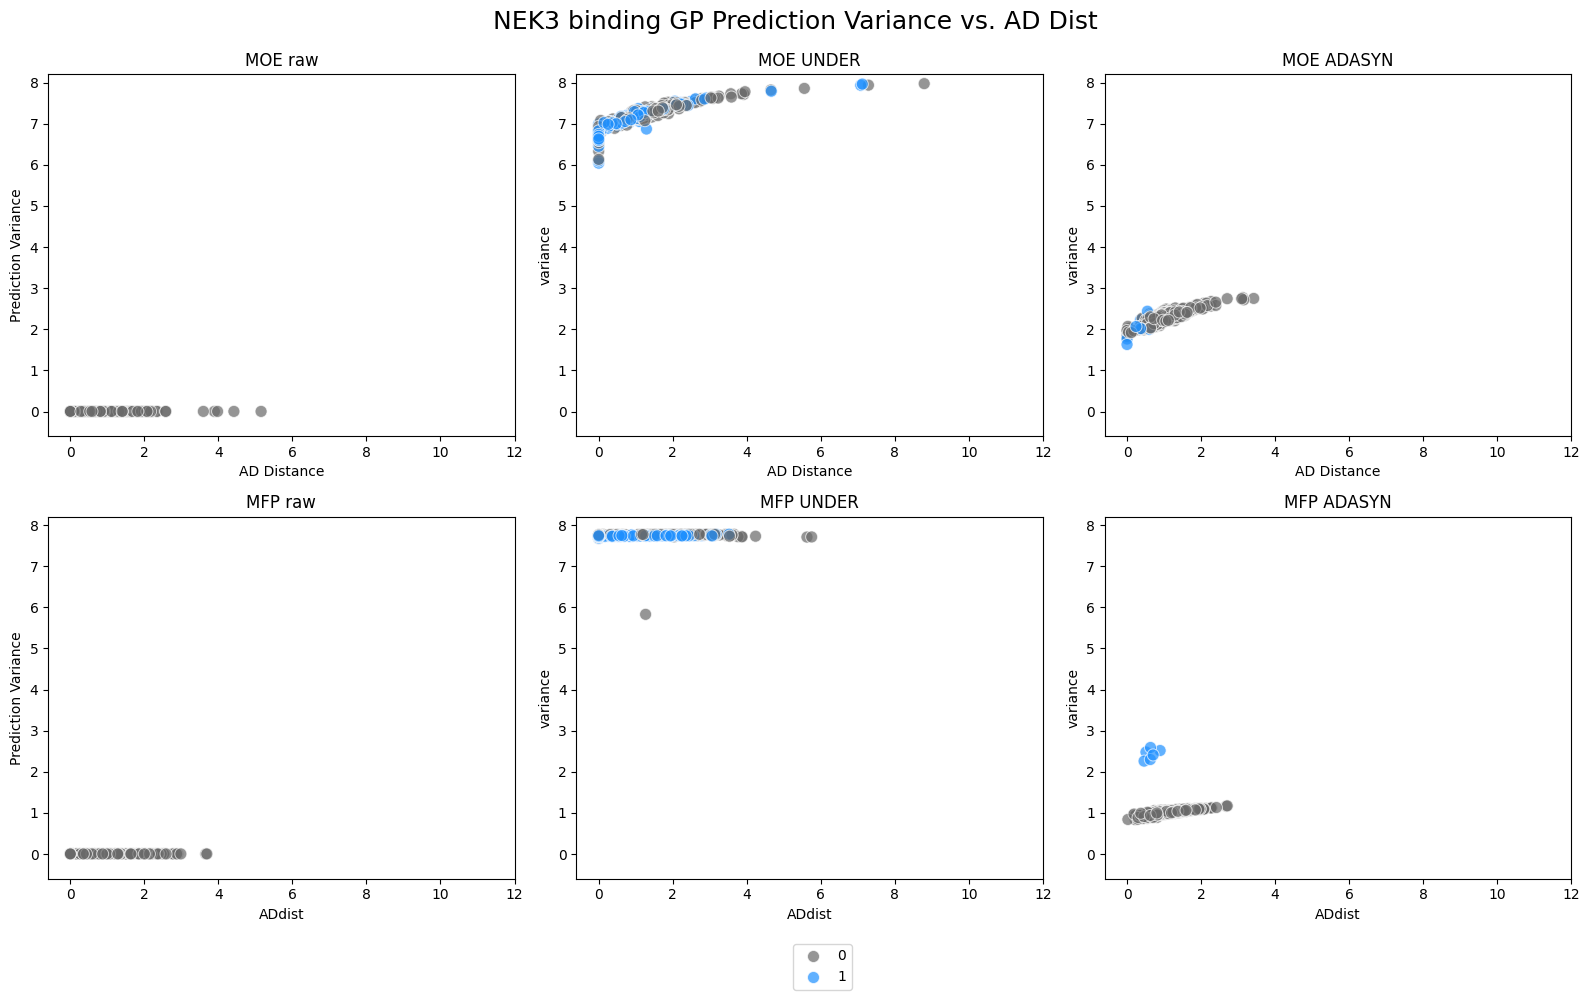

NEK5 binding


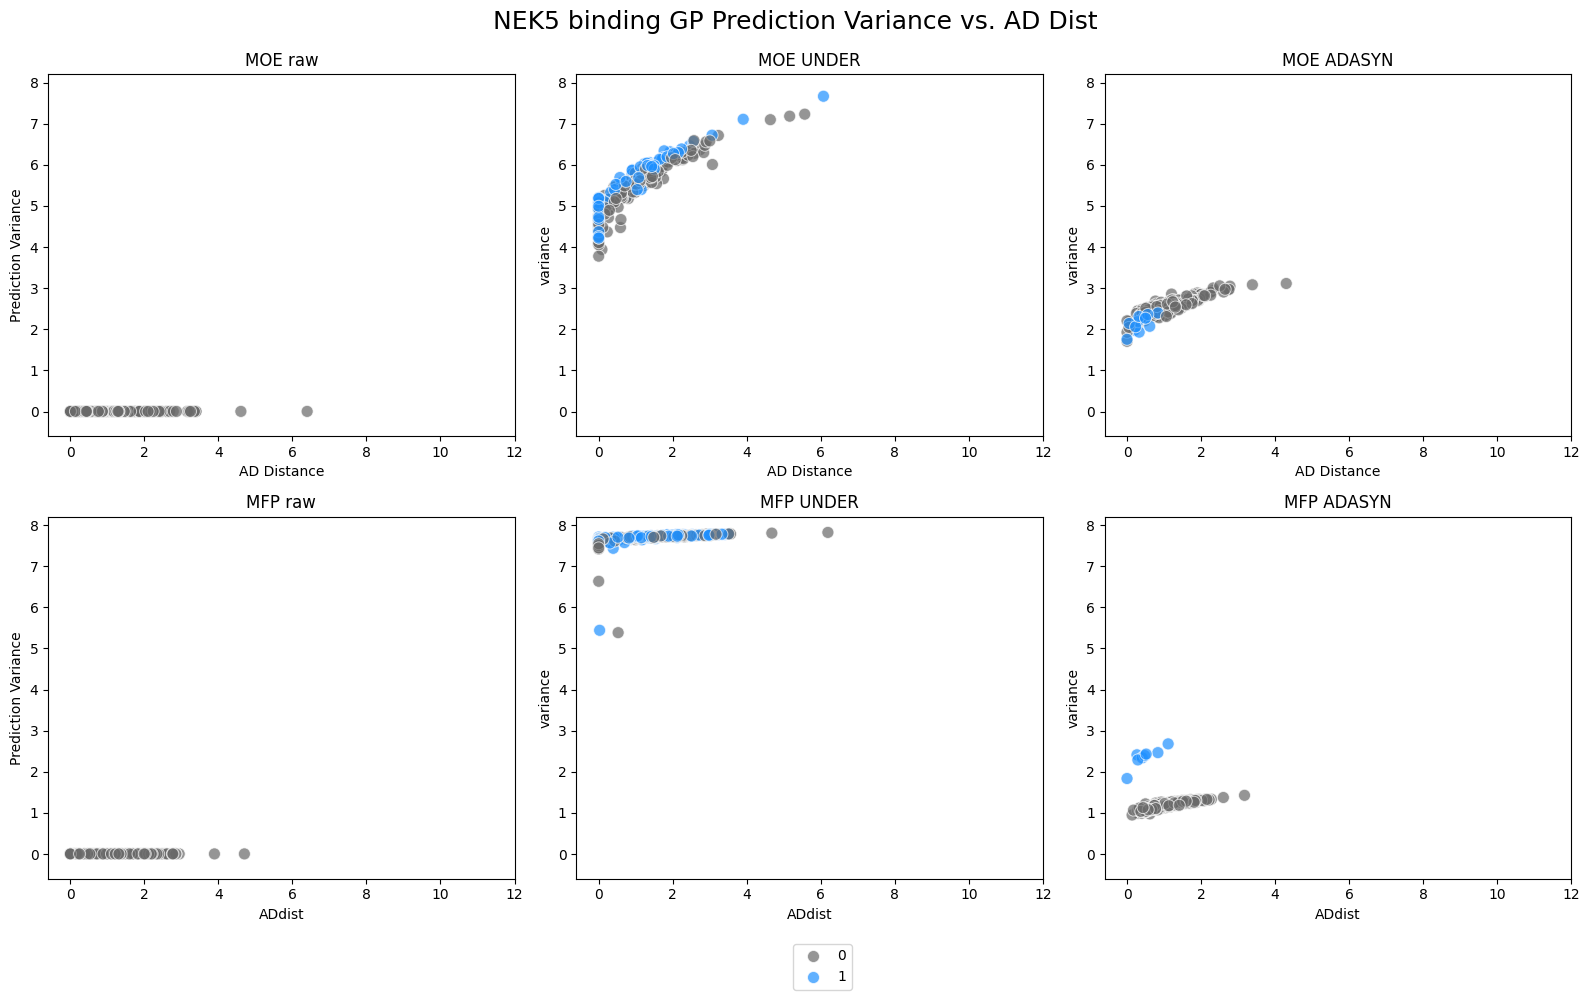

NEK9 binding


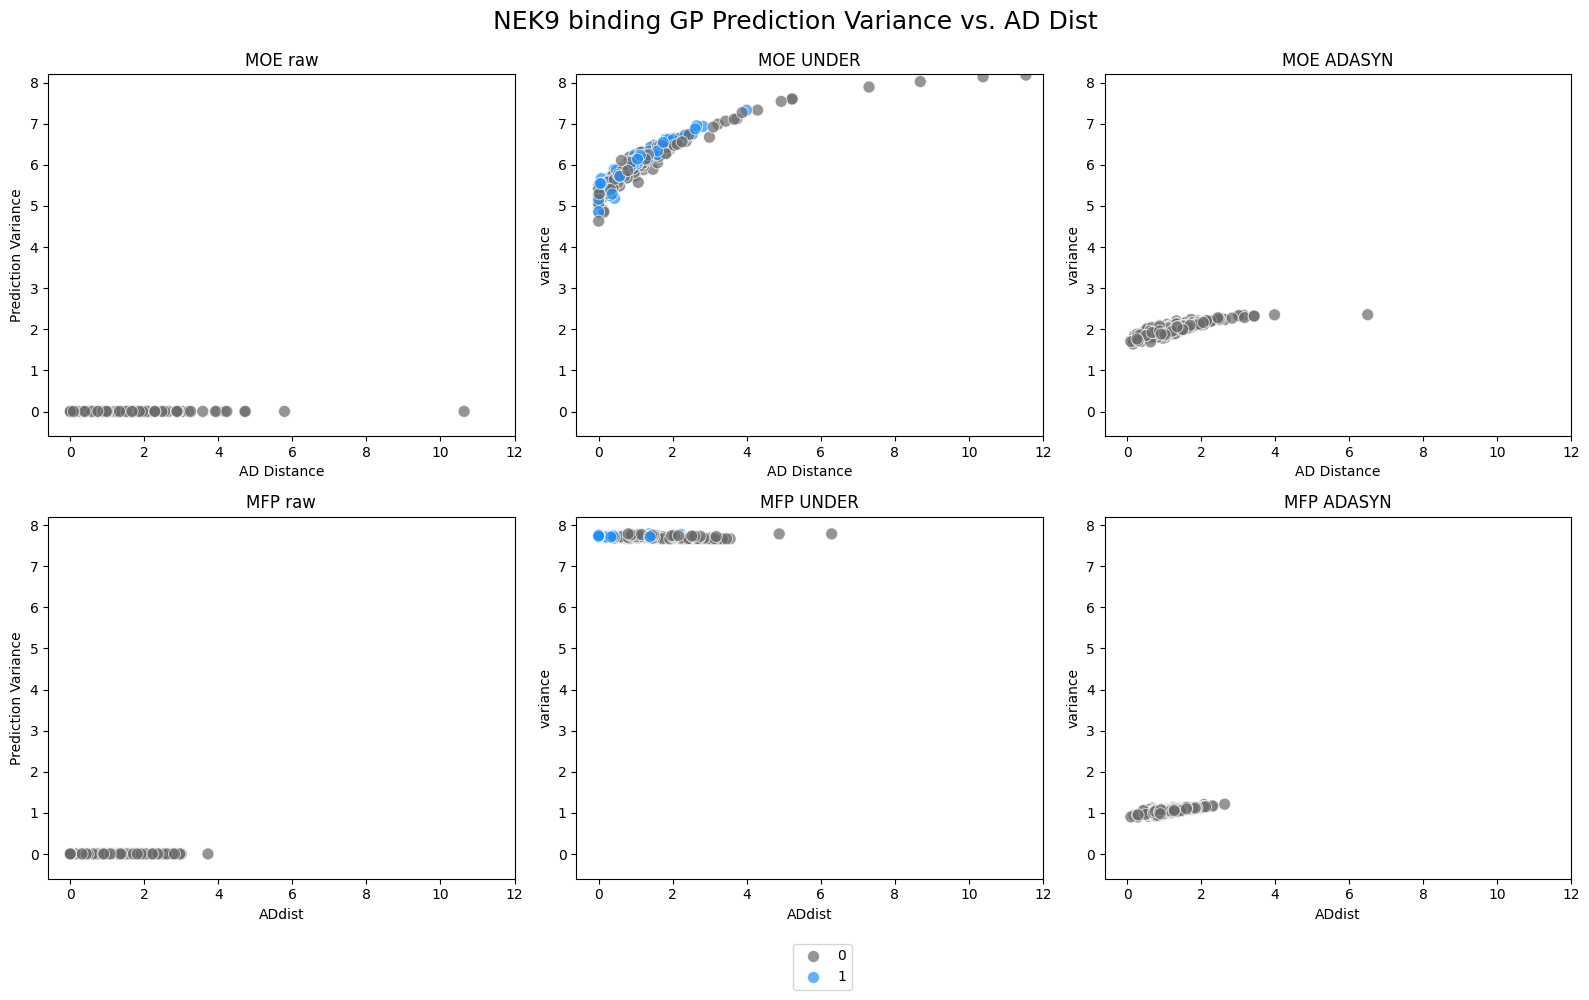

NEK9 inhibition


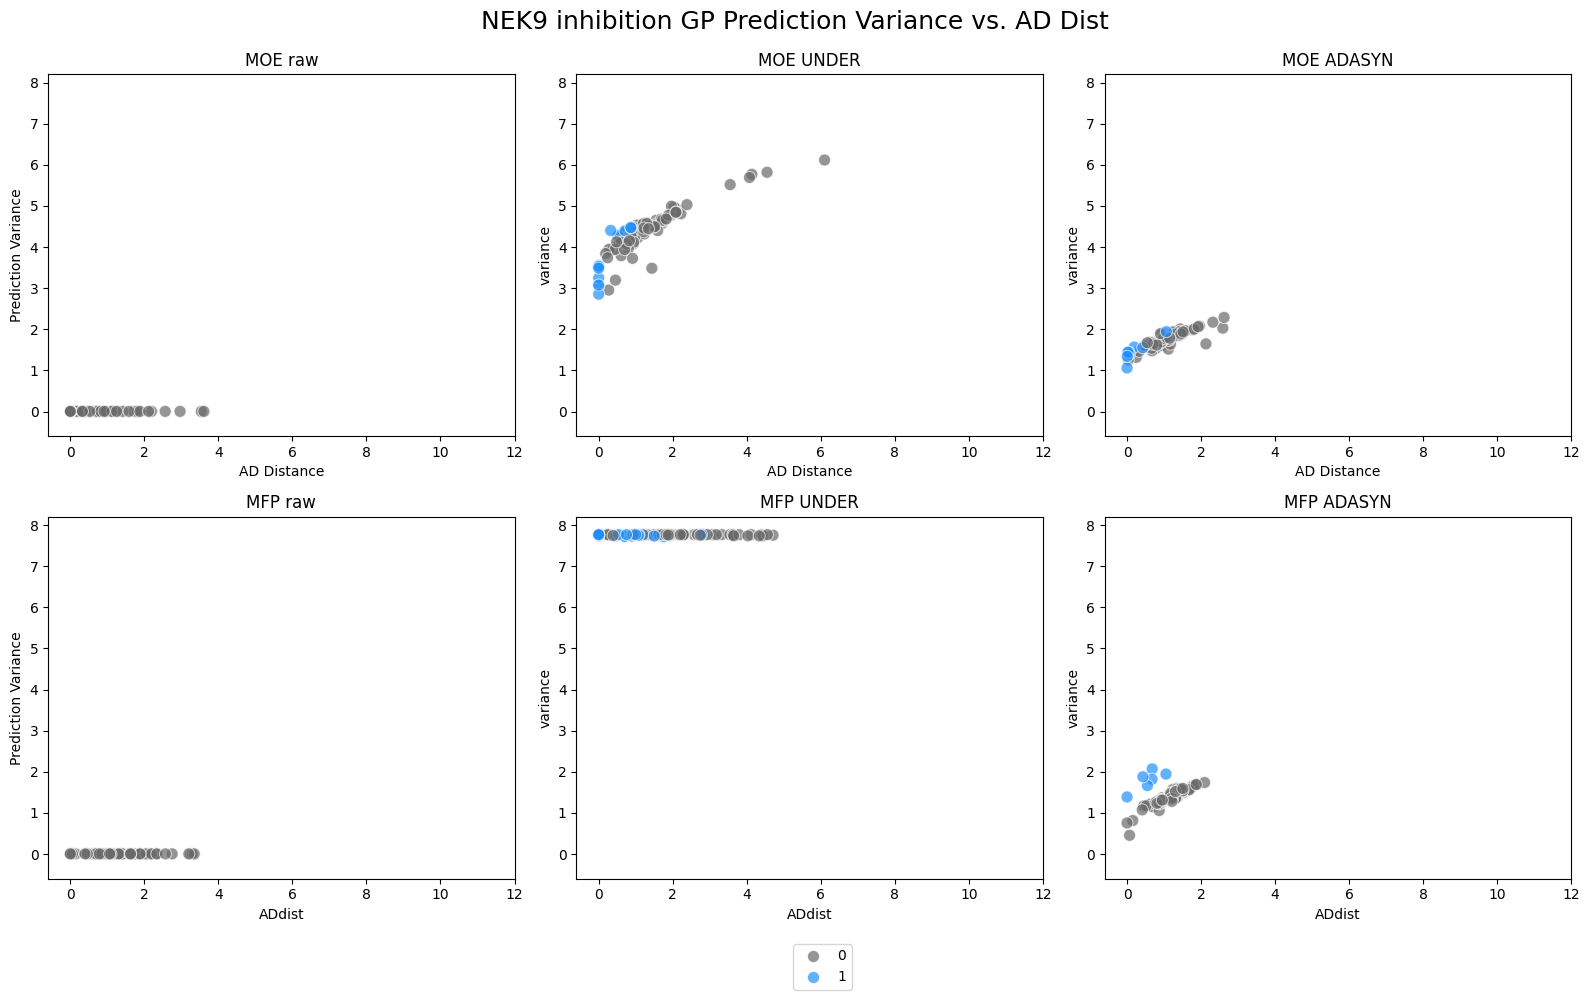

In [174]:
fig_path5 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/samp/subplots/no_SMOTE/'
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        df_list = [] 
        for samp in ['scaled', 'UNDER', 'ADASYN']: 
            for feat in feat_types: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist, 
                                 'feat_type': gp_results['feat_type'], 'strategy': gp_results['strategy']})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw'
                
                df_list.append(df)
                if samp == 'raw': 
                    samp = 'scaled' 
        figure_name = f'GPvar_AD_dist_class0or1_actual_NEK{nek}_{bi}'
        title = f'NEK{nek} {bi} GP Prediction Variance vs. AD Dist'
     
        inactive_active_GP_var_moemfp_subplots(df_list, title,fig_path5,  figure_name) 
        
            

In [25]:
# pred_palette = {'TP':'#96CDFF', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}
hue_order = ['TN','FP', 'FN', 'TP']
pred_sizes = {'TP': 100, 'TN': 95, 'FP': 97, 'FN': 97}
def scatter_ad_GP_jp(dfs,title, figure_path=None, filename=None):


    df_list = [] 
    for df in dfs: 
        true_labels = df['actual'] 
        tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
        tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
        fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
        fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
        
        df['prediction variance'] = np.nan
        

        df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
        df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
        df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
        df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
        
        ad_dist = df['ADdist']
    
        data = {
            'prediction variance': df['prediction variance'],
            'Prediction Type': df['prediction_type'],
            'feat_type': df['feat_type'],
            'ADdist' : df['ADdist'], 
            'strategy': df['strategy']
        
        }
        plot_df = pd.DataFrame(data)
        df_list.append(plot_df) 
    df_all = pd.concat([df for df in df_list])   
    print(df_all['strategy'].unique())
    cols = df_all['strategy'].nunique()
    rows = 2 
    fig, axs = plt.subplots(rows,cols, figsize=(16, 9), sharey=False)
    
    
    for i,samp in enumerate(df_all['strategy'].unique()): 
        this_df = df_all[df_all['strategy'] == samp] 
        moe = this_df[this_df['feat_type'] == 'moe'] 
        mfp = this_df[this_df['feat_type'] == 'mfp']
        sizes = moe['Prediction Type'].map(pred_sizes)
        sizes2 = mfp['Prediction Type'].map(pred_sizes)

  
        sns.scatterplot(x='ADdist', y='prediction variance', data=moe, hue='Prediction Type', palette=pred_palette,
                       ax=axs[0,i], hue_order=hue_order)
        sns.scatterplot(x='ADdist', y='prediction variance', data=mfp, hue='Prediction Type', palette=pred_palette,
                       ax=axs[1,i],hue_order=hue_order)
        axs[0,i].set_xlabel('AD Distance', fontsize=18)
        
        axs[0, i].set_title(f'MOE {samp}', fontsize=18)
        axs[1, i].set_title(f'MFP {samp}', fontsize=18)
        axs[0,i].set(ylim=(-0.6, 8.2)) 
        axs[1,i].set(ylim=(-0.6, 8.2)) 
        axs[0,i].set(xlim=(-0.6, 12))
        axs[1,i].set(xlim=(-0.6, 12))
        # axs[0,i].legend().remove()
        # axs[1,i].legend().remove()
    

        axs[0,i].set_ylabel('Prediction Variance', fontsize=18)
        axs[1,i].set_ylabel('Prediction Variance', fontsize=18)
            
    

    handles, labels = axs[1, 1].get_legend_handles_labels()

    fig.legend(handles, labels, bbox_to_anchor = [0.54, 0], fontsize=18 )
    plt.tight_layout() 
  
    plt.suptitle(title, fontsize=20,y=1.03)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png',bbox_inches='tight')

    plt.show(); 

NEK2 binding
['raw' 'UNDER' 'ADASYN']


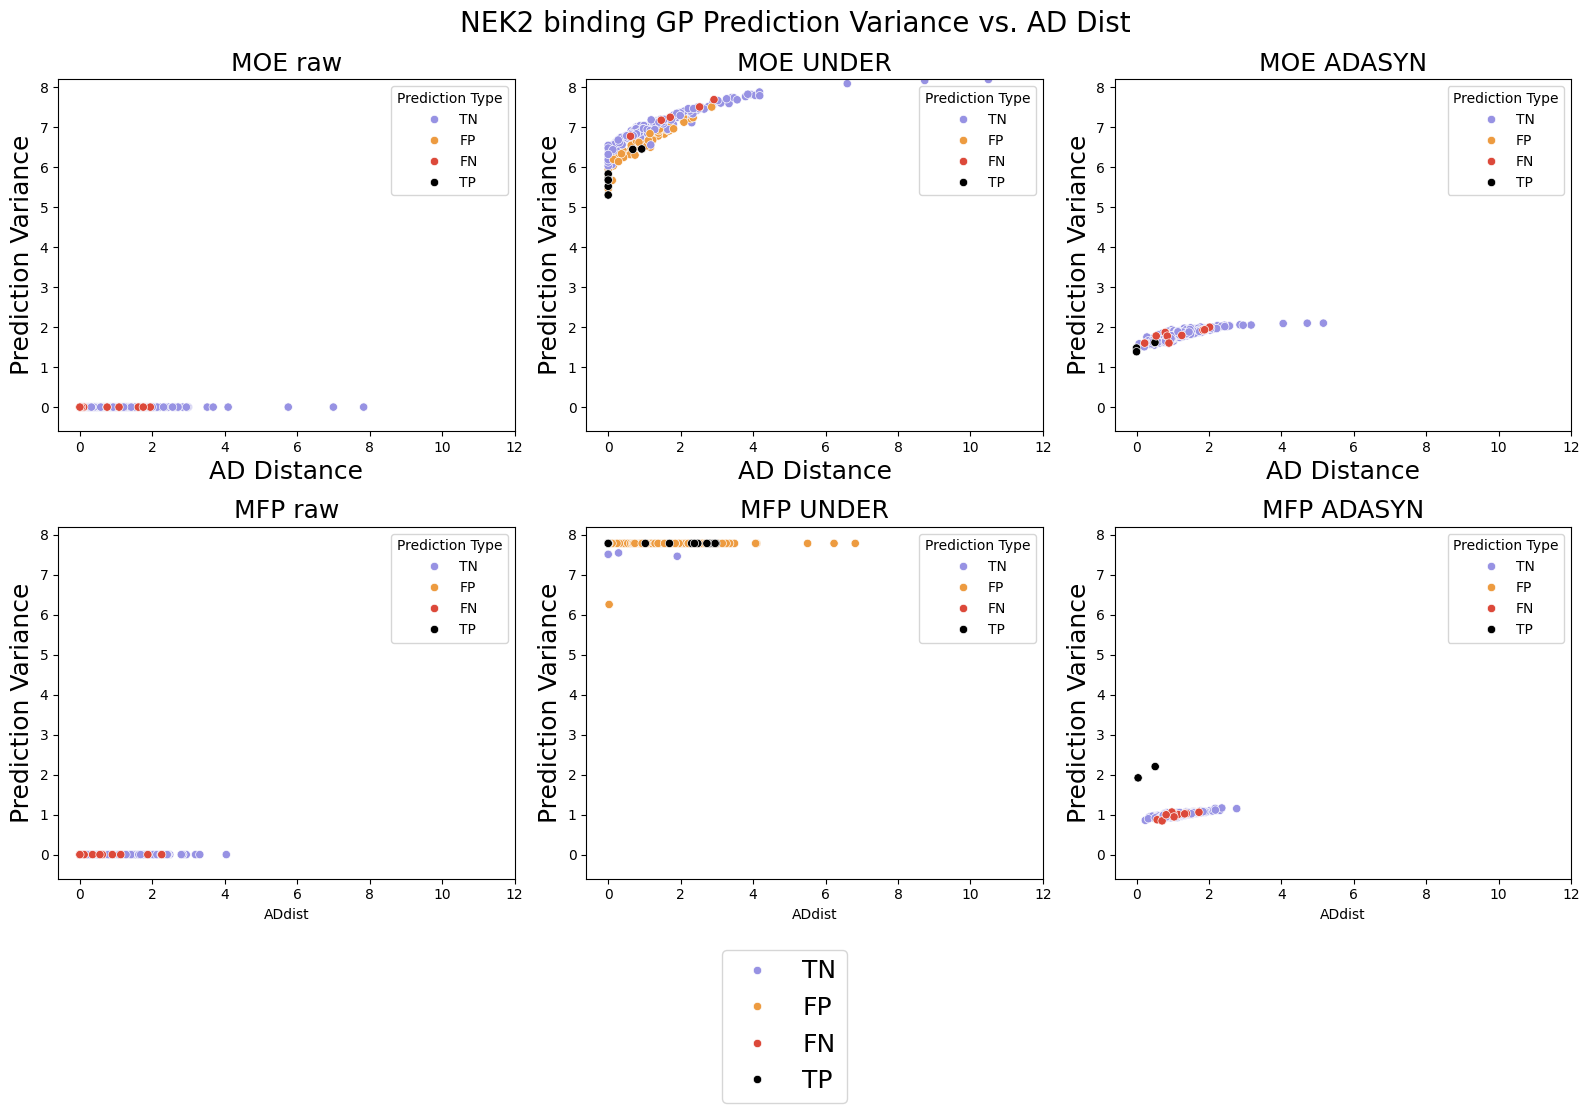

NEK2 inhibition
['raw' 'UNDER' 'ADASYN']


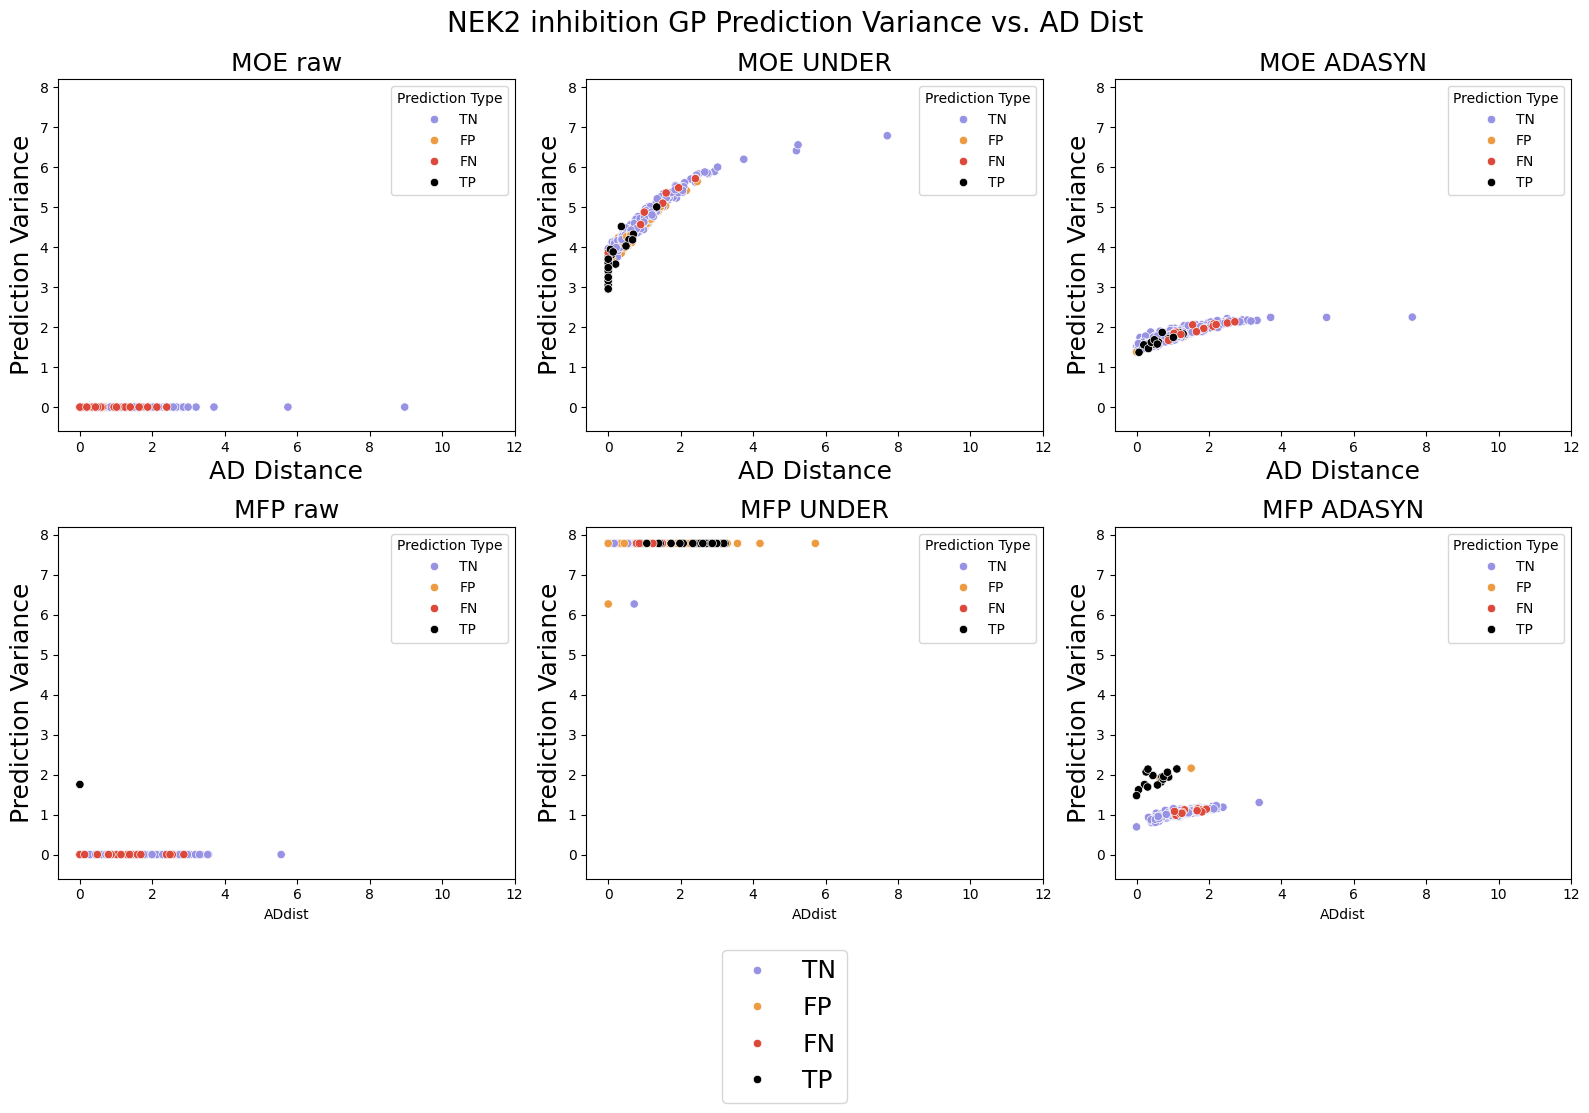

NEK3 binding
['raw' 'UNDER' 'ADASYN']


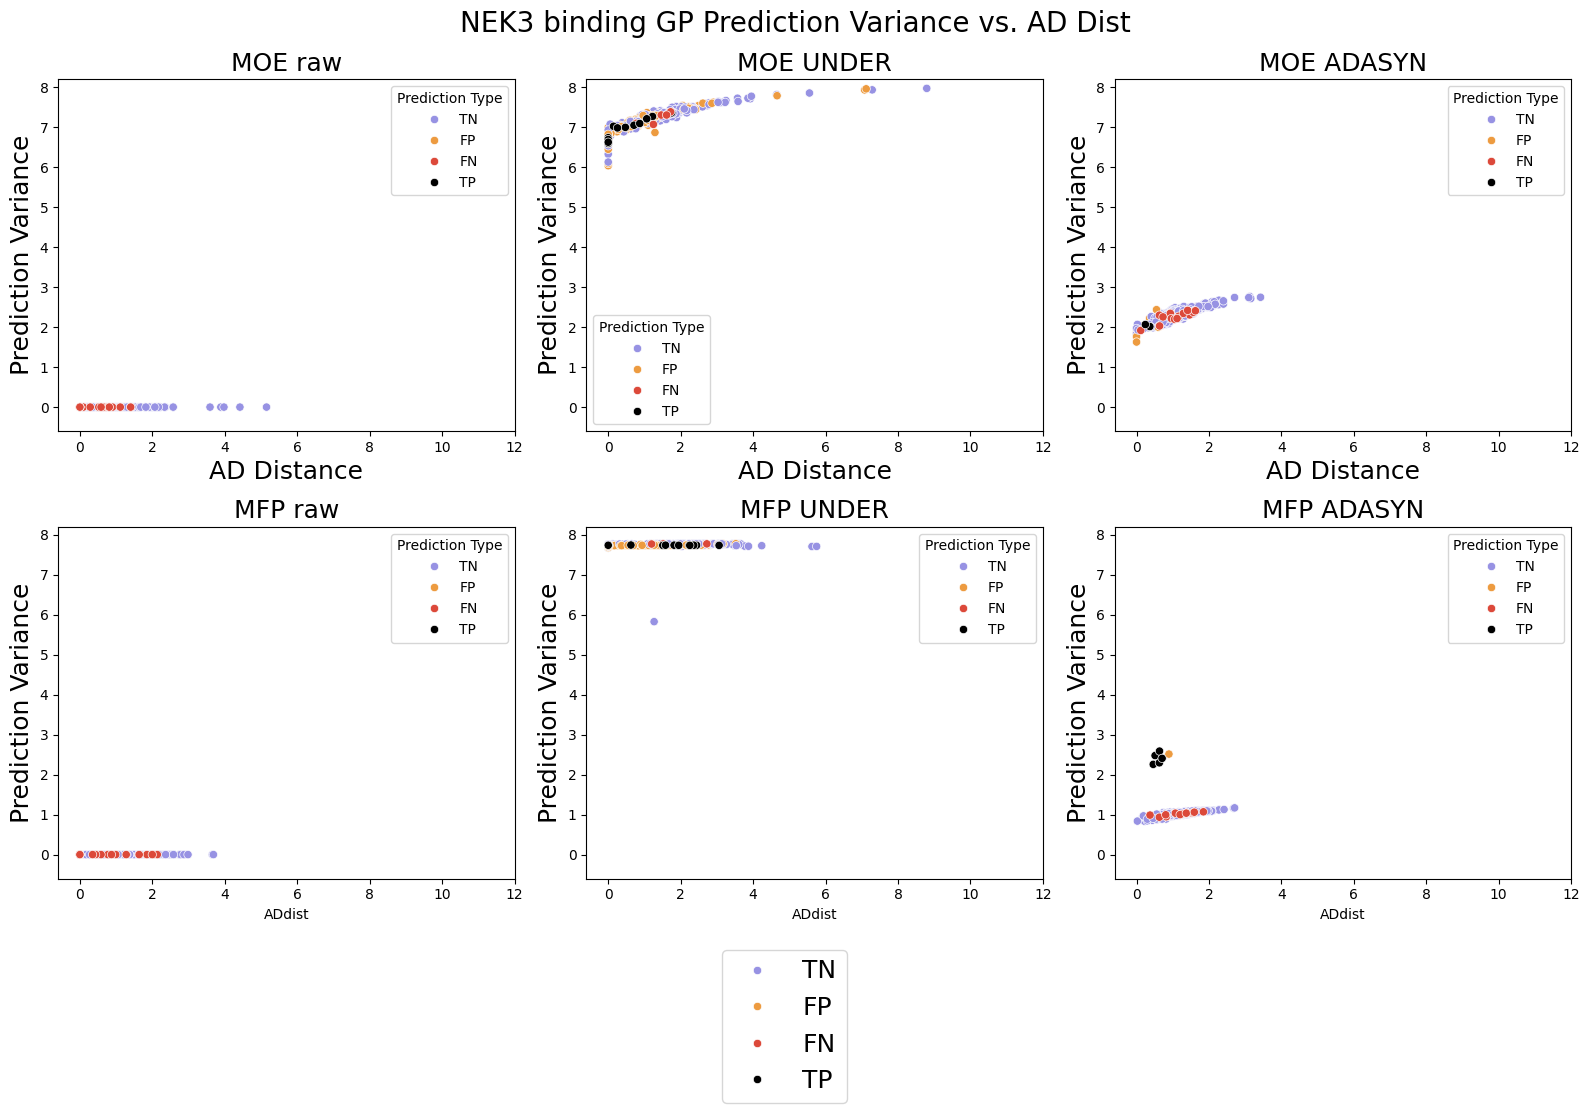

NEK5 binding
['raw' 'UNDER' 'ADASYN']


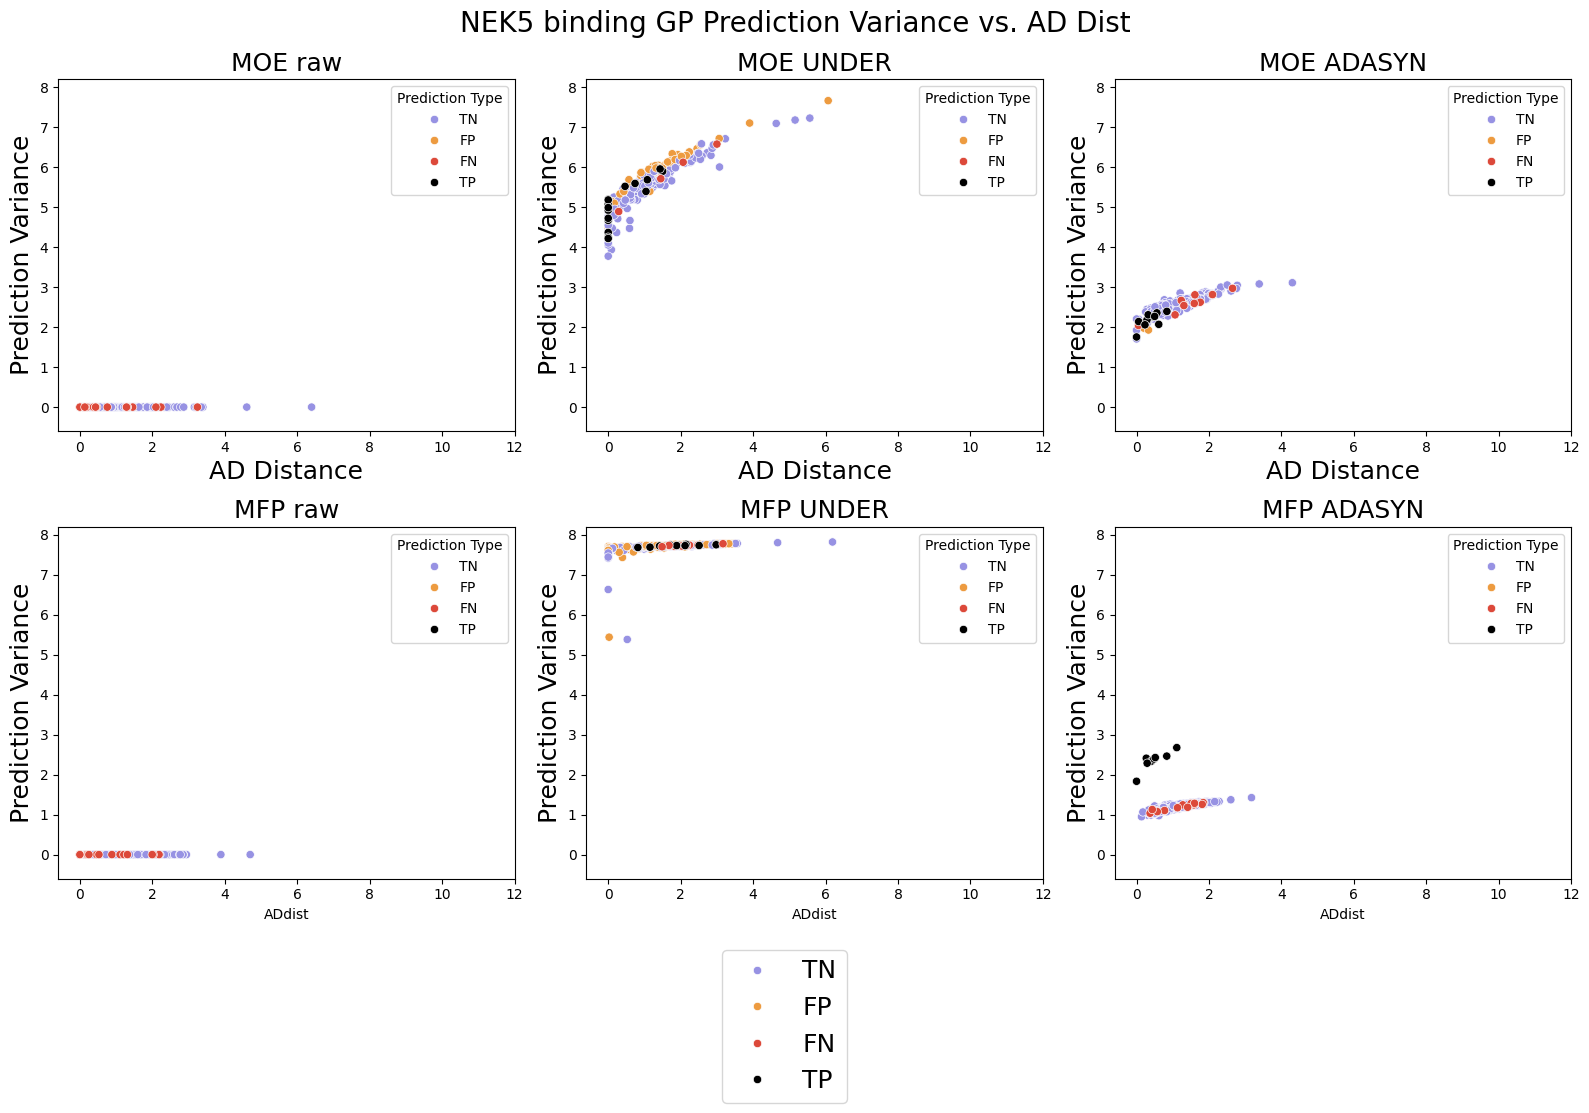

NEK9 binding
['raw' 'UNDER' 'ADASYN']


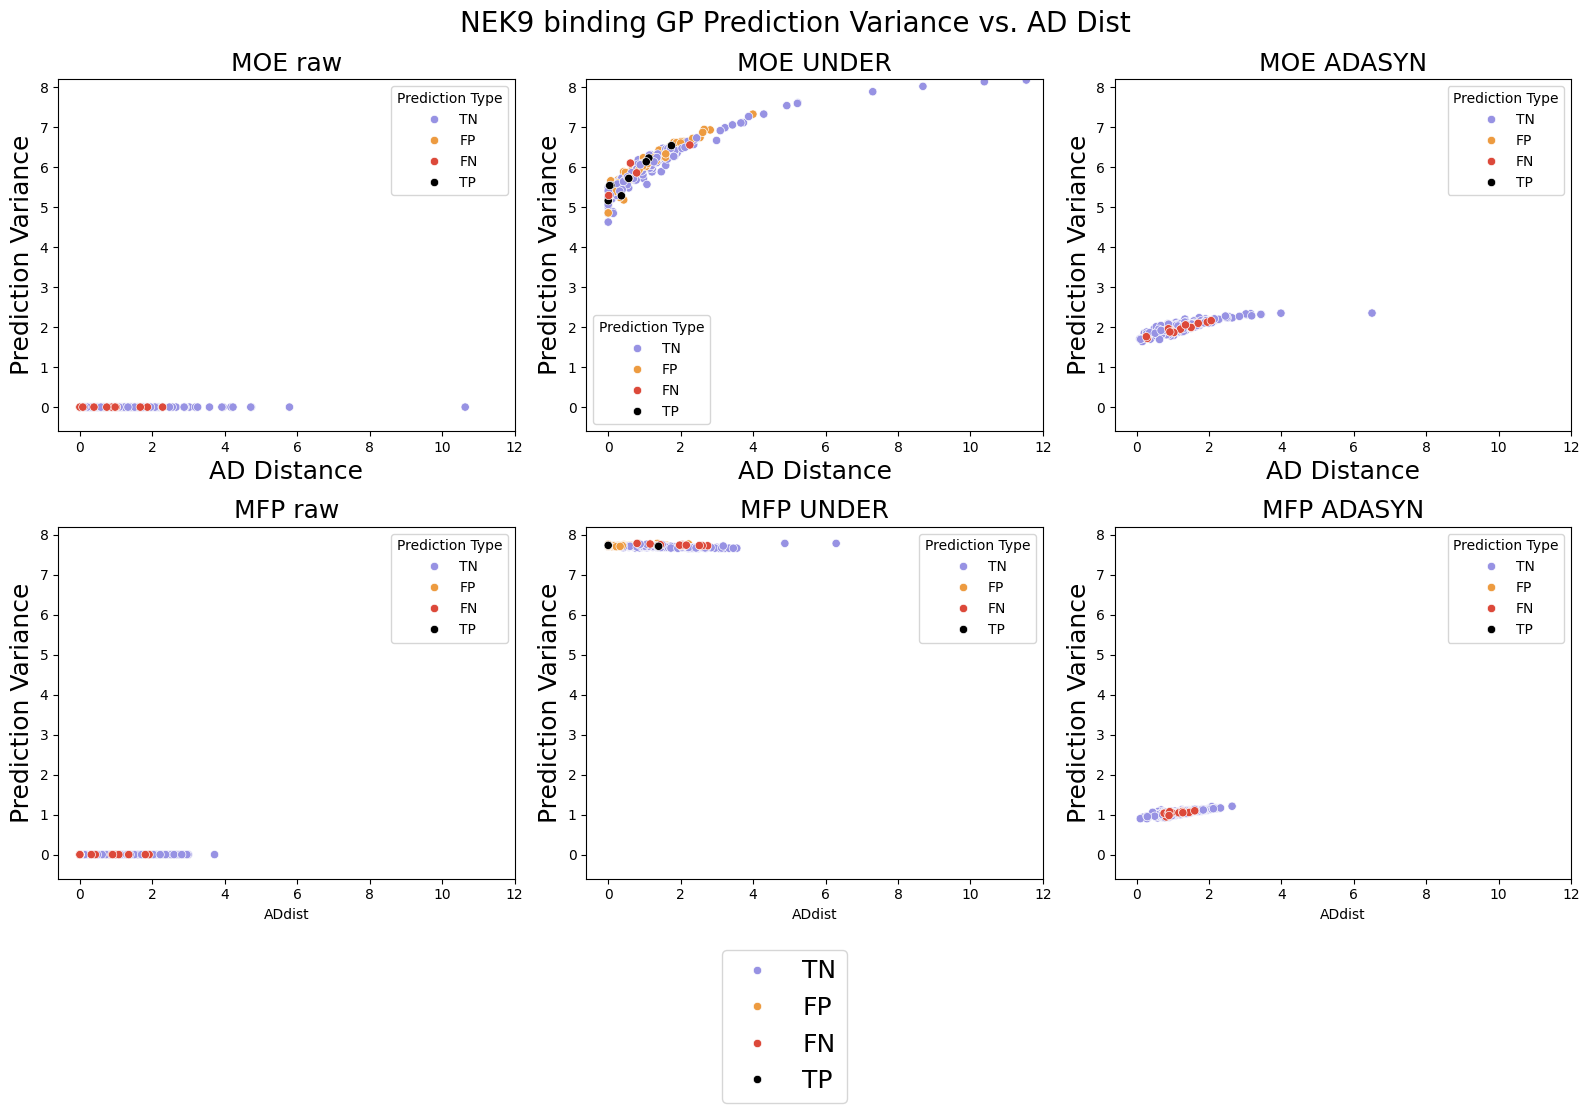

NEK9 inhibition
['raw' 'UNDER' 'ADASYN']


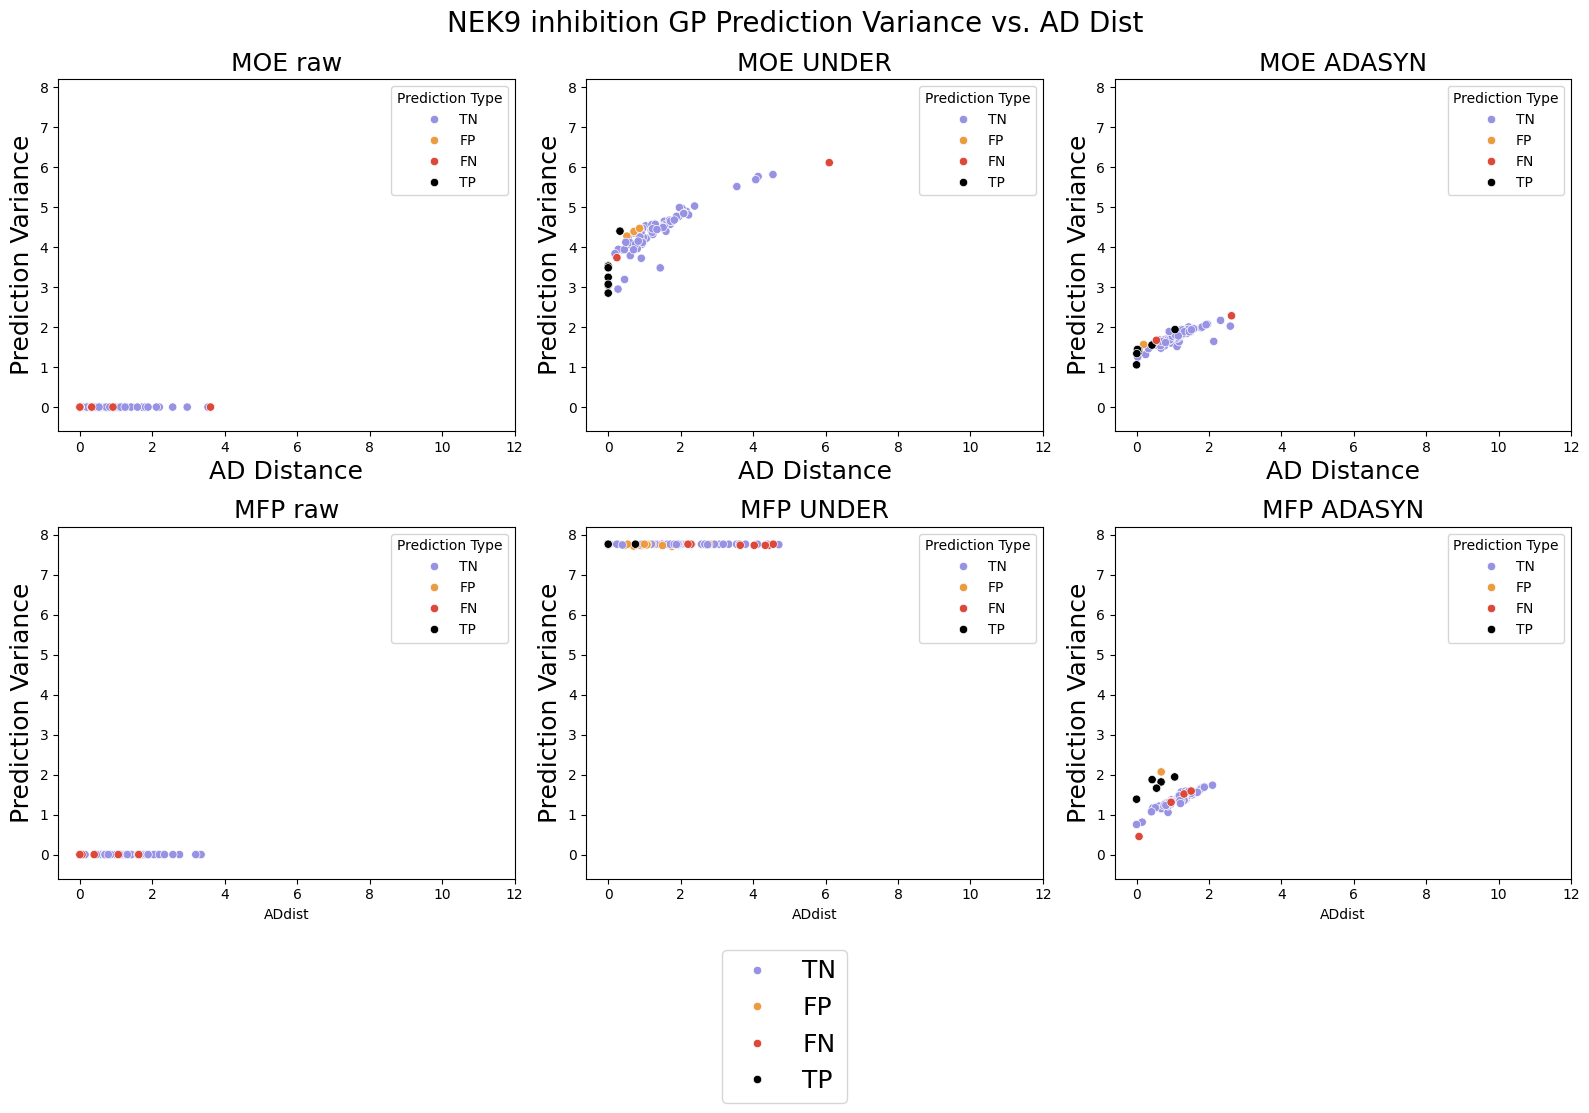

In [26]:
fig_path5 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/samp/subplots/no_SMOTE/'
all_nek_dfs = []
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        df_list = [] 
        for samp in ['scaled', 'UNDER', 'ADASYN']: 
            for feat in feat_types: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist, 
                                 'feat_type': gp_results['feat_type'], 'strategy': gp_results['strategy']})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw'
                
                df_list.append(df)
                if samp == 'raw': 
                    samp = 'scaled' 
        figure_name = f'GPvar_AD_dist_NEK{nek}_{bi}'
        all_nek_dfs.append(df_list)
        title = f'NEK{nek} {bi} GP Prediction Variance vs. AD Dist'
        scatter_ad_GP_jp(df_list, title, fig_path5, figure_name) 
        

In [17]:
def calculate_prediction_variance(df, true_labels):
    # Determine the indices for TP, TN, FP, and FN
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    # Initialize 'prediction variance' with NaN
    df['prediction variance'] = np.nan
    
    # Assign values based on the indices
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    return df


In [18]:
# neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
GPpath= '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/GP/GP_matern_kernel/'

neks = ['2', '3', '5', '9']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

k=7
col_names = ['prediction_type', 'ADdist', 'model_type']
# model_palette = sns.color_palette("Set2", n_colors=3)
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=3)
category_order = ['TP', 'TN', 'FP', 'FN']
nek_names = [] 
all_feats = [] 
sampling_types = [] 
test_dists = []
variance_lists = [] 
for n in ['2', '3', '5', '9']: 
    if n in ['2', '9']: 
        bind_inhib =[ 'binding','inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
            this_nek = f'NEK{n} {bi}'
        for feat in feat_types: 
            for samp in samplings: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{n}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{n}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                
                gp_results = pd.read_csv(f'{GPpath}NEK{n}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                var0 = gp_results['var_pred_class0'].to_numpy()
                var1 = gp_results['var_pred_class1'].to_numpy()
                true_labels = gp_results['y'].to_numpy()
                
                preds = gp_results['y_pred']
                var_df = pd.DataFrame({'prediction': preds, 'var0': var0, 'var1': var1}) 
                variances = calculate_prediction_variance(var_df, true_labels)
                variance_lists.append(variances['prediction variance'].to_numpy())
          
                if samp == 'scaled': 
                    adjusted_samp = 'raw'
                else:
                    adjusted_samp = samp
                
                test_dists.append(test_dist) 
                nek_names.append(f'NEK{n}_{bi}')
                all_feats.append(feat) 
                sampling_types.append(adjusted_samp)
                
AD_df = pd.DataFrame({'NEK': nek_names,'strategy': sampling_types, 'feat_type':all_feats,'ADdist':test_dists, 'Prediction Variance': variance_lists})
AD_df['dataset_category'] = AD_df['feat_type'].astype(str) + '_'+AD_df['strategy']                 

In [19]:
print(type(test_dists[0]))
print(type(variance_lists[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [20]:
AD_df['NEK'].unique()
AD_noSMOTE = AD_df[AD_df['strategy']!='SMOTE']
AD_noSMOTE

NEK strategy feat_type  \
0      NEK2_binding      raw       moe   
1      NEK2_binding    UNDER       moe   
3      NEK2_binding   ADASYN       moe   
4      NEK2_binding      raw       mfp   
5      NEK2_binding    UNDER       mfp   
7      NEK2_binding   ADASYN       mfp   
8   NEK2_inhibition      raw       moe   
9   NEK2_inhibition    UNDER       moe   
11  NEK2_inhibition   ADASYN       moe   
12  NEK2_inhibition      raw       mfp   
13  NEK2_inhibition    UNDER       mfp   
15  NEK2_inhibition   ADASYN       mfp   
16     NEK3_binding      raw       moe   
17     NEK3_binding    UNDER       moe   
19     NEK3_binding   ADASYN       moe   
20     NEK3_binding      raw       mfp   
21     NEK3_binding    UNDER       mfp   
23     NEK3_binding   ADASYN       mfp   
24     NEK5_binding      raw       moe   
25     NEK5_binding    UNDER       moe   
27     NEK5_binding   ADASYN       moe   
28     NEK5_binding      raw       mfp   
29     NEK5_binding    UNDER       mfp   
31     NEK5_binding   ADASYN       mfp   
32     NEK9_binding      raw       moe   
33     NEK9_binding    UNDER       moe   
35     NEK9_binding   ADASYN       moe   
36     NEK9_binding      raw       mfp   
37     NEK9_binding    UNDER       mfp   
39     NEK9_binding   ADASYN       mfp   
40  NEK9_inhibition      raw       moe   
41  NEK9_inhibition    UNDER       moe   
43  NEK9_inhibition   ADASYN       moe   
44  NEK9_inhibition      raw       mfp   
45  NEK9_inhibition    UNDER       mfp   
47  NEK9_inhibition   ADASYN       mfp   

                                               ADdist  \
0   [0.7407538958848485, 1.4563272423784883, 1e-06...   
1   [0.5131690816220207, 1.5009901250558475, 1.155...   
3   [1.220582066354029, 1.7219949920957176, 0.8925...   
4   [1.6590733221163438, 0.7817557420190709, 1e-06...   
5   [2.039495813666644, 0.8203828786348141, 0.9391...   
7   [1.611269336157317, 1.2162233626578625, 0.9002...   
8   [1e-06, 0.7510265820076479, 1e-06, 0.146126215...   
9   [0.45466674877554314, 0.7524499643047736, 1e-0...   
11  [0.8516883802849228, 1.4684481427313476, 0.262...   
12  [1e-06, 1.0958272290831759, 1e-06, 1.177141091...   
13  [0.26453766289696756, 1.0105322318568142, 0.13...   
15  [0.9785471333217429, 1.429293804601579, 0.9890...   
16  [0.613095869543025, 0.4617873040845102, 0.8538...   
17  [2.551414369182115, 0.5572233934976782, 1.2253...   
19  [1.059519161553535, 1.1384732474643104, 1.2118...   
20  [1e-06, 2.544985763375365, 1.843089566759367, ...   
21  [1e-06, 3.5103008845693604, 2.7277484881458784...   
23  [0.5949756697183963, 2.1357481446392677, 1.626...   
24  [0.5812051126397135, 1.5477321251841918, 1e-06...   
25  [1e-06, 1.6452044803699484, 2.1187240392100506...   
27  [1.0566045066198533, 1.8062066417393756, 0.766...   
28  [0.7744962512193596, 1.6804024274401888, 1e-06...   
29  [2.6326583628428297, 2.3167782838377233, 0.282...   
31  [1.416977408346476, 1.8758226925709145, 0.7391...   
32  [1e-06, 1.3298697651624987, 0.6071022182305352...   
33  [0.401700967467178, 0.7636349107217637, 0.2923...   
35  [0.37822911858282954, 1.3683727385134998, 1.28...   
36  [1e-06, 2.6523035887541537, 1e-06, 1e-06, 1.98...   
37  [0.43153552018296326, 3.550308893156744, 1e-06...   
39  [0.5252954024218042, 2.200399973225058, 0.8215...   
40  [1.0370653367969547, 1e-06, 1e-06, 0.650013082...   
41  [1.0324833235638395, 1.0567455868072333, 0.551...   
43  [1.3592542991598893, 0.7703641137423324, 0.670...   
44  [0.05873343525575518, 1e-06, 1e-06, 2.33417546...   
45  [1.7620664293212018, 1.800667778979008, 3.0654...   
47  [0.9601482839973309, 0.7342399257119192, 0.936...   

                                  Prediction Variance dataset_category  
0   [0.0033734273, 0.003446973, 0.003428692, 0.003...          moe_raw  
1   [6.7194996, 7.103724, 6.657249, 7.1595244, 6.8...        moe_UNDER  
3   [1.789168, 1.907289, 1.8288324, 1.8809, 1.8360...       moe_ADASYN  
4   [0.0034682462, 0.003428984, 0.0034317584, 0.00...      

In [336]:
df_flat = AD_noSMOTE.explode('Prediction Variance')

df_flat['Prediction Variance'] = pd.to_numeric(df_flat['Prediction Variance'])

for nek in df_flat['NEK'].unique(): 
    print(nek) 
    this_df = df_flat[df_flat['NEK']==nek] 
    df_grouped = df_flat.groupby('strategy')[['Prediction Variance']].agg(['max', 'min'])
    display(df_grouped)

NEK2_binding


Prediction Variance          
                         max       min
strategy                              
ADASYN              3.113769  0.455739
UNDER               8.195847  2.253190

NEK2_inhibition


Prediction Variance          
                         max       min
strategy                              
ADASYN              3.113769  0.455739
UNDER               8.195847  2.253190

NEK3_binding


Prediction Variance          
                         max       min
strategy                              
ADASYN              3.113769  0.455739
UNDER               8.195847  2.253190

NEK5_binding


Prediction Variance          
                         max       min
strategy                              
ADASYN              3.113769  0.455739
UNDER               8.195847  2.253190

NEK9_binding


Prediction Variance          
                         max       min
strategy                              
ADASYN              3.113769  0.455739
UNDER               8.195847  2.253190

NEK9_inhibition


Prediction Variance          
                         max       min
strategy                              
ADASYN              3.113769  0.455739
UNDER               8.195847  2.253190

In [343]:
AD_noSMOTE['strategy'].value_counts()

strategy
raw       12
UNDER     12
ADASYN    12
Name: count, dtype: int64

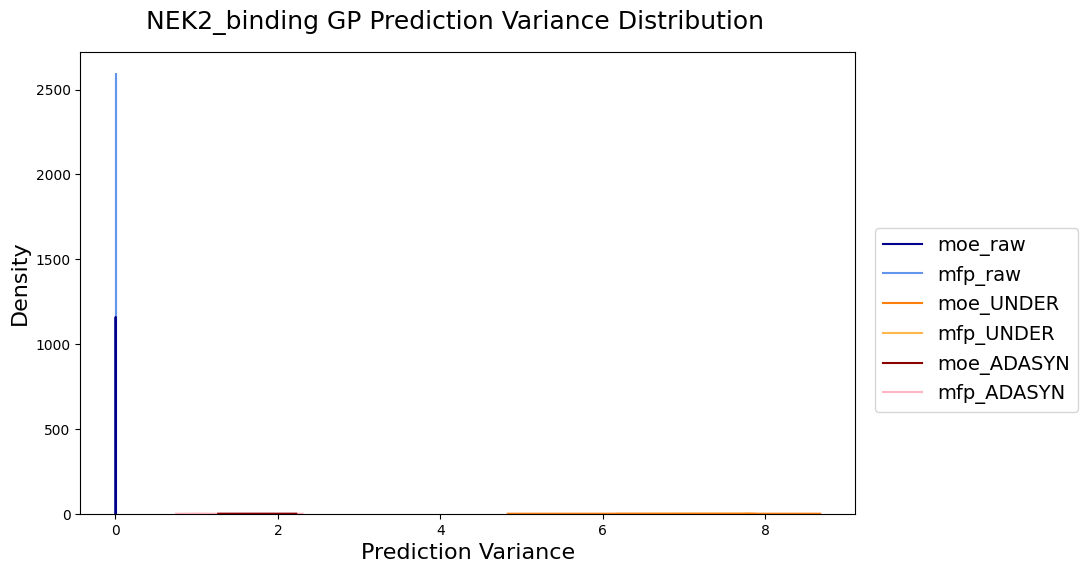

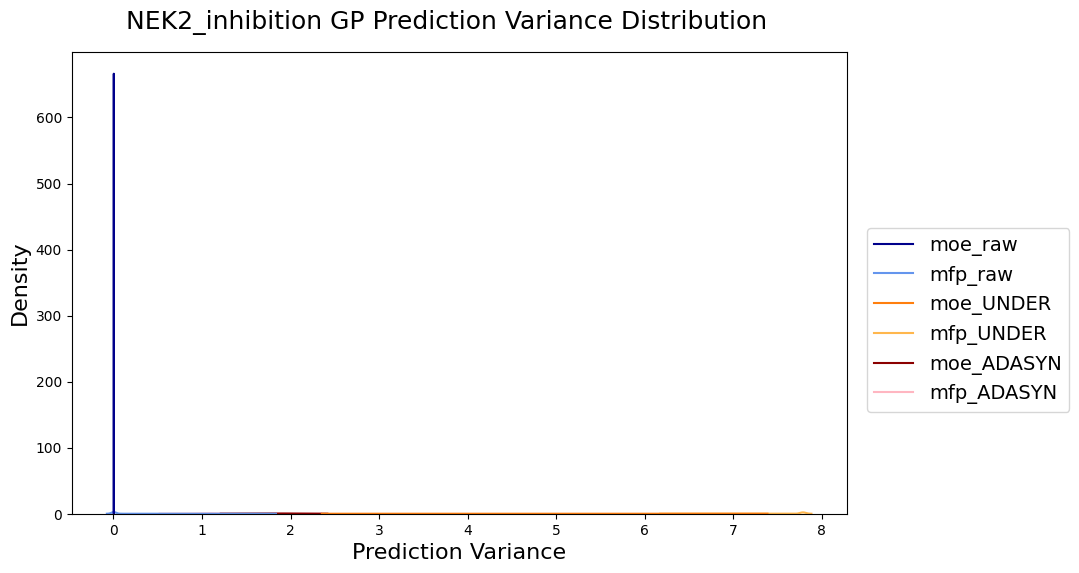

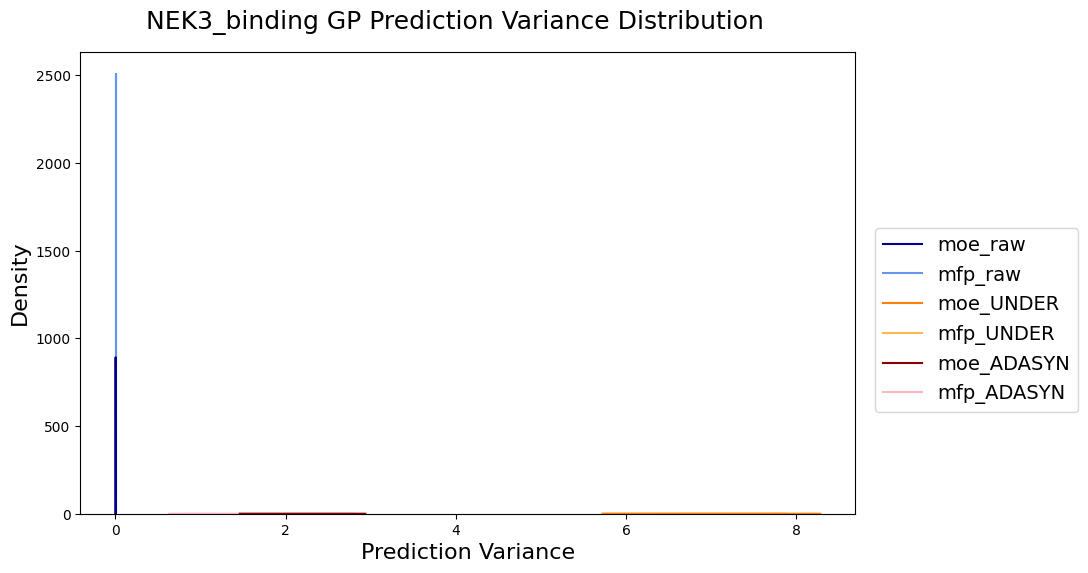

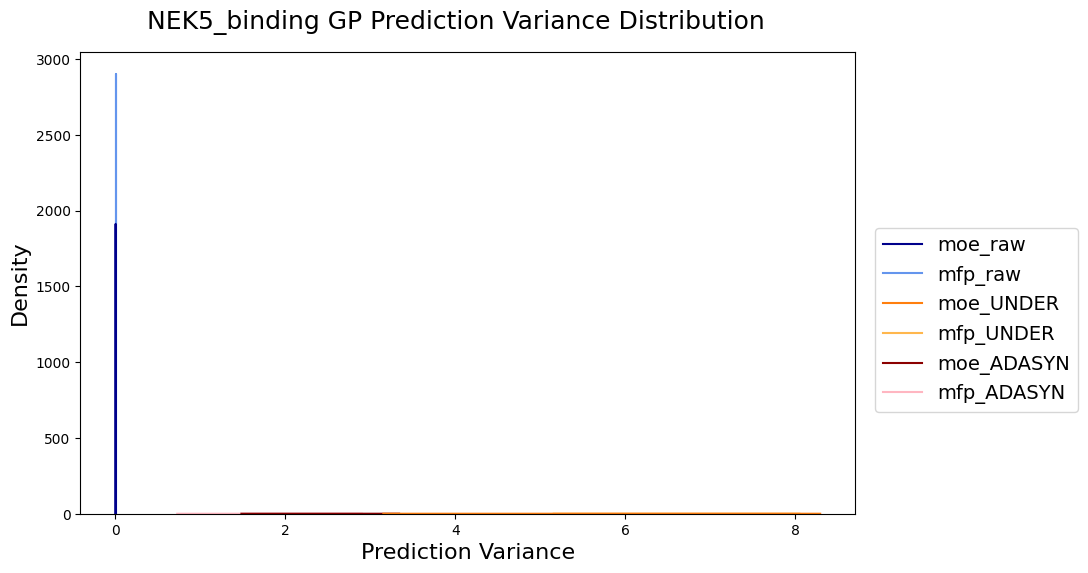

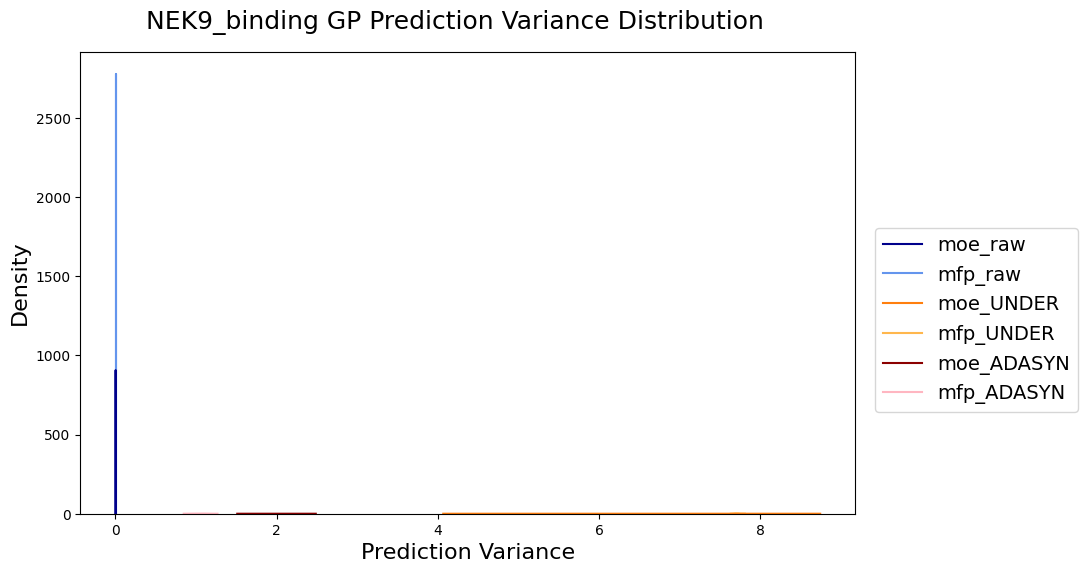

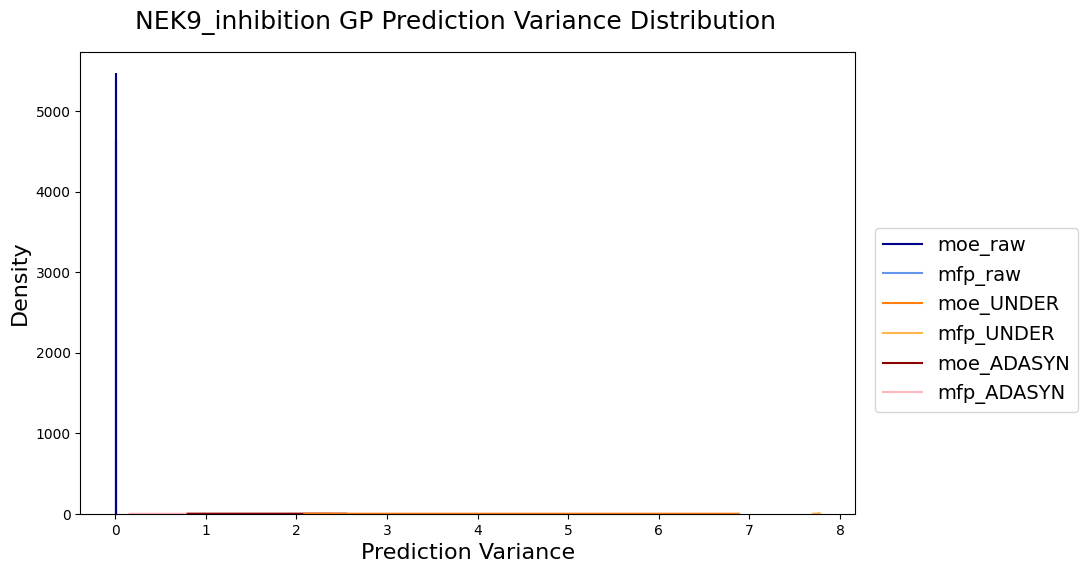

In [24]:
neks2 = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
dataset_colors_noSMOTE = {'moe_raw': 'darkblue', 'moe_UNDER': 'tab:orange', 'moe_ADASYN': 'darkred',
    'mfp_raw': 'cornflowerblue', 'mfp_UNDER': '#ffb74d','mfp_ADASYN': 'lightpink'}
dataset_order_noSMOTE = ['moe_raw', 'mfp_raw', 'moe_UNDER','mfp_UNDER','moe_ADASYN','mfp_ADASYN']
import matplotlib.lines as mlines

AD_no_raw = AD_noSMOTE[AD_noSMOTE['strategy']!='raw'] 
for nek in neks2: 
    df = AD_noSMOTE[AD_noSMOTE['NEK'] == nek]   
    df_flat = df.explode('Prediction Variance')
    # df_flat['ADdist'] = pd.to_numeric(df_flat['ADdist'])
    df_flat['Prediction Variance'] = pd.to_numeric(df_flat['Prediction Variance'])
    df_flat['dataset_category'] = df_flat['feat_type'].astype(str)+'_'+df['strategy'] 
    df_flat = df_flat.sort_values('strategy')
    plt.figure(figsize=(10,6))
    
    sns.kdeplot(data=df_flat, x='Prediction Variance', hue='dataset_category', palette=dataset_colors_noSMOTE, 
                legend=False,hue_order=dataset_order_noSMOTE)
    # sns.kdeplot(data=df_flat, x='ADdist', hue='dataset_category', palette=dataset_colors_noSMOTE, legend=False,hue_order=dataset_order_noSMOTE)
    handles = [mlines.Line2D([], [], color=dataset_colors_noSMOTE[val], label=val) for val in dataset_order_noSMOTE]
    
    # plt.legend(handles=handles, bbox_to_anchor=(0.78, -.15),loc='upper right',fontsize=14,ncols=2) # underneath 
    plt.legend(handles=handles, bbox_to_anchor=(1.3,.64),loc='upper right',fontsize=14,ncols=1) # on the right 
    plt.suptitle(f'{nek} GP Prediction Variance Distribution', y=0.95, fontsize=18)
    # plt.ylim(0,12)

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.ylabel('Density', fontsize=16)
    plt.xlabel('Prediction Variance', fontsize=16)
    figure_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/UQ_all_nek_gp/figures/KDE_plots/'
    # plt.savefig(f'{figure_path}{nek}_GP_variance.png',bbox_inches='tight')

    plt.show();
